<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/BNP/BNP_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "BNPFREUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 15:16:22,634 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 15:16:22,638 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for BNPFREUR
2019-08-27 15:19:30,244 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 15:26:54,754 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 15:30:01,118 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 15:33:25,073 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 15:37:01,055 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 15:40:30,436 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 15:43:41,095 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 15:48:08,859 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 16:00:52,871 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_BNPFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-BNPFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-BNPFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  0.62597  0.62668  0.62357  0.62358   9.504314
2018-01-02 09:00:00  0.62358  0.62408  0.61647  0.61807  10.688272
2018-01-02 10:00:00  0.61797  0.62058  0.61767  0.61857   6.608482
2018-01-02 11:00:00  0.61858  0.61978  0.61777  0.61877   5.763540
2018-01-02 12:00:00  0.61878  0.62198  0.61857  0.62178   4.258364
...                      ...      ...      ...      ...        ...
2018-12-31 08:00:00  0.39523  0.39667  0.39197  0.39293   7.806012
2018-12-31 09:00:00  0.39283  0.39452  0.39227  0.39452   6.204853
2018-12-31 10:00:00  0.39447  0.39452  0.39327  0.39418   5.660265
2018-12-31 11:00:00  0.39417  0.39428  0.39342  0.39388   4.635186
2018-12-31 12:00:00  0.39392  0.39508  0.39367  0.39483   5.916644

[2278 rows x 5 columns]

Open         High          Low        Close       Volume
count  2278.000000  2278.000000  2278.000000  2278.000000  2278.000000
mean      0.554230     0.555833     0.552598     0.554194     7.387558
std       0.075215     0.075347     0.075123     0.075280     4.065609
min       0.382130     0.385230     0.381670     0.382070     0.005880
25%       0.510403     0.511898     0.509095     0.510380     4.518043
50%       0.540570     0.541875     0.538920     0.540380     6.310925
75%       0.624480     0.626180     0.623170     0.624623     9.147432
max       0.685780     0.686480     0.684180     0.685980    38.147446

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close     Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2018-01-09 13:00:00  0.64847  0.64948  0.64827  0.64918   3.954300    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.648770  0.643307  0.644989  0.649659  0.648079  0.647377    0.647770    0.647730  0.644495  0.648200  0.649511  0.648600  0.648766  0.648200  0.648873  0.644772                0.651294                 0.648200                0.645106                0.652842                 0.648200                0.643558                0.654389                 0.648200                0.642011                0.655936                 0.648200                0.640464  0.648079  0.648966  0.645275                0.651173                 0.648079                0.644984                0.652720                 0.648079                0.643437                0.654268                 0.648079                0.641890                0.655815                 0.648079   
2018-01-09 14:00:00  0.64918  0.65077  0.64827  0.64967   9.843930    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.648815  0.643445  0.645624  0.649936  0.648432  0.647634    0.647770    0.648020  0.644958  0.648649  0.649763  0.648969  0.649093  0.648649  0.649425  0.645251                0.651406                 0.648649                0.645891                0.652785                 0.648649                0.644513                0.654164                 0.648649                0.643134                0.655542                 0.648649                0.641755  0.648432  0.649454  0.645755                0.651190                 0.648432                0.645675                0.652568                 0.648432                0.644296                0.653947                 0.648432                0.642918                0.655326                 0.648432   
2018-01-09 15:00:00  0.64958  0.65268  0.64877  0.65

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000    2228.000000  2228.000000   2228.000000     2228.000000     2228.000000       2228.000000  2228.000000  2228.000000  2228.000000  2228.000000   2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000   
mean      0.552409     0.554009     0.550771     0.552365     7.403244    15.998654     2.017953   185.310144      30.423698    11.373429      0.034111        0.023339        0.002244          0.004039     6.593357     2.532316    26.925045     2.017953      2.003142    26.925045     0.552892     0.553868    -0.006240     0.552366     0.552764     0.552889     0.552780     0.552748     0.553301     0.552765     0.552365     0.552765     0.552632     0.552765     0.552445     0.553558                0.557686                 0.552765                0.547844                0.560146                 0.552765                0.545384                0.562606                 0.552765                0.542924                0.565067                 0.552765                0.540463     0.552764     0.552449     0.553439                0.557685                 0.552764                0.547843                0.560145                 0.552764                0.545383                0.562605   
std       0.075039     0.075171     0.074938     0.075097     4.098647     8.573751     1.411875   101.814231       0.853958     2.621567      0.181556        0.151013        0.047330          0.063443     3.350474     1.102447    14.545447     1.411875      1.404492    14.545447     0.074875     0.074310     0.557886     0.075124     0.074846     0.074789     0.074899     0.074791     0.074536     0.074874     0.075104     0.074886     0.074939     0.074874     0.075041     0.074410                0.075071                 0.074874                0.074807                0.075218                 0.074874                0.074823                0.075397                 0.074874                0.074871                0.075608                 0.074874                0.074951     0.074846     0.075034     0.074483                0.075038                 0.074846                0.074784                0.075182                 0.074846                0.074803                0.075359   
min       0.382130     0.385230     0.3816

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.877128  0.877178  0.881293  0.878911  0.103520    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.879848  0.868306  0.971728  0.879983  0.878081  0.877884    0.874721    0.875470  0.862259  0.876416  0.880244  0.878002  0.878843  0.876416  0.879419  0.871038                0.873491                 0.876416                0.872796                0.869124                 0.876416                0.871343                0.862474                 0.876416                0.869975                0.855886                 0.876416                0.868703  0.878081  0.879817  0.871890                0.876099                 0.878081                0.873937                0.872130                 0.878081                0.871919                0.865387                 0.878081                0.870479                0.858699                 0.878081   
2018-01-09 14:00:00  0.879467  0.881461  0.881293  0.880524  0.257935    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.880000  0.868780  0.972191  0.880905  0.879270  0.878759    0.874721    0.876444  0.863777  0.877926  0.881077  0.879238  0.879937  0.877926  0.881248  0.872673                0.873868                 0.877926                0.875387                0.868933                 0.877926                0.874452                0.861723                 0.877926                0.873589                0.854585                 0.877926                0.872806  0.879270  0.881436  0.873521                0.876156                 0.879270                0.876222                0.871617                 0.879270                0.874739                0.864314                 0.879270                0.873811                0.857075                 0.879270   
2018-01-09 15:00:00  0.880784  0.887801  

52

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         2 hours 20 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_zdpznr
H2O cluster total nodes:    1
H2O cluster free memory:    5.796 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_161059_mod...  0.784549  0.548260              0.280345  0.433200  0.187662
1  DeepLearning_grid_1_AutoML_20190827_161059_mod...  0.763903  0.751922              0.285090  0.497858  0.247863
2  DeepLearning_grid_1_AutoML_20190827_161059_mod...  0.759074  0.647051              0.279970  0.476368  0.226926
3  DeepLearning_grid_1_AutoML_20190827_161059_mod...  0.756577  0.580925              0.305902  0.450048  0.202543
4  DeepLearning_grid_1_AutoML_20190827_161059_mod...  0.752165  0.727743              0.302864  0.488978  0.239100
5  DeepLearning_grid_1_AutoML_20190827_161059_mod...  0.745255  0.620347              0.284133  0.464225  0.215505
6  DeepLearning_grid_1_AutoML_20190827_161059_mod...  0.688978  2.203785              0.364594  0.600417  0.360500
7  DeepLearning_grid_1_AutoML_20190827_161059_mod...  0.603230  0.719557              0.460040  0.512960  0.263128
8              DeepLearning_1_AutoML_20190827_161059  0.595738  0.857402              0.446970  0.532286  0.283328
9  DeepLearning_grid_1_AutoML_20190827_161059_mod...  0.500000  0.679672              0.500000  0.493235  0.243281

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.006095
1                      TRANGE             0.492705           0.492705    0.003003
2                         DIV             0.491651           0.491651    0.002997
3              CDLEVENINGSTAR             0.486606           0.486606    0.002966
4                         SUB             0.484671           0.484671    0.002954
...                       ...                  ...                ...         ...
1032              MIDPOINT_20             0.127534           0.127534    0.000777
1033  BBANDS_lowerband_24_6_2             0.126297           0.126297    0.000770
1034                      Low             0.126005           0.126005    0.000768
1035                  MA_14_2             0.125527           0.125527    0.000765
1036       CDLSEPARATINGLINES             0.123864           0.123864    0.000755

[1037 rows x 4 columns]

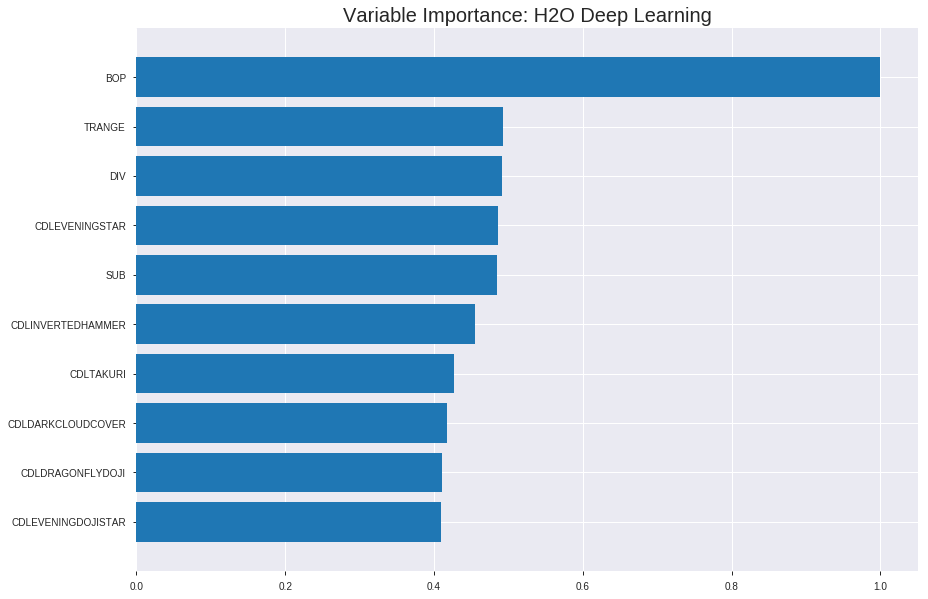

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_161059_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.198844480274671
RMSE: 0.4459198137273909
LogLoss: 0.6014400333128936
Mean Per-Class Error: 0.28501509529319446
AUC: 0.7776253840322387
pr_auc: 0.7257708687066022
Gini: 0.5552507680644774
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23193585261036742: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      477  375  0.4401   (375.0/852.0)
1      121  585  0.1714   (121.0/706.0)
Total  598  960  0.3184   (496.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.231936     0.702281  279
max f2                       0.0371671    0.824398  374
max f0point5                 0.472218     0.696486  183
max accuracy                 0.439432     0.720796  197
max precision                0.994093     1         0
max recall                   0.00257723   1         397
max specificity              0.994093     1         0
max absolute_mcc             0.439432     0.433976  197
max min_per_class_accuracy   0.370035     0.711048  224
max mean_per_class_accuracy  0.439432     0.714985  197

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 39.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.952364           1.79302   1.79302            0.8125           0.960647   0.8125                      0.960647            0.0184136       0.0184136                  79.3024    79.3024
    2        0.0205392                   0.934076           1.93095   1.86199            0.875            0.940846   0.84375                     0.950747            0.01983         0.0382436                  93.0949    86.1987
    3        0.0301669                   0.919783           1.91256   1.87813            0.866667         0.927965   0.851064                    0.943476            0.0184136       0.0566572                  91.2559    87.8127
    4        0.0404365                   0.909366           2.06887   1.92657            0.9375           0.913804   0.873016                    0.93594             0.0212465       0.0779037                  106.887    92.657
    5        0.0500642                   0.894884           1.61832   1.86729            0.733333         0.901834   0.846154                    0.929381            0.0155807       0.0934844                  61.8319    86.7291
    6        0.100128                    0.823922           1.75412   1.81071            0.794872         0.861227   0.820513                    0.895304            0.0878187       0.181303                   75.4122    81.0707
    7        0.150193                    0.768583           1.72583   1.78241            0.782051         0.79525    0.807692                    0.861953            0.0864023       0.267705                   72.583     78.2414
    8        0.200257                    0.712673           1.75412   1.77534            0.794872         0.740215   0.804487                    0.831518            0.0878187       0.355524                   75.4122    77.5341
    9        0.300385                    0.583712           1.45705   1.66925            0.660256         0.650595   0.75641                     0.77121             0.145892        0.501416                   45.7053    66.9245
    10       0.399872                    0.456029           1.26713   1.5692             0.574194         0.514665   0.711075                    0.707383            0.126062        0.627479                   26.713     56.92
    11       0.5                         0.344223           0.99023   1.45326            0.448718         0.400986   0.658537                    0.646025            0.0991501       0.726629                   -0.976974  45.3258
    12       0.600128                    0.248307           0.820477  1.34768            0.371795         0.293622   0.610695                    0.587228            0.082153        0.808782                   -17.9523   34.7681
    13       0.699615                    0.152245           0.697633  1.25524            0.316129         0.198901   0.568807                    0.532007            0.0694051       0.878187                   -30.2367   25.5243
    14       0.799743                    0.0801028          0.650723  1.17956            0.294872         0.113435   0.53451                     0.479602            0.0651558       0.943343                   -34.9277   17.9557
    15       0.899872                    0.028686           0.396092  1.09238            0.179487         0.052825   0.495007                    0.432114            0.0396601       0.983003                   -60.3908   9.23812
    16       1                           4.29661e-08        0.169754  1                  0.0769231        0.0121524  0.453145     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19079620961269955
RMSE: 0.43680225458747296
LogLoss: 0.5715499191701036
Mean Per-Class Error: 0.2626107283464567
AUC: 0.7970287893700787
pr_auc: 0.708070502904798
Gini: 0.5940575787401574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5812527137506932: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      188  66   0.2598   (66.0/254.0)
1      52   140  0.2708   (52.0/192.0)
Total  240  206  0.2646   (118.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.581253     0.703518  178
max f2                       0.168839     0.825369  342
max f0point5                 0.71251      0.720899  121
max accuracy                 0.71251      0.742152  121
max precision                0.995394     1         0
max recall                   0.116596     1         361
max specificity              0.995394     1         0
max absolute_mcc             0.61802      0.474482  168
max min_per_class_accuracy   0.581253     0.729167  178
max mean_per_class_accuracy  0.61802      0.737389  168

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 51.88 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.970974           1.39375    1.39375            0.6              0.987901   0.6                         0.987901            0.015625        0.015625                   39.375    39.375
    2        0.0201794                   0.95932            2.32292    1.80671            1                0.963992   0.777778                    0.977275            0.0208333       0.0364583                  132.292   80.6713
    3        0.0313901                   0.949583           1.39375    1.65923            0.6              0.953938   0.714286                    0.96894             0.015625        0.0520833                  39.375    65.9226
    4        0.0403587                   0.942905           1.74219    1.67766            0.75             0.945703   0.722222                    0.963777            0.015625        0.0677083                  74.2188   67.7662
    5        0.0515695                   0.933545           1.85833    1.71694            0.8              0.938475   0.73913                     0.958276            0.0208333       0.0885417                  85.8333   71.6938
    6        0.100897                    0.886733           2.00616    1.85833            0.863636         0.912845   0.8                         0.936065            0.0989583       0.1875                     100.616   85.8333
    7        0.150224                    0.853466           2.21733    1.97621            0.954545         0.87352    0.850746                    0.915528            0.109375        0.296875                   121.733   97.6213
    8        0.201794                    0.814238           1.51495    1.85833            0.652174         0.836445   0.8                         0.895318            0.078125        0.375                      51.4946   85.8333
    9        0.300448                    0.72418            1.6366     1.78553            0.704545         0.770944   0.768657                    0.854479            0.161458        0.536458                   63.66     78.5525
    10       0.401345                    0.643179           1.29051    1.66108            0.555556         0.683805   0.715084                    0.811572            0.130208        0.666667                   29.0509   66.108
    11       0.5                         0.528059           0.844697   1.5                0.363636         0.588884   0.64574                     0.767633            0.0833333       0.75                       -15.5303  50
    12       0.600897                    0.409961           0.774306   1.37815            0.333333         0.462721   0.593284                    0.716435            0.078125        0.828125                   -22.5694  37.8148
    13       0.699552                    0.336437           0.73911    1.28803            0.318182         0.374052   0.554487                    0.66815             0.0729167       0.901042                   -26.089   28.8028
    14       0.800448                    0.226583           0.516204   1.19074            0.222222         0.275303   0.512605                    0.618632            0.0520833       0.953125                   -48.3796  19.0739
    15       0.899103                    0.123682           0.422348   1.10643            0.181818         0.176697   0.476309                    0.57014             0.0416667       0.994792                   -57.7652  10.6427
    16       1                           0.000145132        0.0516204  1                  0.0222222        0.0613673  0.430493        


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:13:44  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:13:46  2 min 45.156 sec  486 obs/sec       0.588575  1             917        0.570635         1.78712             -0.314038      0.687798        0.577852           1.1034           0.41335                          0.561754           1.58084               -0.287143        0.708846          0.610624             2.32292            0.383408
    2019-08-27 16:13:57  2 min 55.689 sec  491 obs/sec       3.59307   6             5598       0.551619         2.30733             -0.227916      0.719833        0.486471           1.93095          0.342747                         0.615251           4.35225               -0.54397         0.719293          0.61602              1.85833            0.316143
    2019-08-27 16:14:07  3 min  5.981 sec  495 obs/sec       6.5629    11            10225      0.501035         1.35063             -0.0130416     0.766931        0.66239            1.93095          0.31258                          0.550208           2.26555               -0.234779        0.769839          0.674556             1.39375            0.275785
    2019-08-27 16:14:18  3 min 16.353 sec  496 obs/sec       9.5552    16            14887      0.573246         2.04771             -0.32609       0.68998         0.43724            1.79302          0.410141                         0.706156           5.27172               -1.03393         0.7504            0.385443             1.39375            0.302691
    2019-08-27 16:14:28  3 min 26.727 sec  498 obs/sec       12.5732   21            19589      0.456499         0.748805            0.159049       0.805555        0.700601           1.93095          0.291399                         0.492357           0.934242              0.0112314        0.793707          0.700861             0.929167           0.304933
    2019-08-27 16:14:40  3 min 38.598 sec  499 obs/sec       16.0822   27            25056      0.443985         0.621638            0.204524       0.79387         0.733582           1.6551           0.291399                         0.447003           0.639335              0.185005         0.783916          0.70361              1.39375            0.282511
    2019-08-27 16:14:52  3 min 50.585 sec  501 obs/sec       19.6759   33            30655      0.459645         0.634145            0.147419       0.796194        0.7279             1.51717          0.283697                         0.513067           0.834032              -0.0737011       0.76747           0.665734             1.39375            0.282511
    2019-08-27 16:15:04  4 min  2.592 sec  502 obs/sec       23.2529   39            36228      0.471105         0.654642            0.104374       0.777473        0.695531           1.37925          0.320282                         0.526957           0.861685              -0.132624        0.740506          0.631081             1.39375            0.372197
    2019-08-27 16:15:16

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.0060948115953570305
TRANGE                   0.49270471930503845    0.49270471930503845  0.0030029424363074795
DIV                      0.4916510283946991     0.4916510283946991   0.002996520388729221
CDLEVENINGSTAR           0.48660600185394287    0.48660600185394287  0.002965771902469736
SUB                      0.4846707880496979     0.4846707880496979   0.0029539771389361287
---                      ---                    ---                  ---
MIDPOINT_20              0.12753430008888245    0.12753430008888245  0.000777297530987464
BBANDS_lowerband_24_6_2  0.1262969821691513     0.1262969821691513   0.0007697563113831436
Low                      0.12600494921207428    0.12600494921207428  0.0007679764255301241
MA_14_2                  0.1255267858505249     0.1255267858505249   0.000765062109929678
CDLSEPARATINGLINES       0.12386441230773926    0.12386441230773926  0.0007549302563852933


See the whole table with table.as_data_frame()


('accuracy', 0.7354260089686099)

('F1', 0.6859903381642511)

('auc', 0.7845487845487845)

('logloss', 0.5482600431669391)

('mean_per_class_error', 0.28034465534465536)

('rmse', 0.43320003031543136)

('mse', 0.18766226626529067)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


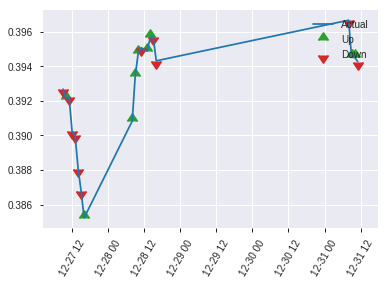


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18766226626529067
RMSE: 0.43320003031543136
LogLoss: 0.5482600431669391
Mean Per-Class Error: 0.28034465534465536
AUC: 0.7845487845487845
pr_auc: 0.6886119695244973
Gini: 0.569097569097569
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42269264371307486: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      87   45   0.3409   (45.0/132.0)
1      20   71   0.2198   (20.0/91.0)
Total  107  116  0.2915   (65.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422693     0.68599   115
max f2                       0.129175     0.81982   190
max f0point5                 0.601234     0.684755  73
max accuracy                 0.601234     0.735426  73
max precision                0.959408     1         0
max recall                   0.129175     1         190
max specificity              0.959408     1         0
max absolute_mcc             0.598922     0.443302  77
max min_per_class_accuracy   0.459539     0.69697   103
max mean_per_class_accuracy  0.422693     0.719655  115

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 44.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.928921           2.45055   2.45055            1                0.944668   1                           0.944668            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.915583           2.45055   2.45055            1                0.920827   1                           0.935132            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.904459           1.22527   2.10047            0.5              0.910426   0.857143                    0.928073            0.010989        0.0659341                  22.5275   110.047
    4        0.0403587                   0.900187           2.45055   2.17827            1                0.902079   0.888889                    0.922296            0.021978        0.0879121                  145.055   117.827
    5        0.0538117                   0.873248           1.6337    2.04212            0.666667         0.885858   0.833333                    0.913187            0.021978        0.10989                    63.37     104.212
    6        0.103139                    0.810078           1.78222   1.91782            0.727273         0.836507   0.782609                    0.876514            0.0879121       0.197802                   78.2218   91.7821
    7        0.152466                    0.764796           2.005     1.94602            0.818182         0.781629   0.794118                    0.845816            0.0989011       0.296703                   100.5     94.6025
    8        0.201794                    0.728214           1.33666   1.79707            0.545455         0.739907   0.733333                    0.819927            0.0659341       0.362637                   33.6663   79.707
    9        0.300448                    0.616263           1.55944   1.71904            0.636364         0.663486   0.701493                    0.768558            0.153846        0.516484                   55.9441   71.9042
    10       0.399103                    0.548752           1.33666   1.62452            0.545455         0.586231   0.662921                    0.723488            0.131868        0.648352                   33.6663   62.4522
    11       0.502242                    0.443589           0.852365  1.46595            0.347826         0.48899    0.598214                    0.675333            0.0879121       0.736264                   -14.7635  46.5954
    12       0.600897                    0.343886           0.891109  1.37158            0.363636         0.386408   0.559701                    0.627897            0.0879121       0.824176                   -10.8891  37.1576
    13       0.699552                    0.252518           0.891109  1.30382            0.363636         0.294333   0.532051                    0.580856            0.0879121       0.912088                   -10.8891  30.3818
    14       0.798206                    0.178565           0.445554  1.19774            0.181818         0.209132   0.488764                    0.534913            0.043956        0.956044                   -55.4446  19.774
    15       0.896861                    0.0879898          0.445554  1.115              0.181818         0.136428   0.455                       0.491079            0.043956        1                          -55.4446  11.5
    16       1                           0.000970085        0         1                  0                0.0490505  0.408072                    0.44

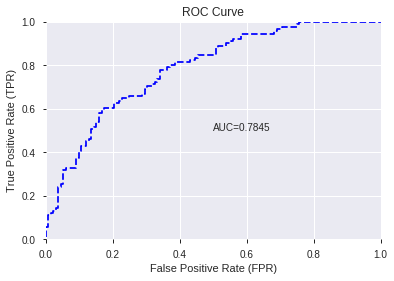

This function is available for GLM models only


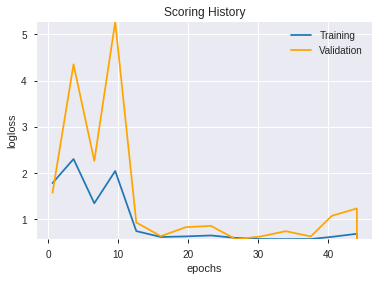

--2019-08-27 16:44:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.88
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.88|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_161059_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_161059_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_164414_model_7  0.783716  0.600861              0.305694  0.444966  0.197995
1  DeepLearning_grid_1_AutoML_20190827_164414_model_9  0.782634  0.552299              0.292458  0.434324  0.188637
2  DeepLearning_grid_1_AutoML_20190827_164414_model_8  0.782218  0.556919              0.315351  0.435287  0.189475
3  DeepLearning_grid_1_AutoML_20190827_164414_model_6  0.777140  0.543049              0.295288  0.430893  0.185669
4  DeepLearning_grid_1_AutoML_20190827_164414_model_2  0.774059  0.595184              0.305694  0.446971  0.199783
5  DeepLearning_grid_1_AutoML_20190827_164414_model_3  0.765485  0.613437              0.300991  0.448428  0.201087
6  DeepLearning_grid_1_AutoML_20190827_164414_model_5  0.760823  0.577710              0.295663  0.442582  0.195878
7               DeepLearning_1_AutoML_20190827_164414  0.729853  0.601603              0.326340  0.456854  0.208715
8  DeepLearning_grid_1_AutoML_20190827_164414_model_1  0.719031  0.938457              0.309108  0.486710  0.236887
9  DeepLearning_grid_1_AutoML_20190827_164414_model_4  0.702381  0.817152              0.363844  0.514360  0.264566

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.023511
1    CDLMORNINGDOJISTAR             0.897598           0.897598    0.021103
2     CDLSTALLEDPATTERN             0.886054           0.886054    0.020832
3              CORREL_8             0.878824           0.878824    0.020662
4    CDLCLOSINGMARUBOZU             0.875571           0.875571    0.020585
5             CDLTAKURI             0.875415           0.875415    0.020582
6     CDLDARKCLOUDCOVER             0.872748           0.872748    0.020519
7         CDLHANGINGMAN             0.868068           0.868068    0.020409
8          CDLTHRUSTING             0.866711           0.866711    0.020377
9                TRANGE             0.865593           0.865593    0.020351
10        days_in_month             0.865579           0.865579    0.020350
11       CDLEVENINGSTAR             0.865558           0.865558    0.020350
12       STOCHRSI_fastk             0.865015           0.865015    0.020337
13               SAREXT             0.864134           0.864134    0.020316
14        CDLHIKKAKEMOD             0.863287           0.863287    0.020296
15                  SUB             0.862969           0.862969    0.020289
16            CDLONNECK             0.861425           0.861425    0.020253
17         is_month_end             0.859317           0.859317    0.020203
18          CDLLONGLINE             0.857235           0.857235    0.020154
19   CDLEVENINGDOJISTAR             0.855304           0.855304    0.020109
20       STOCHRSI_fastd             0.854893           0.854893    0.020099
21                 hour             0.853685           0.853685    0.020071
22         HT_TRENDMODE             0.853681           0.853681    0.020071
23     CDLDRAGONFLYDOJI             0.853364           0.853364    0.020063
24      CDLLADDERBOTTOM             0.853099           0.853099    0.020057
25            CDLINNECK             0.852481           0.852481    0.020042
26            CORREL_24             0.850793           0.850793    0.020003
27                  DIV             0.848886           0.848886    0.019958
28            CORREL_14             0.848727           0.848727    0.019954
29       CDLMATCHINGLOW             0.846037           0.846037    0.019891
30  CDLGAPSIDESIDEWHITE             0.842065           0.842065    0.019797
31    CDLINVERTEDHAMMER             0.842057           0.842057    0.019797
32         STOCHF_fastk             0.841835           0.841835    0.019792
33       CDLMORNINGSTAR             0.840792           0.840792    0.019768
34       is_month_start             0.840650           0.840650    0.019764
35           CDL3INSIDE             0.839647           0.839647    0.019741
36      CDLSHOOTINGSTAR             0.838825           0.838825    0.019721
37      CDLHOMINGPIGEON             0.836295           0.836295    0.019662
38       CDLHARAMICROSS             0.832881           0.832881    0.019582
39  CDLXSIDEGAP3METHODS             0.831846           0.831846    0.019557
40    CDLGRAVESTONEDOJI             0.831565           0.831565    0.019551
41      CDLUNIQUE3RIVER             0.830418           0.830418    0.019524
42    CDL3WHITESOLDIERS             0.829942           0.829942    0.019512
43       CDL3LINESTRIKE             0.829035           0.829035    0.019491
44      CDLADVANCEBLOCK             0.824180           0.824180    0.019377
45            CDLHAMMER             0.812297           0.812297    0.019098
46          STOCH_slowd             0.806603           0.806603    0.018964
47         CDLTASUKIGAP             0.803809           0.803809    0.018898
48   CDLIDENTICAL3CROWS             0.782159           0.782159    0.018389
49            CORREL_12             0.774976           0.774976    0.018220

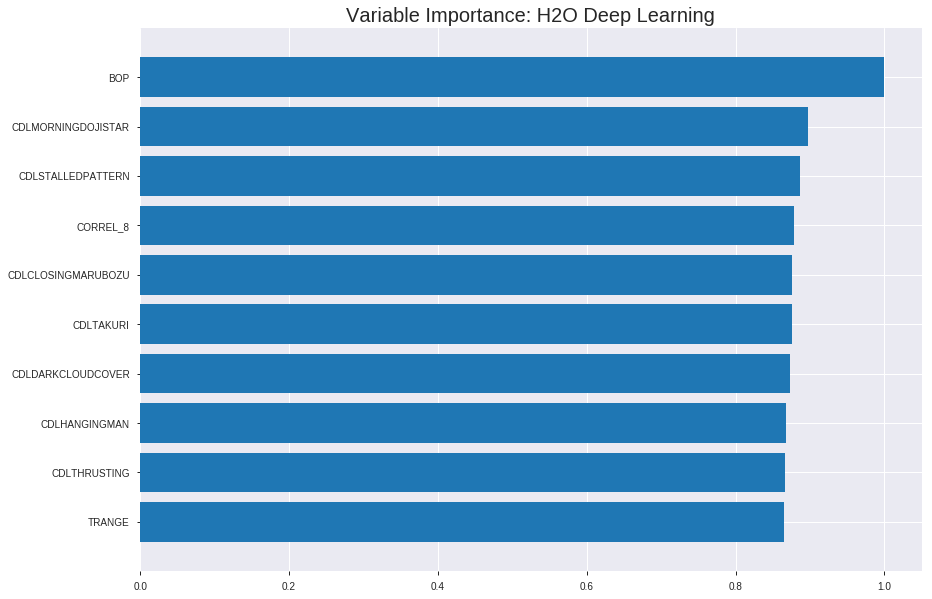

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_164414_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1806235221800304
RMSE: 0.4249982613847148
LogLoss: 0.5469479136110029
Mean Per-Class Error: 0.26105879849446056
AUC: 0.809764393727806
pr_auc: 0.7608376268349262
Gini: 0.6195287874556119
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32990338531621094: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      477  375  0.4401   (375.0/852.0)
1      89   617  0.1261   (89.0/706.0)
Total  566  992  0.2978   (464.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329903     0.726737  261
max f2                       0.134556     0.843819  335
max f0point5                 0.61294      0.722084  159
max accuracy                 0.579615     0.741335  170
max precision                0.996451     1         0
max recall                   0.00358851   1         396
max specificity              0.996451     1         0
max absolute_mcc             0.517242     0.476181  194
max min_per_class_accuracy   0.517242     0.737089  194
max mean_per_class_accuracy  0.517242     0.738941  194

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 47.75 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.988065           2.2068     2.2068             1                0.9919      1                           0.9919              0.0226629       0.0226629                  120.68    120.68
    2        0.0205392                   0.983216           1.93095    2.06887            0.875            0.985636    0.9375                      0.988768            0.01983         0.0424929                  93.0949   106.887
    3        0.0301669                   0.97771            1.91256    2.01899            0.866667         0.980086    0.914894                    0.985997            0.0184136       0.0609065                  91.2559   101.899
    4        0.0404365                   0.972035           2.06887    2.03166            0.9375           0.975139    0.920635                    0.98324             0.0212465       0.082153                   106.887   103.166
    5        0.0500642                   0.963149           1.76544    1.98046            0.8              0.967398    0.897436                    0.980193            0.0169972       0.0991501                  76.5439   98.0461
    6        0.100128                    0.914894           1.839      1.90973            0.833333         0.94188     0.865385                    0.961037            0.092068        0.191218                   83.8999   90.973
    7        0.150193                    0.852967           1.64095    1.82014            0.74359          0.880637    0.824786                    0.934237            0.082153        0.273371                   64.0953   82.0138
    8        0.200257                    0.806368           1.72583    1.79656            0.782051         0.829027    0.814103                    0.907935            0.0864023       0.359773                   72.583    79.6561
    9        0.300385                    0.706893           1.49949    1.69754            0.679487         0.756846    0.769231                    0.857572            0.150142        0.509915                   49.9492   69.7538
    10       0.399872                    0.613119           1.45222    1.6365             0.658065         0.660727    0.741573                    0.808597            0.144476        0.654391                   45.2216   63.6503
    11       0.5                         0.48924            1.01852    1.51275            0.461538         0.551527    0.685494                    0.757117            0.101983        0.756374                   1.85226   51.2748
    12       0.600128                    0.375464           0.778038   1.39017            0.352564         0.4301      0.629947                    0.702556            0.0779037       0.834278                   -22.1962  39.0165
    13       0.699615                    0.239407           0.783058   1.30383            0.354839         0.311413    0.590826                    0.646935            0.0779037       0.912181                   -21.6942  30.3833
    14       0.799743                    0.116611           0.579992   1.21321            0.262821         0.177327    0.549759                    0.58814             0.0580737       0.970255                   -42.0008  21.3208
    15       0.899872                    0.0233932          0.212192   1.10183            0.0961538        0.0633126   0.499287                    0.529742            0.0212465       0.991501                   -78.7808  10.1825
    16       1                           8.84153e-07        0.0848769  1                  0.0384615        0.007



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19439344516451956
RMSE: 0.44090072030392463
LogLoss: 0.596095223606636
Mean Per-Class Error: 0.2636154855643045
AUC: 0.7843975557742782
pr_auc: 0.695460847965954
Gini: 0.5687951115485563
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4689046180129808: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      173  81   0.3189   (81.0/254.0)
1      40   152  0.2083   (40.0/192.0)
Total  213  233  0.2713   (121.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468905     0.715294  210
max f2                       0.24196      0.821033  286
max f0point5                 0.637627     0.690045  154
max accuracy                 0.637627     0.7287    154
max precision                0.991663     1         0
max recall                   0.0113578    1         382
max specificity              0.991663     1         0
max absolute_mcc             0.468905     0.46865   210
max min_per_class_accuracy   0.527368     0.720472  190
max mean_per_class_accuracy  0.468905     0.736385  210

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 48.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.983943           2.32292   2.32292            1                0.988024   1                           0.988024            0.0260417       0.0260417                  132.292   132.292
    2        0.0201794                   0.978769           1.74219   2.06481            0.75             0.981387   0.888889                    0.985075            0.015625        0.0416667                  74.2188   106.481
    3        0.0313901                   0.972859           1.85833   1.99107            0.8              0.975452   0.857143                    0.981638            0.0208333       0.0625                     85.8333   99.1071
    4        0.0403587                   0.962789           1.74219   1.93576            0.75             0.969318   0.833333                    0.9789              0.015625        0.078125                   74.2188   93.5764
    5        0.0515695                   0.953716           1.39375   1.81793            0.6              0.958555   0.782609                    0.974477            0.015625        0.09375                    39.375    81.7935
    6        0.100897                    0.897786           1.47822   1.65185            0.636364         0.925337   0.711111                    0.950453            0.0729167       0.166667                   47.822    65.1852
    7        0.150224                    0.848887           1.90057   1.73352            0.818182         0.875734   0.746269                    0.925918            0.09375         0.260417                   90.0568   73.352
    8        0.201794                    0.800736           1.61594   1.70347            0.695652         0.824584   0.733333                    0.900022            0.0833333       0.34375                    61.5942   70.3472
    9        0.300448                    0.729501           1.58381   1.66418            0.681818         0.76749    0.716418                    0.856504            0.15625         0.5                        58.3807   66.4179
    10       0.401345                    0.625116           1.44537   1.60917            0.622222         0.682266   0.692737                    0.812701            0.145833        0.645833                   44.537    60.9171
    11       0.5                         0.490233           1.10866   1.51042            0.477273         0.553793   0.650224                    0.761616            0.109375        0.755208                   10.8665   51.0417
    12       0.600897                    0.368114           0.877546  1.40415            0.377778         0.426884   0.604478                    0.705411            0.0885417       0.84375                    -12.2454  40.4151
    13       0.699552                    0.245327           0.791903  1.31781            0.340909         0.314126   0.567308                    0.65023             0.078125        0.921875                   -20.8097  31.7808
    14       0.800448                    0.127669           0.154861  1.17122            0.0666667        0.183452   0.504202                    0.591392            0.015625        0.9375                     -84.5139  17.1218
    15       0.899103                    0.0307984          0.527936  1.10063            0.227273         0.071787   0.473815                    0.534378            0.0520833       0.989583                   -47.2064  10.0634
    16       1                           6.7868e-05         0.103241  1                  0.0444444        0.0104232  0.430493                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:48:14  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:48:19  5.572 sec         220 obs/sec       0.655969  1             1022       0.46754          0.783068            0.117879       0.772343        0.693834           1.6551           0.306804                         0.468787           0.741782              0.103632         0.773325          0.698856             2.32292            0.327354
    2019-08-27 16:48:29  15.917 sec        432 obs/sec       3.91399   6             6098       0.424998         0.546948            0.271105       0.809764        0.760838           2.2068           0.297818                         0.440901           0.596095              0.207104         0.784398          0.695461             2.32292            0.2713
    2019-08-27 16:48:39  25.820 sec        487 obs/sec       7.18549   11            11195      0.418383         0.524826            0.293619       0.822447        0.761175           1.93095          0.252246                         0.453573           0.623843              0.160871         0.757464          0.659416             2.32292            0.311659
    2019-08-27 16:48:50  37.195 sec        520 obs/sec       11.1264   17            17335      0.412214         0.529286            0.314296       0.838435        0.79133            2.2068           0.242619                         0.451445           0.691506              0.168724         0.782501          0.681544             1.39375            0.289238
    2019-08-27 16:49:01  47.905 sec        544 obs/sec       15.0745   23            23486      0.472957         0.692776            0.0973188      0.858312        0.801593           2.2068           0.224647                         0.534781           0.946782              -0.166505        0.76909           0.662061             1.85833            0.286996
    2019-08-27 16:49:11  57.962 sec        566 obs/sec       19.0083   29            29615      0.41238          0.53031             0.313746       0.864104        0.822965           2.2068           0.226573                         0.463253           0.770072              0.124673         0.769142          0.678332             1.85833            0.311659
    2019-08-27 16:49:21  1 min  7.948 sec  581 obs/sec       22.9384   35            35738      0.385422         0.4551              0.400536       0.872673        0.815076           2.2068           0.225931                         0.452171           0.719339              0.166051         0.773817          0.681571             1.85833            0.289238
    2019-08-27 16:49:22  1 min  8.847 sec  581 obs/sec       22.9384   35            35738      0.424998         0.546948            0.271105       0.809764        0.760838           2.2068           0.297818                         0.440901           0.596095              0.207104         0.784398          0.695461             2.32292            0.2713

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.023510642367880696
CDLMORNINGDOJISTAR  0.897598385810852      0.897598385810852    0.02110311463878594
CDLSTALLEDPATTERN   0.8860536813735962     0.8860536813735962   0.020831691221518733
CORREL_8            0.8788235187530518     0.8788235187530518   0.020661705453885494
CDLCLOSINGMARUBOZU  0.8755713105201721     0.8755713105201721   0.020585243949216382
---                 ---                    ---                  ---
CDLHAMMER           0.8122973442077637     0.8122973442077637   0.019097632356048017
STOCH_slowd         0.8066033124923706     0.8066033124923706   0.01896376201275604
CDLTASUKIGAP        0.8038089275360107     0.8038089275360107   0.01889806422740888
CDLIDENTICAL3CROWS  0.7821585536003113     0.7821585536003113   0.01838905002867576
CORREL_12           0.7749763131141663     0.7749763131141663   0.01822019094120589


See the whole table with table.as_data_frame()


('accuracy', 0.7399103139013453)

('F1', 0.685483870967742)

('auc', 0.7837162837162837)

('logloss', 0.600860695931706)

('mean_per_class_error', 0.28188478188478183)

('rmse', 0.4449660429753625)

('mse', 0.19799477940115215)

deeplearning prediction progress: |███████████████████████████████████████| 100%


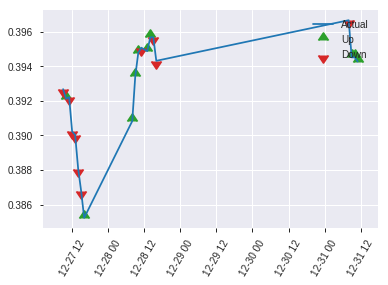


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19799477940115215
RMSE: 0.4449660429753625
LogLoss: 0.600860695931706
Mean Per-Class Error: 0.28188478188478183
AUC: 0.7837162837162837
pr_auc: 0.6684096186005634
Gini: 0.5674325674325673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28258105517525256: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   72   0.5455   (72.0/132.0)
1      6    85   0.0659   (6.0/91.0)
Total  66   157  0.3498   (78.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.282581     0.685484  156
max f2                       0.246762     0.81749   161
max f0point5                 0.738772     0.696379  66
max accuracy                 0.738772     0.73991   66
max precision                0.995064     1         0
max recall                   0.0248295    1         208
max specificity              0.995064     1         0
max absolute_mcc             0.738772     0.450964  66
max min_per_class_accuracy   0.545817     0.703297  102
max mean_per_class_accuracy  0.607092     0.718115  86

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 49.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.987899           1.6337    1.6337             0.666667         0.991981   0.666667                    0.991981            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.980701           2.45055   1.96044            1                0.985689   0.8                         0.989464            0.021978        0.043956                   145.055   96.044
    3        0.0313901                   0.975522           2.45055   2.10047            1                0.976317   0.857143                    0.985708            0.021978        0.0659341                  145.055   110.047
    4        0.0403587                   0.974068           1.22527   1.90598            0.5              0.974973   0.777778                    0.983322            0.010989        0.0769231                  22.5275   90.5983
    5        0.0538117                   0.967621           2.45055   2.04212            1                0.971448   0.833333                    0.980354            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.901947           1.78222   1.91782            0.727273         0.938306   0.782609                    0.960244            0.0879121       0.197802                   78.2218   91.7821
    7        0.152466                    0.858848           1.78222   1.87395            0.727273         0.88347    0.764706                    0.935405            0.0879121       0.285714                   78.2218   87.395
    8        0.201794                    0.811866           1.11389   1.68816            0.454545         0.838472   0.688889                    0.911711            0.0549451       0.340659                   11.3886   68.8156
    9        0.300448                    0.73858            2.11638   1.82877            0.863636         0.764598   0.746269                    0.863405            0.208791        0.549451                   111.638   82.8768
    10       0.399103                    0.601208           1.0025    1.62452            0.409091         0.665995   0.662921                    0.814607            0.0989011       0.648352                   0.24975   62.4522
    11       0.502242                    0.485446           0.958911  1.48783            0.391304         0.544437   0.607143                    0.759126            0.0989011       0.747253                   -4.10893  48.7834
    12       0.600897                    0.410159           0.77972   1.37158            0.318182         0.449959   0.559701                    0.708367            0.0769231       0.824176                   -22.028   37.1576
    13       0.699552                    0.283106           1.0025    1.31953            0.409091         0.34911    0.538462                    0.657703            0.0989011       0.923077                   0.24975   31.9527
    14       0.798206                    0.164084           0.334166  1.19774            0.136364         0.222095   0.488764                    0.603863            0.032967        0.956044                   -66.5834  19.774
    15       0.896861                    0.0617428          0.334166  1.10275            0.136364         0.115709   0.45                        0.550166            0.032967        0.989011                   -66.5834  10.2747
    16       1                           2.73678e-05        0.106546  1                  0.0434783        0.0205962  0.408072                    0.49

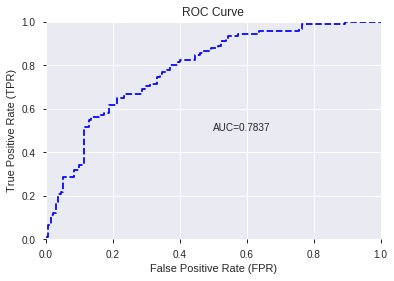

This function is available for GLM models only


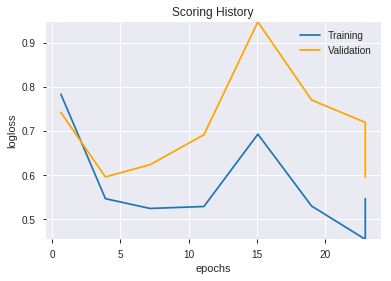

--2019-08-27 16:51:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.187.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.187.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_164414_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_164414_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLMORNINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CORREL_8',
 'CDLCLOSINGMARUBOZU',
 'CDLTAKURI',
 'CDLDARKCLOUDCOVER',
 'CDLHANGINGMAN',
 'CDLTHRUSTING',
 'TRANGE',
 'days_in_month',
 'CDLEVENINGSTAR',
 'STOCHRSI_fastk',
 'SAREXT',
 'CDLHIKKAKEMOD',
 'SUB',
 'CDLONNECK',
 'is_month_end',
 'CDLLONGLINE',
 'CDLEVENINGDOJISTAR',
 'STOCHRSI_fastd',
 'hour',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLLADDERBOTTOM',
 'CDLINNECK',
 'CORREL_24',
 'DIV',
 'CORREL_14',
 'CDLMATCHINGLOW',
 'CDLGAPSIDESIDEWHITE',
 'CDLINVERTEDHAMMER',
 'STOCHF_fastk',
 'CDLMORNINGSTAR',
 'is_month_start',
 'CDL3INSIDE',
 'CDLSHOOTINGSTAR',
 'CDLHOMINGPIGEON',
 'CDLHARAMICROSS',
 'CDLXSIDEGAP3METHODS',
 'CDLGRAVESTONEDOJI',
 'CDLUNIQUE3RIVER',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'CDLADVANCEBLOCK',
 'CDLHAMMER',
 'STOCH_slowd',
 'CDLTASUKIGAP',
 'CDLIDENTICAL3CROWS',
 'CORREL_12']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_165130_model_1  0.777473  0.558494                0.3002  0.435621  0.189766

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.624302           1.000000    0.156041
1          STOCHF_fastk             0.221666           0.355062    0.055404
2                TRANGE             0.209138           0.334995    0.052273
3                   SUB             0.184020           0.294761    0.045995
4                   DIV             0.169494           0.271494    0.042364
5        STOCHRSI_fastd             0.164826           0.264016    0.041197
6                  hour             0.153109           0.245248    0.038269
7              CORREL_8             0.126966           0.203373    0.031735
8             CORREL_14             0.123999           0.198620    0.030993
9        STOCHRSI_fastk             0.122241           0.195804    0.030553
10            CORREL_24             0.108451           0.173716    0.027107
11        CDLHANGINGMAN             0.100475           0.160940    0.025113
12       CDL3LINESTRIKE             0.087695           0.140469    0.021919
13            CORREL_12             0.087655           0.140405    0.021909
14     CDLDRAGONFLYDOJI             0.085580           0.137081    0.021390
15            CDLTAKURI             0.085441           0.136859    0.021356
16        days_in_month             0.075936           0.121634    0.018980
17         CDLTASUKIGAP             0.073219           0.117281    0.018301
18    CDLGRAVESTONEDOJI             0.072285           0.115785    0.018067
19          STOCH_slowd             0.069254           0.110931    0.017310
20    CDL3WHITESOLDIERS             0.067275           0.107760    0.016815
21       CDLEVENINGSTAR             0.064829           0.103842    0.016204
22      CDLHOMINGPIGEON             0.064360           0.103091    0.016086
23  CDLGAPSIDESIDEWHITE             0.063006           0.100922    0.015748
24      CDLLADDERBOTTOM             0.056805           0.090990    0.014198
25       is_month_start             0.055653           0.089144    0.013910
26    CDLINVERTEDHAMMER             0.055031           0.088148    0.013755
27          CDLLONGLINE             0.054818           0.087807    0.013701
28         HT_TRENDMODE             0.052482           0.084065    0.013118
29               SAREXT             0.052218           0.083642    0.013052
30      CDLUNIQUE3RIVER             0.049299           0.078966    0.012322
31   CDLIDENTICAL3CROWS             0.048370           0.077478    0.012090
32        CDLHIKKAKEMOD             0.046229           0.074049    0.011555
33    CDLDARKCLOUDCOVER             0.039831           0.063801    0.009956
34            CDLINNECK             0.035860           0.057440    0.008963
35            CDLONNECK             0.035774           0.057302    0.008941
36       CDLMORNINGSTAR             0.032369           0.051848    0.008090
37  CDLXSIDEGAP3METHODS             0.029651           0.047495    0.007411
38           CDL3INSIDE             0.026390           0.042271    0.006596
39      CDLADVANCEBLOCK             0.025566           0.040952    0.006390
40   CDLEVENINGDOJISTAR             0.021219           0.033989    0.005304
41      CDLSHOOTINGSTAR             0.017615           0.028216    0.004403
42       CDLHARAMICROSS             0.016474           0.026387    0.004117
43   CDLMORNINGDOJISTAR             0.014105           0.022593    0.003525
44            CDLHAMMER             0.009358           0.014990    0.002339
45         CDLTHRUSTING             0.008486           0.013592    0.002121
46   CDLCLOSINGMARUBOZU             0.004110           0.006583    0.001027
47         is_month_end             0.003751           0.006009    0.000938
48       CDLMATCHINGLOW             0.002939           0.004708    0.000735
49    CDLSTALLEDPATTERN             0.001260           0.002019    0.000315

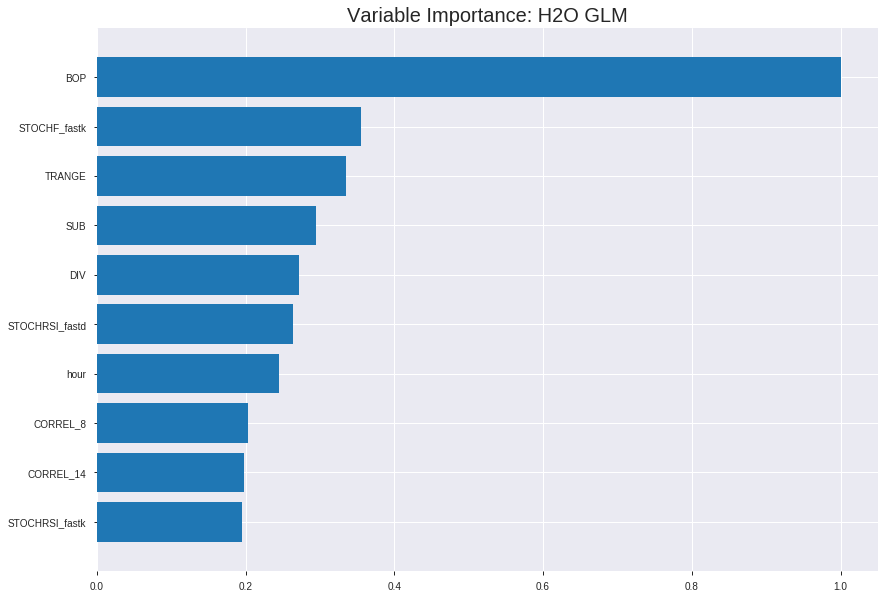

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_165130_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18533413862325404
RMSE: 0.4305045163796241
LogLoss: 0.5498481844100017
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2146.1448765004316
Residual deviance: 1713.3269426215652
AIC: 1815.3269426215652
AUC: 0.794329955179614
pr_auc: 0.7331433230485569
Gini: 0.588659910359228
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40558755412951053: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      547  305  0.358    (305.0/852.0)
1      136  570  0.1926   (136.0/706.0)
Total  683  875  0.2831   (441.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405588     0.721063  219
max f2                       0.205655     0.832528  322
max f0point5                 0.51308      0.707858  168
max accuracy                 0.500217     0.731707  173
max precision                0.960432     1         0
max recall                   0.101176     1         368
max specificity              0.960432     1         0
max absolute_mcc             0.463636     0.46013   188
max min_per_class_accuracy   0.463636     0.728045  188
max mean_per_class_accuracy  0.463636     0.730807  188

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.882093           1.79302   1.79302            0.8125           0.913833   0.8125                      0.913833            0.0184136       0.0184136                  79.3024   79.3024
    2        0.0205392                   0.836375           1.79302   1.79302            0.8125           0.855539   0.8125                      0.884686            0.0184136       0.0368272                  79.3024   79.3024
    3        0.0301669                   0.824026           2.05968   1.87813            0.933333         0.830211   0.851064                    0.8673              0.01983         0.0566572                  105.968   87.8127
    4        0.0404365                   0.813934           1.6551    1.82148            0.75             0.818786   0.825397                    0.854979            0.0169972       0.0736544                  65.5099   82.1485
    5        0.0500642                   0.802646           2.05968   1.86729            0.933333         0.808025   0.846154                    0.84595             0.01983         0.0934844                  105.968   86.7291
    6        0.100128                    0.75097            1.72583   1.79656            0.782051         0.771565   0.814103                    0.808757            0.0864023       0.179887                   72.583    79.6561
    7        0.150193                    0.705157           1.78241   1.79185            0.807692         0.727652   0.811966                    0.781722            0.0892351       0.269122                   78.2414   79.1845
    8        0.200257                    0.668913           1.55608   1.7329             0.705128         0.687448   0.785256                    0.758154            0.0779037       0.347025                   55.6076   73.2903
    9        0.300385                    0.603446           1.61266   1.69282            0.730769         0.635677   0.767094                    0.717328            0.161473        0.508499                   61.2661   69.2822
    10       0.399872                    0.530694           1.30984   1.59754            0.593548         0.569591   0.723917                    0.680572            0.130312        0.63881                    30.9842   59.7538
    11       0.5                         0.450779           1.08925   1.49575            0.49359          0.485943   0.677792                    0.641596            0.109065        0.747875                   8.92533   49.5751
    12       0.600128                    0.379625           0.820477  1.38308            0.371795         0.412157   0.626738                    0.603315            0.082153        0.830028                   -17.9523  38.3085
    13       0.699615                    0.308613           0.683396  1.28359            0.309677         0.343757   0.581651                    0.566406            0.0679887       0.898017                   -31.6604  28.3588
    14       0.799743                    0.239282           0.565846  1.19373            0.25641          0.271019   0.540931                    0.529423            0.0566572       0.954674                   -43.4154  19.3726
    15       0.899872                    0.153261           0.325361  1.0971             0.147436         0.198254   0.497147                    0.492574            0.0325779       0.987252                   -67.4639  9.71033
    16       1                           0.000552464        0.127315  1                  0.0576923        0.0987913  0.453145                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1871459199738241
RMSE: 0.4326036522890486
LogLoss: 0.5564302115095883
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 610.5669311494817
Residual deviance: 496.3357486665527
AIC: 598.3357486665527
AUC: 0.7879962270341206
pr_auc: 0.6988289588695437
Gini: 0.5759924540682413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34421646160293584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      140  114  0.4488   (114.0/254.0)
1      20   172  0.1042   (20.0/192.0)
Total  160  286  0.3004   (134.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344216     0.719665  256
max f2                       0.284817     0.822669  291
max f0point5                 0.651        0.688776  87
max accuracy                 0.427161     0.719731  210
max precision                0.968931     1         0
max recall                   0.0820573    1         385
max specificity              0.968931     1         0
max absolute_mcc             0.359385     0.462073  247
max min_per_class_accuracy   0.458485     0.712598  189
max mean_per_class_accuracy  0.359385     0.72687   247

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 44.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.871922           1.39375   1.39375            0.6              0.923986  0.6                         0.923986            0.015625        0.015625                   39.375    39.375
    2        0.0201794                   0.820835           2.32292   1.80671            1                0.831616  0.777778                    0.882933            0.0208333       0.0364583                  132.292   80.6713
    3        0.0313901                   0.810568           1.39375   1.65923            0.6              0.81712   0.714286                    0.859428            0.015625        0.0520833                  39.375    65.9226
    4        0.0403587                   0.801648           1.74219   1.67766            0.75             0.806937  0.722222                    0.847763            0.015625        0.0677083                  74.2188   67.7662
    5        0.0515695                   0.791801           1.85833   1.71694            0.8              0.796977  0.73913                     0.836723            0.0208333       0.0885417                  85.8333   71.6938
    6        0.100897                    0.742685           1.90057   1.80671            0.818182         0.764962  0.777778                    0.80164             0.09375         0.182292                   90.0568   80.6713
    7        0.150224                    0.704161           2.00616   1.8722             0.863636         0.722141  0.80597                     0.775536            0.0989583       0.28125                    100.616   87.2201
    8        0.201794                    0.667887           2.01993   1.90995            0.869565         0.685395  0.822222                    0.7525              0.104167        0.385417                   101.993   90.9954
    9        0.300448                    0.581496           1.10866   1.64684            0.477273         0.624468  0.708955                    0.710459            0.109375        0.494792                   10.8665   64.6844
    10       0.401345                    0.497597           1.23889   1.54429            0.533333         0.539309  0.664804                    0.667433            0.125           0.619792                   23.8889   54.4285
    11       0.5                         0.442087           1.26705   1.48958            0.545455         0.469045  0.641256                    0.628289            0.125           0.744792                   26.7045   48.9583
    12       0.600897                    0.367229           1.08403   1.42149            0.466667         0.404842  0.61194                     0.59077             0.109375        0.854167                   8.40278   42.1486
    13       0.699552                    0.302042           0.633523  1.31036            0.272727         0.33748   0.564103                    0.55505             0.0625          0.916667                   -36.6477  31.0363
    14       0.800448                    0.223832           0.309722  1.18423            0.133333         0.266451  0.509804                    0.518672            0.03125         0.947917                   -69.0278  18.4232
    15       0.899103                    0.152422           0.263968  1.08326            0.113636         0.187224  0.466334                    0.482303            0.0260417       0.973958                   -73.6032  8.32554
    16       1                           0.00471085         0.258102  1                  0.111111         0.102333  0.430493                    0.443965          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:51:30  0.000 sec   2            21        51            1.36369           1.35483
    2019-08-27 16:51:31  0.043 sec   4            13        51            1.35599           1.34692
    2019-08-27 16:51:31  0.076 sec   6            8         51            1.34461           1.33521
    2019-08-27 16:51:31  0.123 sec   8            4.9       51            1.32848           1.31857
    2019-08-27 16:51:31  0.141 sec   10           3.1       51            1.30698           1.29632
    2019-08-27 16:51:31  0.159 sec   12           1.9       51            1.28037           1.26871
    2019-08-27 16:51:31  0.177 sec   14           1.2       51            1.25028           1.23748
    2019-08-27 16:51:31  0.195 sec   16           0.74      51            1.21911           1.20534
    2019-08-27 16:51:31  0.210 sec   18           0.46      51            1.18939           1.17537
    2019-08-27 16:51:31  0.217 sec   20           0.28      51            1.16297           1.15005
    2019-08-27 16:51:31  0.224 sec   22           0.18      51            1.14076           1.13096
    2019-08-27 16:51:31  0.236 sec   24           0.11      51            1.12298           1.11873
    2019-08-27 16:51:31  0.248 sec   26           0.068     51            1.10943           1.11305
    2019-08-27 16:51:31  0.259 sec   28           0.042     51            1.0997            1.11286
    2019-08-27 16:51:31  0.266 sec   30           0.026     51            1.09319           1.1166
    2019-08-27 16:51:31  0.275 sec   32           0.016     51            1.08917           1.12259
    2019-08-27 16:51:31  0.287 sec   34           0.01      51            1.08684           1.1295
    2019-08-27 16:51:31  0.305 sec   36           0.0063    51            1.08555           1.13649
    2019-08-27 16:51:31  0.317 sec   38           0.0039    51            1.08485           1.14323

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.6907630522088354)

('auc', 0.7774725274725274)

('logloss', 0.5584944891039295)

('mean_per_class_error', 0.28733766233766234)

('rmse', 0.43562137157196057)

('mse', 0.18976597937023612)

glm prediction progress: |████████████████████████████████████████████████| 100%


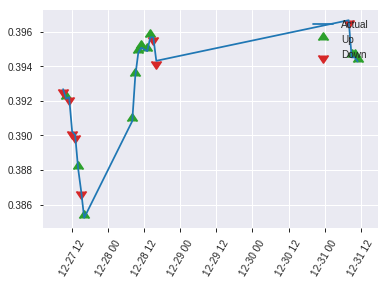


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18976597937023612
RMSE: 0.43562137157196057
LogLoss: 0.5584944891039295
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 303.40375268137996
Residual deviance: 249.08854214035253
AIC: 351.0885421403525
AUC: 0.7774725274725274
pr_auc: 0.6649786432050186
Gini: 0.5549450549450547
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30742097265367385: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   72   0.5455   (72.0/132.0)
1      5    86   0.0549   (5.0/91.0)
Total  65   158  0.3453   (77.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.307421     0.690763  157
max f2                       0.272666     0.825516  168
max f0point5                 0.561932     0.667575  68
max accuracy                 0.561932     0.721973  68
max precision                0.907295     1         0
max recall                   0.18863      1         198
max specificity              0.907295     1         0
max absolute_mcc             0.307421     0.432164  157
max min_per_class_accuracy   0.447833     0.674242  104
max mean_per_class_accuracy  0.368303     0.712662  134

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 44.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.873094           1.6337    1.6337             0.666667         0.886998  0.666667                    0.886998            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.834696           1.22527   1.47033            0.5              0.849583  0.6                         0.872032            0.010989        0.032967                   22.5275   47.033
    3        0.0313901                   0.825019           2.45055   1.75039            1                0.829897  0.714286                    0.859993            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.789015           2.45055   1.90598            1                0.821529  0.777778                    0.851446            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.779753           2.45055   2.04212            1                0.782178  0.833333                    0.834129            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.732791           1.78222   1.91782            0.727273         0.751222  0.782609                    0.794478            0.0879121       0.197802                   78.2218   91.7821
    7        0.152466                    0.682649           1.33666   1.7298             0.545455         0.705109  0.705882                    0.765564            0.0659341       0.263736                   33.6663   72.98
    8        0.201794                    0.649734           2.45055   1.90598            1                0.670529  0.777778                    0.742333            0.120879        0.384615                   145.055   90.5983
    9        0.300448                    0.575563           1.33666   1.71904            0.545455         0.61369   0.701493                    0.700092            0.131868        0.516484                   33.6663   71.9042
    10       0.399103                    0.49373            1.0025    1.54192            0.409091         0.526847  0.629213                    0.657268            0.0989011       0.615385                   0.24975   54.1919
    11       0.502242                    0.417334           1.06546   1.44407            0.434783         0.455979  0.589286                    0.615932            0.10989         0.725275                   6.54563   44.4074
    12       0.600897                    0.368443           1.22527   1.40815            0.5              0.387925  0.574627                    0.578498            0.120879        0.846154                   22.5275   40.8152
    13       0.699552                    0.313145           0.77972   1.31953            0.318182         0.340927  0.538462                    0.544994            0.0769231       0.923077                   -22.028   31.9527
    14       0.798206                    0.2488             0.556943  1.22527            0.227273         0.276812  0.5                         0.511848            0.0549451       0.978022                   -44.3057  22.5275
    15       0.896861                    0.180685           0.222777  1.115              0.0909091        0.217042  0.455                       0.479419            0.021978        1                          -77.7223  11.5
    16       1                           0.021182           0         1                  0                0.122249  0.408072                    0.442581            0    

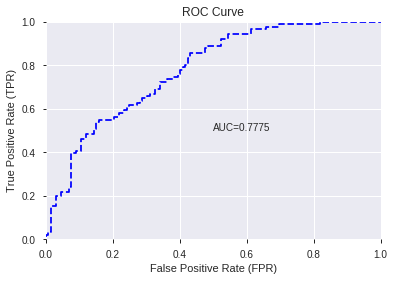

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


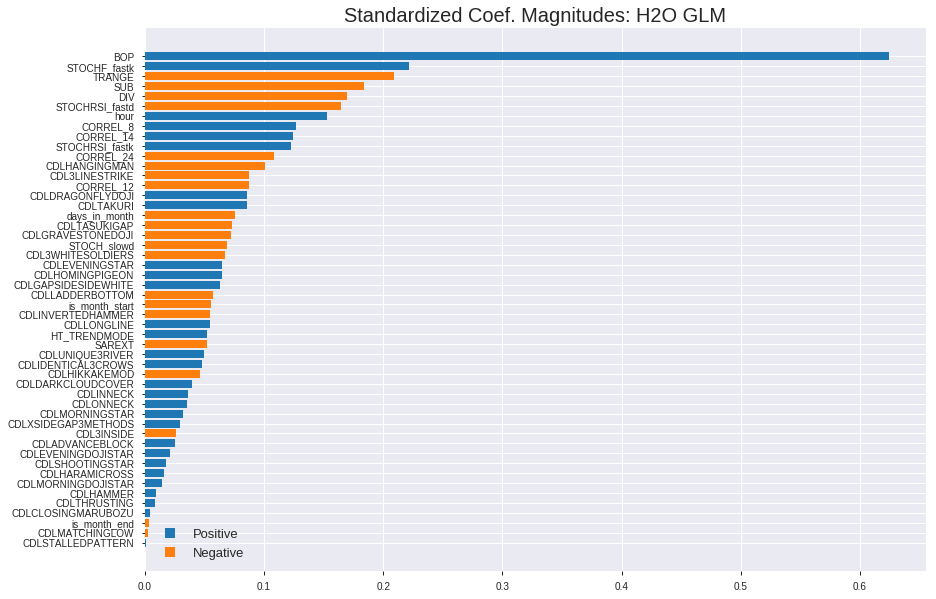

'log_likelihood'
--2019-08-27 16:51:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_165130_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_165130_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'SUB',
 'DIV',
 'STOCHRSI_fastd',
 'hour',
 'CORREL_8',
 'CORREL_14',
 'STOCHRSI_fastk',
 'CORREL_24',
 'CDLHANGINGMAN',
 'CDL3LINESTRIKE',
 'CORREL_12',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'days_in_month',
 'CDLTASUKIGAP',
 'CDLGRAVESTONEDOJI',
 'STOCH_slowd',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGSTAR',
 'CDLHOMINGPIGEON',
 'CDLGAPSIDESIDEWHITE',
 'CDLLADDERBOTTOM',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'SAREXT',
 'CDLUNIQUE3RIVER',
 'CDLIDENTICAL3CROWS',
 'CDLHIKKAKEMOD',
 'CDLDARKCLOUDCOVER',
 'CDLINNECK',
 'CDLONNECK',
 'CDLMORNINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'CDL3INSIDE',
 'CDLADVANCEBLOCK',
 'CDLEVENINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CDLHARAMICROSS',
 'CDLMORNINGDOJISTAR',
 'CDLHAMMER',
 'CDLTHRUSTING',
 'CDLCLOSINGMARUBOZU',
 'is_month_end',
 'CDLMATCHINGLOW',
 'CDLSTALLEDPATTERN']

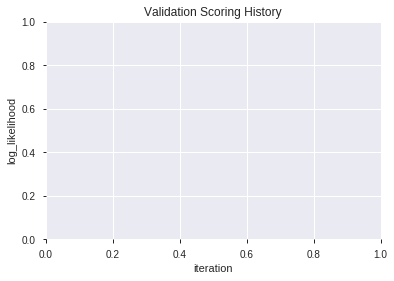

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_165146_model_4  0.773144  0.561713              0.278638  0.436247  0.190312
1  XGBoost_grid_1_AutoML_20190827_165146_model_6  0.770147  0.561828              0.310065  0.436937  0.190914
2  XGBoost_grid_1_AutoML_20190827_165146_model_3  0.769897  0.566079              0.280719  0.437769  0.191641
3               XGBoost_2_AutoML_20190827_165146  0.768898  0.565312              0.292458  0.438859  0.192598
4  XGBoost_grid_1_AutoML_20190827_165146_model_1  0.764236  0.567482              0.285839  0.439329  0.193010
5               XGBoost_1_AutoML_20190827_165146  0.761738  0.574002              0.278263  0.441698  0.195097
6               XGBoost_3_AutoML_20190827_165146  0.761489  0.569345              0.284882  0.439829  0.193450
7  XGBoost_grid_1_AutoML_20190827_165146_model_7  0.758991  0.575056              0.297577  0.442436  0.195750
8  XGBoost_grid_1_AutoML_20190827_165146_model_2  0.756910  0.575440              0.294913  0.442382  0.195702
9  XGBoost_grid_1_AutoML_20190827_165146_model_5  0.745005  0.587404              0.324842  0.447670  0.200408

variable  relative_importance  scaled_importance  percentage
0              BOP          2114.545654           1.000000    0.459748
1           TRANGE           506.601807           0.239580    0.110146
2              DIV           426.333160           0.201619    0.092694
3             hour           284.095856           0.134353    0.061769
4     STOCHF_fastk           227.804855           0.107732    0.049530
5   STOCHRSI_fastk           181.999451           0.086070    0.039571
6   STOCHRSI_fastd           169.922562           0.080359    0.036945
7              SUB           162.615295           0.076903    0.035356
8           SAREXT           144.925812           0.068538    0.031510
9        CORREL_24           118.511833           0.056046    0.025767
10     STOCH_slowd           103.766319           0.049073    0.022561
11       CORREL_14            47.673607           0.022546    0.010365
12       CORREL_12            34.161388           0.016155    0.007427
13   days_in_month            29.685368           0.014039    0.006454
14        CORREL_8            27.199516           0.012863    0.005914
15    HT_TRENDMODE            19.520487           0.009232    0.004244

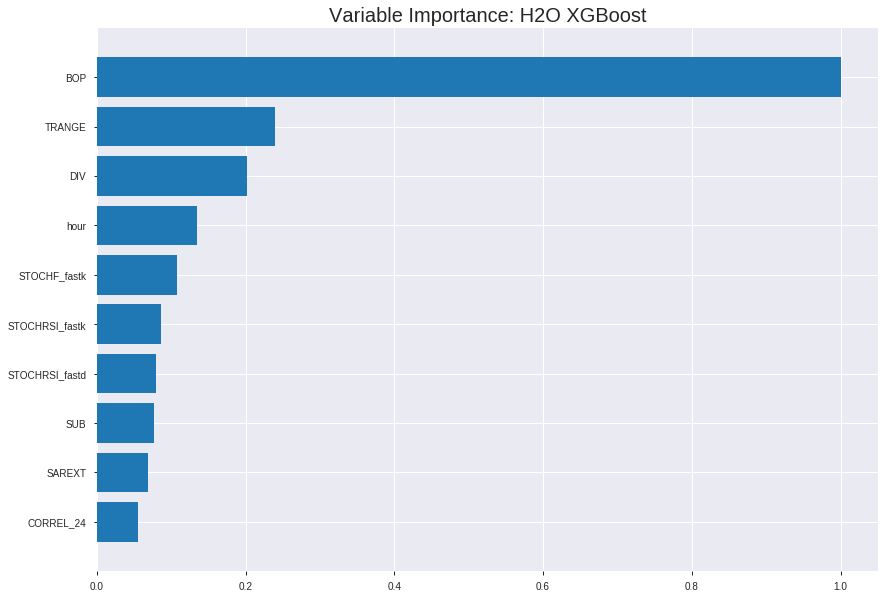

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_165146_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17230758898879153
RMSE: 0.415099492879468
LogLoss: 0.5195118668479043
Mean Per-Class Error: 0.24549967415446416
AUC: 0.8248538682520049
pr_auc: 0.7767635598810273
Gini: 0.6497077365040098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41334256529808044: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      570  282  0.331    (282.0/852.0)
1      117  589  0.1657   (117.0/706.0)
Total  687  871  0.2561   (399.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413343     0.746988  226
max f2                       0.208637     0.844653  322
max f0point5                 0.58155      0.731989  142
max accuracy                 0.488847     0.750321  188
max precision                0.837575     1         0
max recall                   0.0993124    1         385
max specificity              0.837575     1         0
max absolute_mcc             0.440953     0.507535  212
max min_per_class_accuracy   0.488847     0.749292  188
max mean_per_class_accuracy  0.440953     0.7545    212

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.811383           1.93095    1.93095            0.875            0.820878  0.875                       0.820878            0.01983         0.01983                    93.0949   93.0949
    2        0.0205392                   0.801844           2.2068     2.06887            1                0.80736   0.9375                      0.814119            0.0226629       0.0424929                  120.68    106.887
    3        0.0301669                   0.795992           2.05968    2.06594            0.933333         0.799036  0.93617                     0.809305            0.01983         0.0623229                  105.968   106.594
    4        0.0404365                   0.789332           2.06887    2.06668            0.9375           0.793354  0.936508                    0.805254            0.0212465       0.0835694                  106.887   106.668
    5        0.0500642                   0.782466           2.2068     2.09363            1                0.786574  0.948718                    0.801662            0.0212465       0.104816                   120.68    109.363
    6        0.100128                    0.748632           1.69754    1.89558            0.769231         0.764378  0.858974                    0.78302             0.0849858       0.189802                   69.7538   89.5584
    7        0.150193                    0.71754            1.89558    1.89558            0.858974         0.734058  0.858974                    0.766699            0.0949008       0.284703                   89.5584   89.5584
    8        0.200257                    0.692057           1.72583    1.85315            0.782051         0.70389   0.839744                    0.750997            0.0864023       0.371105                   72.583    85.3145
    9        0.300385                    0.632872           1.35803    1.68811            0.615385         0.664163  0.764957                    0.722052            0.135977        0.507082                   35.803    68.8107
    10       0.399872                    0.556328           1.5234     1.64713            0.690323         0.597585  0.746388                    0.691085            0.151558        0.65864                    52.3403   64.7129
    11       0.5                         0.464249           1.15998    1.54958            0.525641         0.510666  0.702182                    0.654955            0.116147        0.774788                   15.9984   54.9575
    12       0.600128                    0.370711           0.848769   1.43265            0.384615         0.420047  0.649198                    0.615762            0.0849858       0.859773                   -15.1231  43.2649
    13       0.699615                    0.276829           0.740345   1.3342             0.335484         0.326795  0.604587                    0.57467             0.0736544       0.933428                   -25.9655  33.4202
    14       0.799743                    0.19503            0.381946   1.21498            0.173077         0.234979  0.550562                    0.532141            0.0382436       0.971671                   -61.8054  21.4979
    15       0.899872                    0.126926           0.226338   1.10497            0.102564         0.160088  0.500713                    0.490743            0.0226629       0.994334                   -77.3662  10.4973
    16       1                           0.0708111          0.0565846  1                  0.025641         0.104663  0.453145                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19283908693488275
RMSE: 0.43913447477382456
LogLoss: 0.5662005106708121
Mean Per-Class Error: 0.29765419947506566
AUC: 0.7700643864829396
pr_auc: 0.6890334144905212
Gini: 0.5401287729658792
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25460416078567505: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  138  0.5433   (138.0/254.0)
1      18   174  0.0938   (18.0/192.0)
Total  134  312  0.3498   (156.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.254604     0.690476  283
max f2                       0.202172     0.81982   310
max f0point5                 0.60493      0.678191  124
max accuracy                 0.60493      0.713004  124
max precision                0.837113     1         0
max recall                   0.10318      1         381
max specificity              0.837113     1         0
max absolute_mcc             0.60493      0.407194  124
max min_per_class_accuracy   0.462622     0.692708  188
max mean_per_class_accuracy  0.411169     0.702346  215

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 43.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.806647           1.85833   1.85833            0.8              0.819454  0.8                         0.819454            0.0208333       0.0208333                  85.8333   85.8333
    2        0.0201794                   0.799134           2.32292   2.06481            1                0.803926  0.888889                    0.812553            0.0208333       0.0416667                  132.292   106.481
    3        0.0313901                   0.788168           1.85833   1.99107            0.8              0.793612  0.857143                    0.805788            0.0208333       0.0625                     85.8333   99.1071
    4        0.0403587                   0.777753           1.74219   1.93576            0.75             0.783575  0.833333                    0.800852            0.015625        0.078125                   74.2188   93.5764
    5        0.0515695                   0.771785           2.32292   2.01993            1                0.774713  0.869565                    0.79517             0.0260417       0.104167                   132.292   101.993
    6        0.100897                    0.739786           1.47822   1.75509            0.636364         0.752588  0.755556                    0.774352            0.0729167       0.177083                   47.822    75.5093
    7        0.150224                    0.710003           1.58381   1.69885            0.681818         0.727536  0.731343                    0.75898             0.078125        0.255208                   58.3807   69.885
    8        0.201794                    0.687733           1.91893   1.75509            0.826087         0.700022  0.755556                    0.743913            0.0989583       0.354167                   91.8931   75.5093
    9        0.300448                    0.614272           1.58381   1.69885            0.681818         0.656933  0.731343                    0.715352            0.15625         0.510417                   58.3807   69.885
    10       0.401345                    0.532782           1.08403   1.54429            0.466667         0.571799  0.664804                    0.679263            0.109375        0.619792                   8.40278   54.4285
    11       0.5                         0.444674           1.00308   1.4375             0.431818         0.47806   0.618834                    0.639564            0.0989583       0.71875                    0.307765  43.75
    12       0.600897                    0.372751           0.980787  1.36081            0.422222         0.406546  0.585821                    0.600438            0.0989583       0.817708                   -1.9213   36.0813
    13       0.699552                    0.254377           0.897491  1.29547            0.386364         0.300128  0.557692                    0.558086            0.0885417       0.90625                    -10.2509  29.5473
    14       0.800448                    0.180762           0.464583  1.19074            0.2              0.211548  0.512605                    0.514405            0.046875        0.953125                   -53.5417  19.0739
    15       0.899103                    0.12399            0.369555  1.10063            0.159091         0.152668  0.473815                    0.474713            0.0364583       0.989583                   -63.0445  10.0634
    16       1                           0.0791953          0.103241  1                  0.0444444        0.103625  0.430493                    0.437272            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:51:55  3.581 sec   0                  0.5              0.693147            0.5             0                  1                0.546855                         0.5                0.693147              0.5               0                    1                  0.569507
    2019-08-27 16:51:56  3.690 sec   5                  0.476288         0.646532            0.787675        0.721193           1.839            0.289474                         0.478523           0.650812              0.757536          0.677757             2.32292            0.374439
    2019-08-27 16:51:56  3.752 sec   10                 0.460692         0.616166            0.792354        0.739158           2.2068           0.302311                         0.464934           0.624139              0.767419          0.711533             2.32292            0.32287
    2019-08-27 16:51:56  3.817 sec   15                 0.449625         0.594146            0.797823        0.746109           2.06887          0.29846                          0.456559           0.607043              0.765697          0.706509             2.32292            0.336323
    2019-08-27 16:51:56  3.883 sec   20                 0.441283         0.577039            0.80093         0.747264           1.94718          0.289474                         0.450617           0.594356              0.766661          0.710064             2.32292            0.331839
    2019-08-27 16:51:56  3.948 sec   25                 0.436042         0.565818            0.804304        0.750579           1.93095          0.284981                         0.446661           0.585492              0.767778          0.709148             2.32292            0.32287
    2019-08-27 16:51:56  4.015 sec   30                 0.431253         0.555492            0.807492        0.754457           1.93095          0.268293                         0.443242           0.577604              0.770741          0.709721             2.32292            0.320628
    2019-08-27 16:51:56  4.109 sec   35                 0.427663         0.547514            0.80943         0.754469           1.93095          0.280488                         0.442062           0.574337              0.769706          0.708785             2.32292            0.316143
    2019-08-27 16:51:56  4.184 sec   40                 0.424805         0.54097             0.812213        0.758578           1.93095          0.270218                         0.440639           0.570593              0.769275          0.704024             2.32292            0.331839
    2019-08-27 16:51:56  4.257 sec   45                 0.422423         0.535642            0.814817        0.760856           1.93095          0.259307                         0.440234           0.569122              0.769203          0.700216             2.32292            0.336323
    2019-08-27 16:51:56  4.332 sec   50                 0.420168         0.530577            0.817461        0.766093           1.93095          0.267009                         0.439779           0.567599              0.768855          0.69578              2.32292            0.318386
    2019-08-27 16:51:56  4.409 sec   55                 0.418502         0.526856            0.819937        0.769307           1.93095          0.258665                         0.439467           0.566821              0.768947          0.6

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
BOP             2114.55                1                    0.459748
TRANGE          506.602                0.23958              0.110146
DIV             426.333                0.201619             0.092694
hour            284.096                0.134353             0.0617685
STOCHF_fastk    227.805                0.107732             0.0495297
STOCHRSI_fastk  181.999                0.0860702            0.0395706
STOCHRSI_fastd  169.923                0.0803589            0.0369448
SUB             162.615                0.0769032            0.035356
SAREXT          144.926                0.0685376            0.03151
CORREL_24       118.512                0.056046             0.025767
STOCH_slowd     103.766                0.0490726            0.022561
CORREL_14       47.6736                0.0225456            0.0103653
CORREL_12       34.1614                0.0161554            0.00742742
days_in_month   29.6854                0.0140387            0.00645423
CORREL_8        27.1995                0.0128631            0.00591376
HT_TRENDMODE    19.5205                0.00923153           0.00424417

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726457399103139)

('F1', 0.6889952153110048)

('auc', 0.7731435231435231)

('logloss', 0.5617126761298058)

('mean_per_class_error', 0.27863802863802867)

('rmse', 0.43624747911609396)

('mse', 0.19031186303514683)

xgboost prediction progress: |████████████████████████████████████████████| 100%


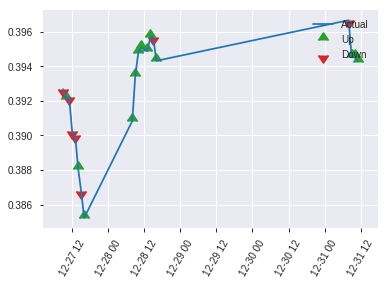


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19031186303514683
RMSE: 0.43624747911609396
LogLoss: 0.5617126761298058
Mean Per-Class Error: 0.27863802863802867
AUC: 0.7731435231435231
pr_auc: 0.6549411734098749
Gini: 0.5462870462870462
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40528303384780884: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      86   46   0.3485   (46.0/132.0)
1      19   72   0.2088   (19.0/91.0)
Total  105  118  0.2915   (65.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405283     0.688995  117
max f2                       0.194742     0.812274  189
max f0point5                 0.55186      0.671835  73
max accuracy                 0.55186      0.726457  73
max precision                0.833675     1         0
max recall                   0.12078      1         212
max specificity              0.833675     1         0
max absolute_mcc             0.405283     0.435918  117
max min_per_class_accuracy   0.444838     0.704545  103
max mean_per_class_accuracy  0.405283     0.721362  117

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 43.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.805548           1.6337    1.6337             0.666667         0.820399  0.666667                    0.820399            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.796887           2.45055   1.96044            1                0.800279  0.8                         0.812351            0.021978        0.043956                   145.055   96.044
    3        0.0313901                   0.778989           2.45055   2.10047            1                0.792389  0.857143                    0.806648            0.021978        0.0659341                  145.055   110.047
    4        0.0403587                   0.763834           0         1.6337             0                0.769262  0.666667                    0.79834             0               0.0659341                  -100      63.37
    5        0.0538117                   0.754843           1.6337    1.6337             0.666667         0.758644  0.666667                    0.788416            0.021978        0.0879121                  63.37     63.37
    6        0.103139                    0.73012            2.22777   1.91782            0.909091         0.743646  0.782609                    0.767004            0.10989         0.197802                   122.777   91.7821
    7        0.152466                    0.684045           1.33666   1.7298             0.545455         0.710817  0.705882                    0.748826            0.0659341       0.263736                   33.6663   72.98
    8        0.201794                    0.659442           1.78222   1.74261            0.727273         0.669811  0.711111                    0.729511            0.0879121       0.351648                   78.2218   74.2613
    9        0.300448                    0.57908            1.67083   1.71904            0.681818         0.61982   0.701493                    0.693493            0.164835        0.516484                   67.0829   71.9042
    10       0.399103                    0.501338           1.11389   1.56945            0.454545         0.53986   0.640449                    0.655516            0.10989         0.626374                   11.3886   56.9453
    11       0.502242                    0.422047           1.27855   1.50971            0.521739         0.456646  0.616071                    0.614677            0.131868        0.758242                   27.8548   50.9714
    12       0.600897                    0.356954           0.77972   1.38986            0.318182         0.387357  0.567164                    0.577356            0.0769231       0.835165                   -22.028   38.9864
    13       0.699552                    0.284176           0.556943  1.2724             0.227273         0.317654  0.519231                    0.540731            0.0549451       0.89011                    -44.3057  27.2401
    14       0.798206                    0.218523           0.668332  1.19774            0.272727         0.251943  0.488764                    0.505038            0.0659341       0.956044                   -33.1668  19.774
    15       0.896861                    0.160208           0.334166  1.10275            0.136364         0.194255  0.45                        0.470852            0.032967        0.989011                   -66.5834  10.2747
    16       1                           0.0830277          0.106546  1                  0.0434783        0.12215   0.408072                    0.434887            0.01098

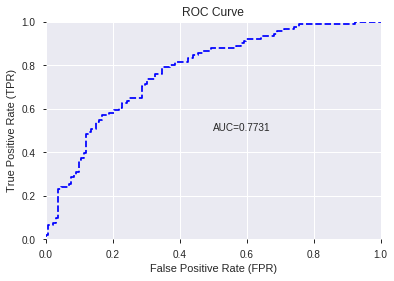

This function is available for GLM models only


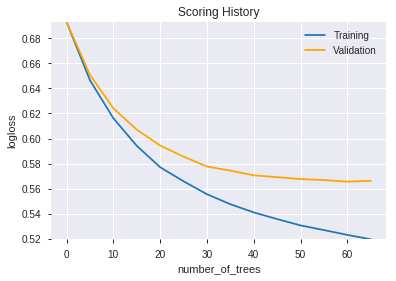

--2019-08-27 16:52:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_165146_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_165146_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'DIV',
 'hour',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'SUB',
 'SAREXT',
 'CORREL_24',
 'STOCH_slowd',
 'CORREL_14',
 'CORREL_12',
 'days_in_month',
 'CORREL_8',
 'HT_TRENDMODE']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_165215_model_1  0.760406  0.574677              0.292458  0.444155  0.197274

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.436879           1.000000  4.032838e-02
1                       TRANGE             0.191818           0.439065  1.770680e-02
2                          DIV             0.191767           0.438949  1.770209e-02
3                          SUB             0.187166           0.428416  1.727734e-02
4                 STOCHF_fastk             0.149945           0.343219  1.384145e-02
...                        ...                  ...                ...           ...
1032   BBANDS_lowerband_20_2_3             0.000020           0.000046  1.872077e-06
1033                    SUM_12             0.000014           0.000032  1.285440e-06
1034                   MA_30_5             0.000011           0.000026  1.039315e-06
1035    BBANDS_upperband_8_2_4             0.000011           0.000024  9.749291e-07
1036  BBANDS_middleband_30_5_2             0.000010           0.000023  9.368449e-07

[1037 rows x 4 columns]

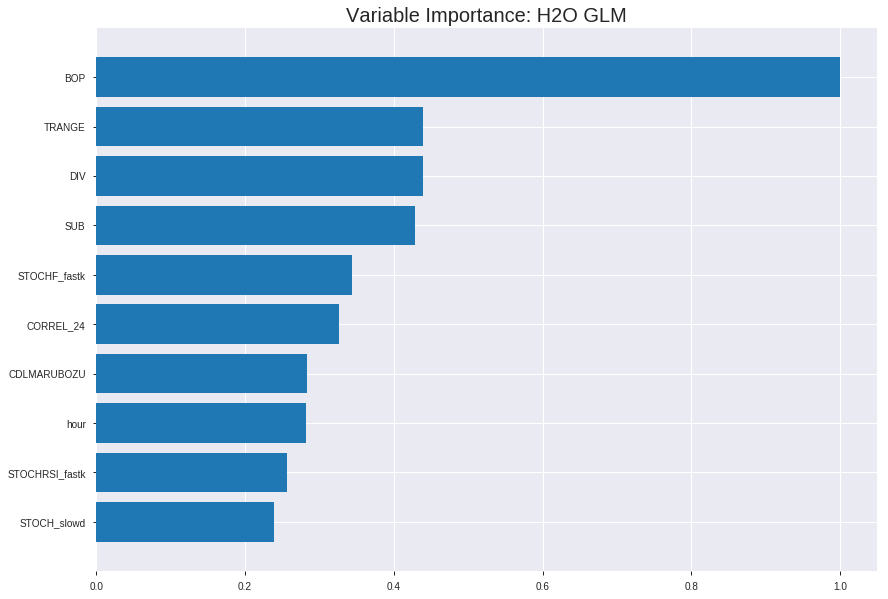

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_165215_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17604597943701342
RMSE: 0.4195783352808071
LogLoss: 0.5277728176729116
Null degrees of freedom: 1557
Residual degrees of freedom: 520
Null deviance: 2146.1448765004316
Residual deviance: 1644.5400998687926
AIC: 3720.540099868793
AUC: 0.8175747117264494
pr_auc: 0.7614743613550614
Gini: 0.6351494234528987
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4437544872310133: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      601  251  0.2946   (251.0/852.0)
1      144  562  0.204    (144.0/706.0)
Total  745  813  0.2535   (395.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443754     0.739961  208
max f2                       0.217947     0.843123  314
max f0point5                 0.509052     0.724423  176
max accuracy                 0.474411     0.749037  193
max precision                0.96087      1         0
max recall                   0.0801627    1         378
max specificity              0.96087      1         0
max absolute_mcc             0.455614     0.500519  201
max min_per_class_accuracy   0.474411     0.746459  193
max mean_per_class_accuracy  0.455614     0.751365  201

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.868163           1.79302    1.79302            0.8125           0.902137   0.8125                      0.902137            0.0184136       0.0184136                  79.3024   79.3024
    2        0.0205392                   0.845425           2.06887    1.93095            0.9375           0.855797   0.875                       0.878967            0.0212465       0.0396601                  106.887   93.0949
    3        0.0301669                   0.827546           2.05968    1.97203            0.933333         0.836218   0.893617                    0.865323            0.01983         0.0594901                  105.968   97.2033
    4        0.0404365                   0.814395           2.06887    1.99663            0.9375           0.820202   0.904762                    0.853864            0.0212465       0.0807365                  106.887   99.6628
    5        0.0500642                   0.804617           1.61832    1.92388            0.733333         0.808987   0.871795                    0.845234            0.0155807       0.0963173                  61.8319   92.3876
    6        0.100128                    0.75283            1.89558    1.90973            0.858974         0.779579   0.865385                    0.812407            0.0949008       0.191218                   89.5584   90.973
    7        0.150193                    0.710736           1.69754    1.839              0.769231         0.731068   0.833333                    0.785294            0.0849858       0.276204                   69.7538   83.8999
    8        0.200257                    0.672381           1.78241    1.82485            0.807692         0.692076   0.826923                    0.761989            0.0892351       0.365439                   78.2414   82.4853
    9        0.300385                    0.610167           1.55608    1.73526            0.705128         0.644821   0.786325                    0.722933            0.155807        0.521246                   55.6076   73.5261
    10       0.399872                    0.53016            1.30984    1.62942            0.593548         0.569433   0.738363                    0.684743            0.130312        0.651558                   30.9842   62.9418
    11       0.5                         0.455604           1.21657    1.54674            0.551282         0.492759   0.700899                    0.646297            0.121813        0.773371                   21.6569   54.6742
    12       0.600128                    0.377991           0.80633    1.42321            0.365385         0.418463   0.64492                     0.608284            0.0807365       0.854108                   -19.367   42.3208
    13       0.699615                    0.302318           0.597971   1.30586            0.270968         0.340295   0.591743                    0.570175            0.0594901       0.913598                   -40.2029  30.5858
    14       0.799743                    0.226059           0.509261   1.20612            0.230769         0.263922   0.546549                    0.531832            0.0509915       0.964589                   -49.0739  20.6124
    15       0.899872                    0.142816           0.268777   1.10183            0.121795         0.186116   0.499287                    0.493365            0.0269122       0.991501                   -73.1223  10.1825
    16       1                           0.000986604        0.0848769  1                  0.0384615        0.0916859  0.453145  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18956739402358927
RMSE: 0.4353933784792659
LogLoss: 0.5611751137371702
Null degrees of freedom: 445
Residual degrees of freedom: -592
Null deviance: 610.5669311494817
Residual deviance: 500.56820145355584
AIC: 2576.568201453556
AUC: 0.7895136154855643
pr_auc: 0.7030146356818568
Gini: 0.5790272309711286
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4154389009991263: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      150  104  0.4094   (104.0/254.0)
1      29   163  0.151    (29.0/192.0)
Total  179  267  0.2982   (133.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415439     0.71024   236
max f2                       0.222555     0.818891  342
max f0point5                 0.660252     0.71733   115
max accuracy                 0.660252     0.735426  115
max precision                0.968227     1         0
max recall                   0.143147     1         377
max specificity              0.968227     1         0
max absolute_mcc             0.660252     0.459443  115
max min_per_class_accuracy   0.522474     0.700787  185
max mean_per_class_accuracy  0.459079     0.723179  221

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 49.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.889815           1.39375   1.39375            0.6              0.937702  0.6                         0.937702            0.015625        0.015625                   39.375    39.375
    2        0.0201794                   0.850266           2.32292   1.80671            1                0.871424  0.777778                    0.908245            0.0208333       0.0364583                  132.292   80.6713
    3        0.0313901                   0.842655           1.85833   1.82515            0.8              0.845164  0.785714                    0.885716            0.0208333       0.0572917                  85.8333   82.5149
    4        0.0403587                   0.832977           1.16146   1.67766            0.5              0.837503  0.722222                    0.875002            0.0104167       0.0677083                  16.1458   67.7662
    5        0.0515695                   0.822988           1.85833   1.71694            0.8              0.827999  0.73913                     0.864784            0.0208333       0.0885417                  85.8333   71.6938
    6        0.100897                    0.7818             2.11174   1.90995            0.909091         0.800789  0.822222                    0.833497            0.104167        0.192708                   111.174   90.9954
    7        0.150224                    0.751799           1.68939   1.83753            0.727273         0.767828  0.791045                    0.811934            0.0833333       0.276042                   68.9394   83.7531
    8        0.201794                    0.718419           2.01993   1.88414            0.869565         0.737721  0.811111                    0.792969            0.104167        0.380208                   101.993   88.4144
    9        0.300448                    0.647049           1.6366    1.80286            0.704545         0.68335   0.776119                    0.756974            0.161458        0.541667                   63.66     80.2861
    10       0.401345                    0.572333           0.877546  1.57024            0.377778         0.603828  0.675978                    0.718474            0.0885417       0.630208                   -12.2454  57.024
    11       0.5                         0.50254            1.10866   1.47917            0.477273         0.53518   0.636771                    0.682308            0.109375        0.739583                   10.8665   47.9167
    12       0.600897                    0.415059           1.08403   1.41282            0.466667         0.463345  0.608209                    0.645542            0.109375        0.848958                   8.40278   41.2819
    13       0.699552                    0.358341           0.580729  1.29547            0.25             0.382231  0.557692                    0.608408            0.0572917       0.90625                    -41.9271  29.5473
    14       0.800448                    0.281212           0.464583  1.19074            0.2              0.319435  0.512605                    0.571983            0.046875        0.953125                   -53.5417  19.0739
    15       0.899103                    0.19284            0.316761  1.09484            0.136364         0.231725  0.471322                    0.534648            0.03125         0.984375                   -68.3239  9.4841
    16       1                           0.00287389         0.154861  1                  0.0666667        0.115214  0.430493                    0.492329            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 16:52:18  0.000 sec   2            .21E2     1038          1.351295173994024   1.3490525553243755
     2019-08-27 16:52:20  1.964 sec   4            .15E2     1038          1.3442822826800283  1.3425257652799627
     2019-08-27 16:52:22  3.931 sec   6            .11E2     1038          1.3356006899317712  1.3342954786259178
     2019-08-27 16:52:24  5.945 sec   8            .8E1      1038          1.3249588709392142  1.3239719129744965
     2019-08-27 16:52:26  7.960 sec   10           .58E1     1038          1.3121197290084499  1.3113516621893437
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 16:52:57  38.501 sec  40           .49E-1    1038          1.0447865660851643  1.1242472709507891
     2019-08-27 16:52:59  40.534 sec  42           .36E-1    1038          1.0354997696562822  1.1280273646689656
     2019-08-27 16:53:01  42.535 sec  44           .26E-1    1038          1.0274282708204614  1.1333150487774808
     2019-08-27 16:53:03  44.547 sec  46           .19E-1    1038          1.0203867083733107  1.1398975527096296
     2019-08-27 16:53:05  46.680 sec  48           .14E-1    1038          1.014107968909231   1.1475335514423135


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7040358744394619)

('F1', 0.6818181818181819)

('auc', 0.7604062604062605)

('logloss', 0.5746770524122329)

('mean_per_class_error', 0.290001665001665)

('rmse', 0.44415541561924343)

('mse', 0.19727403322390286)

glm prediction progress: |████████████████████████████████████████████████| 100%


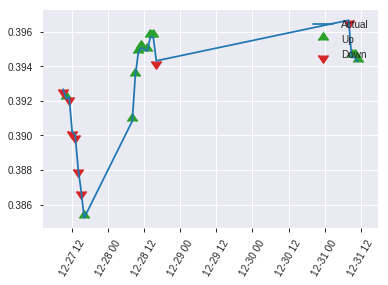


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19727403322390286
RMSE: 0.44415541561924343
LogLoss: 0.5746770524122329
Null degrees of freedom: 222
Residual degrees of freedom: -815
Null deviance: 303.40375268137996
Residual deviance: 256.3059653758559
AIC: 2332.305965375856
AUC: 0.7604062604062605
pr_auc: 0.6423080138741989
Gini: 0.5208125208125209
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38796823181421536: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   54   0.4091   (54.0/132.0)
1      16   75   0.1758   (16.0/91.0)
Total  94   129  0.3139   (70.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387968     0.681818  128
max f2                       0.23333      0.822669  182
max f0point5                 0.561681     0.638821  78
max accuracy                 0.561681     0.704036  78
max precision                0.897464     1         0
max recall                   0.168527     1         203
max specificity              0.897464     1         0
max absolute_mcc             0.415347     0.414344  120
max min_per_class_accuracy   0.464122     0.67033   103
max mean_per_class_accuracy  0.415347     0.709998  120

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 45.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.858728           2.45055   2.45055            1                0.879236  1                           0.879236            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.839275           2.45055   2.45055            1                0.847134  1                           0.866396            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.825087           1.22527   2.10047            0.5              0.829677  0.857143                    0.855905            0.010989        0.0659341                  22.5275   110.047
    4        0.0403587                   0.805496           2.45055   2.17827            1                0.820557  0.888889                    0.84805             0.021978        0.0879121                  145.055   117.827
    5        0.0538117                   0.791375           0         1.6337             0                0.798277  0.666667                    0.835606            0               0.0879121                  -100      63.37
    6        0.103139                    0.746584           1.78222   1.70473            0.727273         0.769646  0.695652                    0.80406             0.0879121       0.175824                   78.2218   70.473
    7        0.152466                    0.703054           1.78222   1.7298             0.727273         0.722059  0.705882                    0.777531            0.0879121       0.263736                   78.2218   72.98
    8        0.201794                    0.679477           1.33666   1.6337             0.545455         0.689172  0.666667                    0.755932            0.0659341       0.32967                    33.6663   63.37
    9        0.300448                    0.596183           1.67083   1.64589            0.681818         0.634161  0.671642                    0.715947            0.164835        0.494505                   67.0829   64.5891
    10       0.399103                    0.517425           1.0025    1.48685            0.409091         0.563422  0.606742                    0.678244            0.0989011       0.593407                   0.24975   48.685
    11       0.502242                    0.433512           1.27855   1.44407            0.521739         0.476092  0.589286                    0.636731            0.131868        0.725275                   27.8548   44.4074
    12       0.600897                    0.381766           1.11389   1.38986            0.454545         0.409272  0.567164                    0.599387            0.10989         0.835165                   11.3886   38.9864
    13       0.699552                    0.307789           0.77972   1.30382            0.318182         0.352409  0.532051                    0.564557            0.0769231       0.912088                   -22.028   30.3818
    14       0.798206                    0.249332           0.668332  1.22527            0.272727         0.284318  0.5                         0.52992             0.0659341       0.978022                   -33.1668  22.5275
    15       0.896861                    0.182506           0.111389  1.10275            0.0454545        0.216597  0.45                        0.495455            0.010989        0.989011                   -88.8611  10.2747
    16       1                           0.00878364         0.106546  1                  0.0434783        0.121703  0.408072                    0.456906            0.010

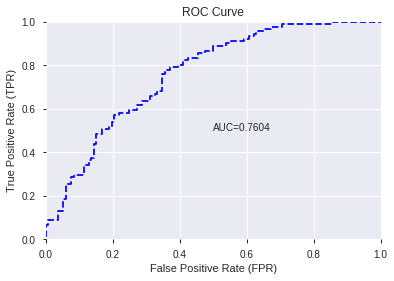

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


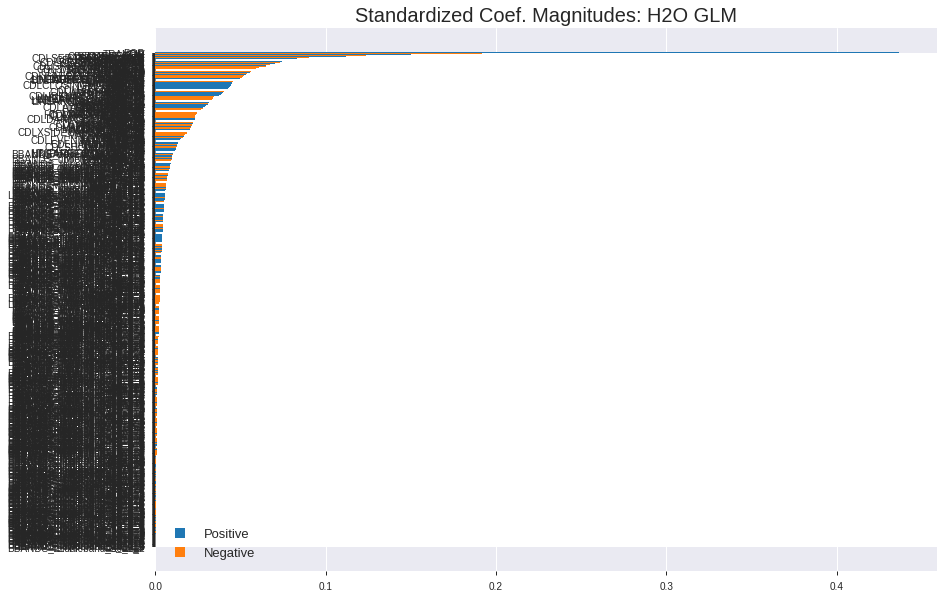

'log_likelihood'
--2019-08-27 16:53:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_165215_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_165215_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

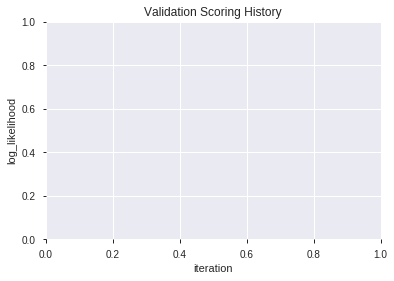

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_165335_model_4  0.776723  0.561612              0.293207  0.435940  0.190044
1  XGBoost_grid_1_AutoML_20190827_165335_model_1  0.771895  0.565324              0.309108  0.438980  0.192703
2               XGBoost_3_AutoML_20190827_165335  0.757326  0.585072              0.311772  0.447465  0.200225
3               XGBoost_2_AutoML_20190827_165335  0.756077  0.586034              0.319139  0.447520  0.200274
4  XGBoost_grid_1_AutoML_20190827_165335_model_7  0.753413  0.576374              0.344530  0.444167  0.197284
5  XGBoost_grid_1_AutoML_20190827_165335_model_2  0.747669  0.607494              0.306485  0.457079  0.208921
6  XGBoost_grid_1_AutoML_20190827_165335_model_6  0.747419  0.605163              0.288503  0.457081  0.208923
7               XGBoost_1_AutoML_20190827_165335  0.741675  0.595771              0.296620  0.452983  0.205194
8  XGBoost_grid_1_AutoML_20190827_165335_model_3  0.732434  0.602560              0.304196  0.456155  0.208078
9  XGBoost_grid_1_AutoML_20190827_165335_model_5  0.718282  0.628113              0.343407  0.469285  0.220229

variable  relative_importance  scaled_importance  percentage
0                        BOP          2031.445557           1.000000    0.336248
1                        DIV           441.620300           0.217392    0.073098
2                     TRANGE           424.777313           0.209101    0.070310
3                       hour           199.512405           0.098212    0.033024
4               STOCHF_fastk           164.929611           0.081188    0.027299
..                       ...                  ...                ...         ...
131  BBANDS_lowerband_20_3_4             4.667130           0.002297    0.000773
132              MINUS_DM_14             4.627050           0.002278    0.000766
133             aroondown_30             4.613797           0.002271    0.000764
134             aroondown_12             4.600008           0.002264    0.000761
135                   ADXR_8             3.358911           0.001653    0.000556

[136 rows x 4 columns]

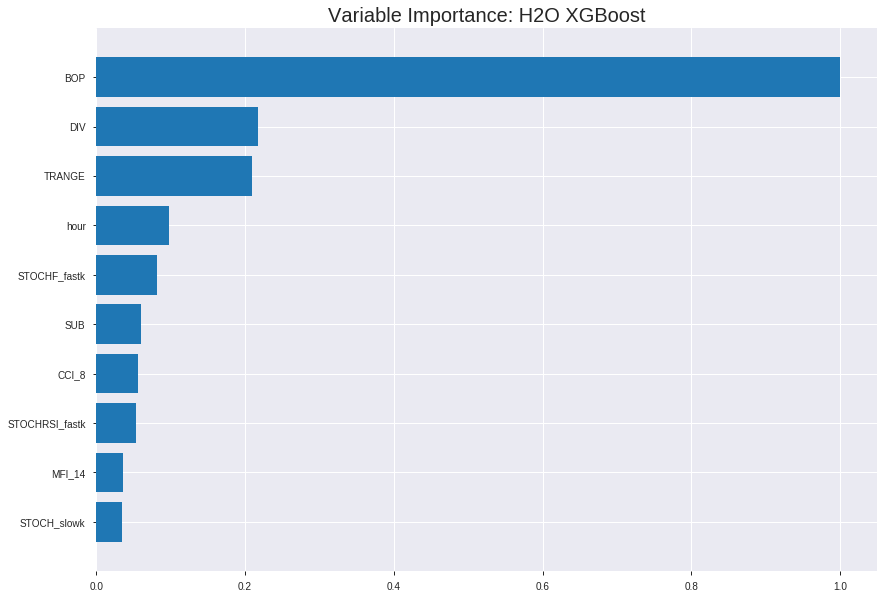

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_165335_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15609912506468504
RMSE: 0.3950938180542503
LogLoss: 0.48198021846237155
Mean Per-Class Error: 0.21965979066086794
AUC: 0.866398342842703
pr_auc: 0.842489194002032
Gini: 0.732796685685406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42316655814647675: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      602  250  0.2934   (250.0/852.0)
1      103  603  0.1459   (103.0/706.0)
Total  705  853  0.2266   (353.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423167     0.773573  218
max f2                       0.291017     0.861318  280
max f0point5                 0.637005     0.772834  110
max accuracy                 0.524167     0.782413  168
max precision                0.857223     1         0
max recall                   0.125796     1         366
max specificity              0.857223     1         0
max absolute_mcc             0.423167     0.560749  218
max min_per_class_accuracy   0.48959      0.776204  185
max mean_per_class_accuracy  0.423167     0.78034   218

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.28 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.828673           2.2068     2.2068             1                0.839024  1                           0.839024            0.0226629       0.0226629                  120.68    120.68
    2        0.0205392                   0.81325            2.2068     2.2068             1                0.818281  1                           0.828652            0.0226629       0.0453258                  120.68    120.68
    3        0.0301669                   0.804723           2.2068     2.2068             1                0.810123  1                           0.822739            0.0212465       0.0665722                  120.68    120.68
    4        0.0404365                   0.796902           2.2068     2.2068             1                0.800512  1                           0.817094            0.0226629       0.0892351                  120.68    120.68
    5        0.0500642                   0.789746           2.2068     2.2068             1                0.793054  1                           0.812471            0.0212465       0.110482                   120.68    120.68
    6        0.100128                    0.751673           1.98046    2.09363            0.897436         0.770858  0.948718                    0.791665            0.0991501       0.209632                   98.0461   109.363
    7        0.150193                    0.723605           1.95217    2.04648            0.884615         0.736349  0.92735                     0.773226            0.0977337       0.307365                   95.2168   104.648
    8        0.200257                    0.696074           1.86729    2.00168            0.846154         0.707656  0.907051                    0.756834            0.0934844       0.40085                    86.7291   100.168
    9        0.300385                    0.634505           1.62681    1.87672            0.737179         0.664713  0.850427                    0.726127            0.16289         0.563739                   62.6807   87.6722
    10       0.399872                    0.55602            1.30984    1.73568            0.593548         0.596479  0.786517                    0.693871            0.130312        0.694051                   30.9842   73.5685
    11       0.5                         0.464948           1.03267    1.5949             0.467949         0.509573  0.722721                    0.656964            0.103399        0.79745                    3.26687   59.4901
    12       0.600128                    0.372137           0.862915   1.47277            0.391026         0.420236  0.66738                     0.617467            0.0864023       0.883853                   -13.7085  47.2773
    13       0.699615                    0.281592           0.711871   1.36457            0.322581         0.328562  0.618349                    0.576384            0.0708215       0.954674                   -28.8129  36.4571
    14       0.799743                    0.18879            0.297069   1.23092            0.134615         0.230104  0.557785                    0.53303             0.029745        0.984419                   -70.2931  23.0919
    15       0.899872                    0.131024           0.141461   1.1097             0.0641026        0.159816  0.502853                    0.491502            0.0141643       0.998584                   -85.8539  10.9696
    16       1                           0.0510313          0.0141461  1                  0.00641026       0.105235  0.453145                    0.45



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18739563712387242
RMSE: 0.4328921772495692
LogLoss: 0.5541425735828336
Mean Per-Class Error: 0.27714895013123364
AUC: 0.7858124179790026
pr_auc: 0.7182117099904427
Gini: 0.5716248359580052
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3285621106624603: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      137  117  0.4606   (117.0/254.0)
1      24   168  0.125    (24.0/192.0)
Total  161  285  0.3161   (141.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.328562     0.704403  253
max f2                       0.232187     0.815956  301
max f0point5                 0.607765     0.684211  123
max accuracy                 0.47268      0.721973  183
max precision                0.871379     1         0
max recall                   0.118404     1         377
max specificity              0.871379     1         0
max absolute_mcc             0.463835     0.441913  187
max min_per_class_accuracy   0.47268      0.71875   183
max mean_per_class_accuracy  0.463835     0.722851  187

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 44.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.811151           2.32292   2.32292            1                0.835039  1                           0.835039            0.0260417       0.0260417                  132.292   132.292
    2        0.0201794                   0.79958            2.32292   2.32292            1                0.806019  1                           0.822141            0.0208333       0.046875                   132.292   132.292
    3        0.0313901                   0.794594           2.32292   2.32292            1                0.7971    1                           0.813198            0.0260417       0.0729167                  132.292   132.292
    4        0.0403587                   0.78759            1.16146   2.06481            0.5              0.790165  0.888889                    0.80808             0.0104167       0.0833333                  16.1458   106.481
    5        0.0515695                   0.778697           1.39375   1.91893            0.6              0.78289   0.826087                    0.802603            0.015625        0.0989583                  39.375    91.8931
    6        0.100897                    0.749521           1.79498   1.85833            0.772727         0.761822  0.8                         0.782666            0.0885417       0.1875                     79.4981   85.8333
    7        0.150224                    0.708968           1.90057   1.8722             0.818182         0.727198  0.80597                     0.764453            0.09375         0.28125                    90.0568   87.2201
    8        0.201794                    0.694335           2.01993   1.90995            0.869565         0.701133  0.822222                    0.748271            0.104167        0.385417                   101.993   90.9954
    9        0.300448                    0.614695           1.21425   1.68151            0.522727         0.650886  0.723881                    0.716294            0.119792        0.505208                   21.4252   68.1514
    10       0.401345                    0.53834            1.08403   1.53131            0.466667         0.577805  0.659218                    0.681478            0.109375        0.614583                   8.40278   53.1308
    11       0.5                         0.452481           1.37263   1.5                0.590909         0.488599  0.64574                     0.643421            0.135417        0.75                       37.2633   50
    12       0.600897                    0.375442           0.774306  1.37815            0.333333         0.419104  0.593284                    0.605756            0.078125        0.828125                   -22.5694  37.8148
    13       0.699552                    0.258304           0.844697  1.30292            0.363636         0.313867  0.560897                    0.564592            0.0833333       0.911458                   -15.5303  30.2918
    14       0.800448                    0.20403            0.361343  1.18423            0.155556         0.23098   0.509804                    0.52254             0.0364583       0.947917                   -63.8657  18.4232
    15       0.899103                    0.14968            0.422348  1.10063            0.181818         0.179686  0.473815                    0.48492             0.0416667       0.989583                   -57.7652  10.0634
    16       1                           0.0607234          0.103241  1                  0.0444444        0.112174  0.430493                    0.447311            0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:54:11  15.923 sec  0                  0.5              0.693147            0.5             0                  1                0.546855                         0.5                0.693147              0.5               0                    1                  0.569507
    2019-08-27 16:54:13  17.135 sec  5                  0.475471         0.644952            0.799672        0.735947           2.2068           0.290116                         0.479761           0.653225              0.750513          0.660584             1.93576            0.331839
    2019-08-27 16:54:13  17.488 sec  10                 0.458012         0.611092            0.813515        0.771107           2.06887          0.27792                          0.466298           0.626892              0.767112          0.707754             2.32292            0.320628
    2019-08-27 16:54:13  17.859 sec  15                 0.446231         0.587806            0.819955        0.786671           2.2068           0.275995                         0.457936           0.609932              0.765615          0.705891             2.32292            0.307175
    2019-08-27 16:54:14  18.215 sec  20                 0.43661          0.56836             0.825693        0.79474            2.2068           0.272144                         0.451902           0.597129              0.76704           0.710269             2.32292            0.329596
    2019-08-27 16:54:14  18.581 sec  25                 0.430012         0.554807            0.830254        0.800823           2.2068           0.270218                         0.447297           0.587426              0.76908           0.706396             2.32292            0.318386
    2019-08-27 16:54:14  18.947 sec  30                 0.4242           0.542682            0.833597        0.804663           2.2068           0.277279                         0.443577           0.579295              0.772761          0.706319             2.32292            0.300448
    2019-08-27 16:54:15  19.300 sec  35                 0.419172         0.532024            0.83747         0.807659           2.2068           0.256098                         0.441032           0.573465              0.775601          0.71038              2.32292            0.293722
    2019-08-27 16:54:15  19.659 sec  40                 0.415469         0.524005            0.840957        0.811685           2.2068           0.249679                         0.439362           0.569459              0.776093          0.708257             2.32292            0.298206
    2019-08-27 16:54:15  20.024 sec  45                 0.411669         0.516023            0.844903        0.816101           2.2068           0.245828                         0.437746           0.565678              0.777498          0.710297             2.32292            0.300448
    2019-08-27 16:54:16  20.387 sec  50                 0.408414         0.50902             0.848274        0.81987            2.2068           0.249679                         0.43632            0.562036              0.778851          0.70894              2.32292            0.300448
    2019-08-27 16:54:16  20.748 sec  55                 0.405798         0.503411            0.851306        0.821931           2.2068           0.244544                         0.435423           0.55983               0.781271          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      2031.445556640625      1.0                    0.336248072154306
DIV                      441.62030029296875     0.21739214169405086    0.07309768854612034
TRANGE                   424.7773132324219      0.20910100782364582    0.07030981076622338
hour                     199.5124053955078      0.09821203661762852    0.0330236079750257
STOCHF_fastk             164.9296112060547      0.08118829996054466    0.027299409343218665
---                      ---                    ---                    ---
BBANDS_lowerband_20_3_4  4.6671295166015625     0.0022974425779441186  0.0007725106377189289
MINUS_DM_14              4.627050399780273      0.0022777132198570785  0.0007658766790973197
aroondown_30             4.613796710968018      0.0022711889550206766  0.0007636829076238553
aroondown_12             4.600008010864258      0.00226440132536519    0.0007614005802377007
ADXR_8                   3.3589112758636475     0.0016534586737427682  0.0005559722914328215


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.6869565217391305)

('auc', 0.7767232767232767)

('logloss', 0.5616119506053789)

('mean_per_class_error', 0.28658841158841164)

('rmse', 0.4359403971788206)

('mse', 0.19004402989242786)

xgboost prediction progress: |████████████████████████████████████████████| 100%


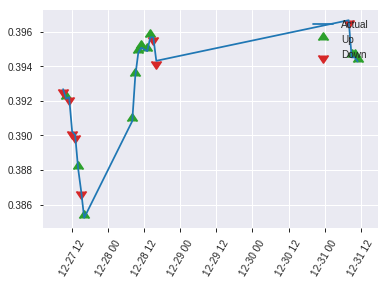


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19004402989242786
RMSE: 0.4359403971788206
LogLoss: 0.5616119506053789
Mean Per-Class Error: 0.28658841158841164
AUC: 0.7767232767232767
pr_auc: 0.6882999087650127
Gini: 0.5534465534465534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3403362035751343: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   60   0.4545   (60.0/132.0)
1      12   79   0.1319   (12.0/91.0)
Total  84   139  0.3229   (72.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340336     0.686957  138
max f2                       0.205165     0.806159  187
max f0point5                 0.554487     0.677749  74
max accuracy                 0.554487     0.730942  74
max precision                0.81104      1         0
max recall                   0.143652     1         210
max specificity              0.81104      1         0
max absolute_mcc             0.543497     0.433281  76
max min_per_class_accuracy   0.441466     0.692308  102
max mean_per_class_accuracy  0.382959     0.713412  124

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 43.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.789272           2.45055   2.45055            1                0.796975  1                           0.796975            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.784051           2.45055   2.45055            1                0.7879    1                           0.793345            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.778119           2.45055   2.45055            1                0.779677  1                           0.78944             0.021978        0.0769231                  145.055   145.055
    4        0.0403587                   0.771022           2.45055   2.45055            1                0.775896  1                           0.78643             0.021978        0.0989011                  145.055   145.055
    5        0.0538117                   0.762744           1.6337    2.24634            0.666667         0.766045  0.916667                    0.781334            0.021978        0.120879                   63.37     124.634
    6        0.103139                    0.710501           1.33666   1.81128            0.545455         0.744361  0.73913                     0.763651            0.0659341       0.186813                   33.6663   81.1276
    7        0.152466                    0.680568           2.005     1.87395            0.818182         0.69233   0.764706                    0.740577            0.0989011       0.285714                   100.5     87.395
    8        0.201794                    0.649822           1.55944   1.79707            0.636364         0.666516  0.733333                    0.722473            0.0769231       0.362637                   55.9441   79.707
    9        0.300448                    0.570282           1.55944   1.71904            0.636364         0.610878  0.701493                    0.68583             0.153846        0.516484                   55.9441   71.9042
    10       0.399103                    0.495741           1.22527   1.59699            0.5              0.53855   0.651685                    0.649424            0.120879        0.637363                   22.5275   59.6987
    11       0.502242                    0.425543           0.958911  1.46595            0.391304         0.455544  0.598214                    0.609609            0.0989011       0.736264                   -4.10893  46.5954
    12       0.600897                    0.359279           1.0025    1.38986            0.409091         0.387511  0.567164                    0.573145            0.0989011       0.835165                   0.24975   38.9864
    13       0.699552                    0.291277           0.668332  1.28811            0.272727         0.325101  0.525641                    0.538165            0.0659341       0.901099                   -33.1668  28.8109
    14       0.798206                    0.231591           0.445554  1.18397            0.181818         0.26403   0.483146                    0.504283            0.043956        0.945055                   -55.4446  18.3973
    15       0.896861                    0.178114           0.334166  1.09049            0.136364         0.205326  0.445                       0.471398            0.032967        0.978022                   -66.5834  9.04945
    16       1                           0.0778545          0.213091  1                  0.0869565        0.133916  0.408072                    0.43659            

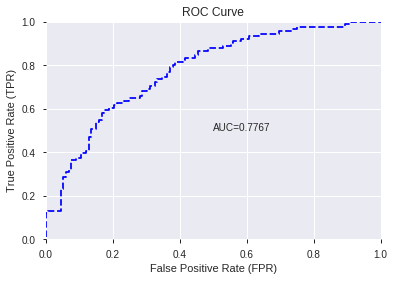

This function is available for GLM models only


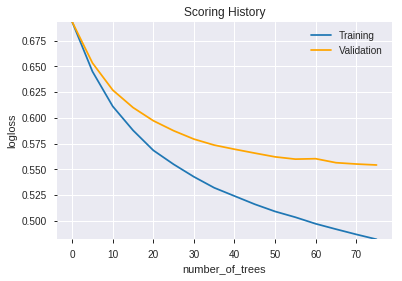

--2019-08-27 16:54:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_165335_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_165335_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_165450_model_2  0.787379  0.564078              0.276931  0.437442  0.191355
1  DeepLearning_grid_1_AutoML_20190827_165450_model_8  0.781302  0.546009              0.307776  0.432571  0.187118
2  DeepLearning_grid_1_AutoML_20190827_165450_model_6  0.776807  0.561091              0.311563  0.440015  0.193613
3  DeepLearning_grid_1_AutoML_20190827_165450_model_9  0.776640  0.554297              0.307401  0.434466  0.188761
4  DeepLearning_grid_1_AutoML_20190827_165450_model_5  0.771728  0.554993              0.303238  0.435545  0.189700
5  DeepLearning_grid_1_AutoML_20190827_165450_model_7  0.755911  0.637836              0.332584  0.467199  0.218275
6  DeepLearning_grid_1_AutoML_20190827_165450_model_3  0.754412  0.685360              0.300783  0.454908  0.206942
7  DeepLearning_grid_1_AutoML_20190827_165450_model_1  0.752498  0.977433              0.269356  0.478273  0.228745
8  DeepLearning_grid_1_AutoML_20190827_165450_model_4  0.729770  0.691436              0.349442  0.476089  0.226661
9               DeepLearning_1_AutoML_20190827_165450  0.728105  0.629900              0.319722  0.459796  0.211413

variable  relative_importance  scaled_importance  percentage
0        CDLEVENINGSTAR             1.000000           1.000000    0.045686
1     CDLDARKCLOUDCOVER             0.733771           0.733771    0.033523
2    CDLEVENINGDOJISTAR             0.698306           0.698306    0.031902
3                  hour             0.678431           0.678431    0.030994
4    CDLIDENTICAL3CROWS             0.666979           0.666979    0.030471
5          HT_TRENDMODE             0.649386           0.649386    0.029668
6   CDLGAPSIDESIDEWHITE             0.645679           0.645679    0.029498
7                   BOP             0.638743           0.638743    0.029181
8             CDLONNECK             0.596636           0.596636    0.027258
9                SAREXT             0.595568           0.595568    0.027209
10            CDLINNECK             0.592076           0.592076    0.027049
11      CDLUNIQUE3RIVER             0.567292           0.567292    0.025917
12            CORREL_14             0.552121           0.552121    0.025224
13        days_in_month             0.542285           0.542285    0.024775
14       STOCHRSI_fastd             0.538119           0.538119    0.024584
15            CORREL_12             0.537267           0.537267    0.024545
16    CDLINVERTEDHAMMER             0.523025           0.523025    0.023895
17      CDLLADDERBOTTOM             0.522906           0.522906    0.023889
18      CDLHOMINGPIGEON             0.501727           0.501727    0.022922
19       STOCHRSI_fastk             0.500808           0.500808    0.022880
20        CDLHIKKAKEMOD             0.494124           0.494124    0.022574
21    CDL3WHITESOLDIERS             0.493348           0.493348    0.022539
22         STOCHF_fastk             0.476214           0.476214    0.021756
23          STOCH_slowd             0.475026           0.475026    0.021702
24   CDLMORNINGDOJISTAR             0.429216           0.429216    0.019609
25             CORREL_8             0.414149           0.414149    0.018921
26    CDLSTALLEDPATTERN             0.407935           0.407935    0.018637
27               TRANGE             0.398159           0.398159    0.018190
28                  DIV             0.384866           0.384866    0.017583
29                  SUB             0.380069           0.380069    0.017364
30       CDLMORNINGSTAR             0.360550           0.360550    0.016472
31         CDLTASUKIGAP             0.349352           0.349352    0.015960
32            CORREL_24             0.337412           0.337412    0.015415
33          CDLLONGLINE             0.326887           0.326887    0.014934
34   CDLCLOSINGMARUBOZU             0.325606           0.325606    0.014875
35       CDL3LINESTRIKE             0.309556           0.309556    0.014142
36       is_month_start             0.303338           0.303338    0.013858
37      CDLSHOOTINGSTAR             0.287040           0.287040    0.013114
38      CDLADVANCEBLOCK             0.256595           0.256595    0.011723
39            CDLTAKURI             0.252580           0.252580    0.011539
40     CDLDRAGONFLYDOJI             0.240801           0.240801    0.011001
41       CDLHARAMICROSS             0.238078           0.238078    0.010877
42        CDLHANGINGMAN             0.232712           0.232712    0.010632
43         is_month_end             0.225045           0.225045    0.010281
44         CDLTHRUSTING             0.215292           0.215292    0.009836
45  CDLXSIDEGAP3METHODS             0.210470           0.210470    0.009615
46    CDLGRAVESTONEDOJI             0.201603           0.201603    0.009210
47           CDL3INSIDE             0.199571           0.199571    0.009118
48            CDLHAMMER             0.198938           0.198938    0.009089
49       CDLMATCHINGLOW             0.183094           0.183094    0.008365

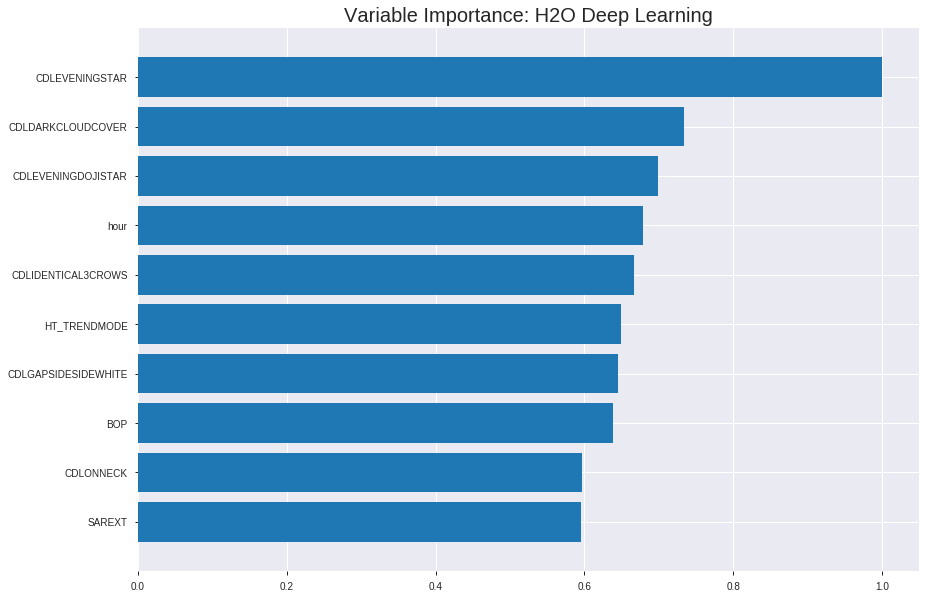

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_165450_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.181234950966703
RMSE: 0.4257169845880042
LogLoss: 0.5707752426656519
Mean Per-Class Error: 0.262678051310697
AUC: 0.8094094548404688
pr_auc: 0.7523573680186654
Gini: 0.6188189096809376
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2622350423350031: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      481  371  0.4354   (371.0/852.0)
1      89   617  0.1261   (89.0/706.0)
Total  570  988  0.2953   (460.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.262235     0.728453  281
max f2                       0.138903     0.835003  329
max f0point5                 0.626436     0.729952  149
max accuracy                 0.598437     0.740693  158
max precision                0.999693     1         0
max recall                   0.000129484  1         399
max specificity              0.999693     1         0
max absolute_mcc             0.598437     0.475323  158
max min_per_class_accuracy   0.45435      0.733711  209
max mean_per_class_accuracy  0.437787     0.737322  216

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.994635           2.06887   2.06887            0.9375           0.997861    0.9375                      0.997861            0.0212465       0.0212465                  106.887   106.887
    2        0.0205392                   0.989414           2.06887   2.06887            0.9375           0.991397    0.9375                      0.994629            0.0212465       0.0424929                  106.887   106.887
    3        0.0301669                   0.985457           1.4712    1.87813            0.666667         0.987304    0.851064                    0.992291            0.0141643       0.0566572                  47.1199   87.8127
    4        0.0404365                   0.979564           2.06887   1.92657            0.9375           0.98222     0.873016                    0.989734            0.0212465       0.0779037                  106.887   92.657
    5        0.0500642                   0.970348           1.76544   1.89558            0.8              0.975273    0.858974                    0.986953            0.0169972       0.0949008                  76.5439   89.5584
    6        0.100128                    0.929961           1.92388   1.90973            0.871795         0.951591    0.865385                    0.969272            0.0963173       0.191218                   92.3876   90.973
    7        0.150193                    0.881924           1.72583   1.84843            0.782051         0.904894    0.837607                    0.947813            0.0864023       0.27762                    72.583    84.843
    8        0.200257                    0.81925            1.69754   1.81071            0.769231         0.848912    0.820513                    0.923087            0.0849858       0.362606                   69.7538   81.0707
    9        0.300385                    0.695538           1.52778   1.7164             0.692308         0.759172    0.777778                    0.868449            0.152975        0.515581                   52.7784   71.6399
    10       0.399872                    0.554481           1.35255   1.62588            0.612903         0.625932    0.736758                    0.808112            0.134561        0.650142                   35.2554   62.5876
    11       0.5                         0.417286           1.03267   1.50708            0.467949         0.488715    0.682927                    0.74415             0.103399        0.753541                   3.26687   50.7082
    12       0.600128                    0.303899           0.905353  1.40669            0.410256         0.36015     0.637433                    0.680082            0.0906516       0.844193                   -9.46466  40.6687
    13       0.699615                    0.195369           0.697633  1.30586            0.316129         0.246898    0.591743                    0.618482            0.0694051       0.913598                   -30.2367  30.5858
    14       0.799743                    0.0960869          0.438531  1.19727            0.198718         0.140425    0.542536                    0.558629            0.0439093       0.957507                   -56.1469  19.7268
    15       0.899872                    0.0261428          0.282923  1.09553            0.128205         0.0592182   0.496434                    0.50306             0.0283286       0.985836                   -71.7077  9.55293
    16       1                           7.51028e-24        0.141461  1                  0.0641026        0.00817259  0.453145    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21575592232519428
RMSE: 0.46449534155381395
LogLoss: 0.7351933493203119
Mean Per-Class Error: 0.29345062335958005
AUC: 0.7445866141732284
pr_auc: 0.6713570755209856
Gini: 0.4891732283464567
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28303725442704086: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      138  116  0.4567   (116.0/254.0)
1      25   167  0.1302   (25.0/192.0)
Total  163  283  0.3161   (141.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283037     0.703158  266
max f2                       0.136164     0.807033  320
max f0point5                 0.283037     0.630665  266
max accuracy                 0.283037     0.683857  266
max precision                1            1         0
max recall                   5.78976e-06  1         399
max specificity              1            1         0
max absolute_mcc             0.283037     0.424751  266
max min_per_class_accuracy   0.461765     0.665354  198
max mean_per_class_accuracy  0.283037     0.706549  266

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 45.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.98863            2.32292   2.32292            1                0.994544   1                           0.994544            0.0260417       0.0260417                  132.292   132.292
    2        0.0201794                   0.985406           2.32292   2.32292            1                0.987579   1                           0.991449            0.0208333       0.046875                   132.292   132.292
    3        0.0313901                   0.981952           1.85833   2.15699            0.8              0.98418    0.928571                    0.988853            0.0208333       0.0677083                  85.8333   115.699
    4        0.0403587                   0.973481           1.16146   1.93576            0.5              0.980669   0.833333                    0.987034            0.0104167       0.078125                   16.1458   93.5764
    5        0.0515695                   0.965271           1.85833   1.91893            0.8              0.968609   0.826087                    0.983029            0.0208333       0.0989583                  85.8333   91.8931
    6        0.100897                    0.929238           1.58381   1.75509            0.681818         0.95056    0.755556                    0.967155            0.078125        0.177083                   58.3807   75.5093
    7        0.150224                    0.87076            1.58381   1.69885            0.681818         0.89831    0.731343                    0.944549            0.078125        0.255208                   58.3807   69.885
    8        0.201794                    0.807311           1.41395   1.62604            0.608696         0.835601   0.7                         0.916707            0.0729167       0.328125                   41.3949   62.6042
    9        0.300448                    0.649452           1.26705   1.50816            0.545455         0.727482   0.649254                    0.854573            0.125           0.453125                   26.7045   50.8162
    10       0.401345                    0.528222           1.34213   1.46642            0.577778         0.584092   0.631285                    0.786575            0.135417        0.588542                   34.213    46.6422
    11       0.5                         0.438821           1.05587   1.38542            0.454545         0.486899   0.596413                    0.727446            0.104167        0.692708                   5.58712   38.5417
    12       0.600897                    0.331775           1.29051   1.36948            0.555556         0.383273   0.589552                    0.669656            0.130208        0.822917                   29.0509   36.9481
    13       0.699552                    0.211236           0.73911   1.28058            0.318182         0.268268   0.551282                    0.61305             0.0729167       0.895833                   -26.089   28.0582
    14       0.800448                    0.0947507          0.464583  1.17773            0.2              0.156316   0.507003                    0.555478            0.046875        0.942708                   -53.5417  17.7725
    15       0.899103                    0.024193           0.369555  1.08905            0.159091         0.0573516  0.468828                    0.500821            0.0364583       0.979167                   -63.0445  8.90482
    16       1                           7.09013e-14        0.206481  1                  0.0888889        0.0073366  0.430493                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:55:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:55:34  43.135 sec        5368 obs/sec      10        1             15580      0.438247         0.592557            0.224951       0.788832        0.733179           2.06887          0.308729                         0.466932           0.751403              0.110712         0.737492          0.639616             1.39375            0.331839
    2019-08-27 16:55:41  49.577 sec        6720 obs/sec      40        4             62320      0.425717         0.570775            0.268638       0.809409        0.752357           2.06887          0.29525                          0.464495           0.735193              0.11997          0.744587          0.671357             2.32292            0.316143
    2019-08-27 16:55:46  55.020 sec        7444 obs/sec      70        7             109060     0.414244         0.527969            0.307525       0.826703        0.773919           2.06887          0.262516                         0.467185           0.74406               0.10975          0.736056          0.651089             1.39375            0.336323
    2019-08-27 16:55:53  1 min  1.642 sec  8101 obs/sec      110       11            171380     0.40807          0.520437            0.328016       0.838672        0.782814           2.06887          0.265725                         0.47156            0.806418              0.092998         0.738117          0.652145             1.39375            0.32287
    2019-08-27 16:55:59  1 min  7.778 sec  8585 obs/sec      150       15            233700     0.390323         0.474667            0.385191       0.860851        0.797414           2.06887          0.234275                         0.474574           0.85718               0.0813643        0.732437          0.651578             1.85833            0.327354
    2019-08-27 16:56:05  1 min 13.715 sec  8946 obs/sec      190       19            296020     0.396941         0.49711             0.364167       0.855458        0.781442           2.06887          0.241335                         0.478978           0.93621               0.0642383        0.73254           0.621033             1.39375            0.320628
    2019-08-27 16:56:05  1 min 13.787 sec  8944 obs/sec      190       19            296020     0.425717         0.570775            0.268638       0.809409        0.752357           2.06887          0.29525                          0.464495           0.735193              0.11997          0.744587          0.671357             2.32292            0.316143

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLEVENINGSTAR       1.0                    1.0                  0.04568557261268319
CDLDARKCLOUDCOVER    0.7337705492973328     0.7337705492973328   0.03352272771097173
CDLEVENINGDOJISTAR   0.6983057260513306     0.6983057260513306   0.03190249695337052
hour                 0.6784305572509766     0.6784305572509766   0.03099448848595261
CDLIDENTICAL3CROWS   0.6669794321060181     0.6669794321060181   0.030471337276645687
---                  ---                    ---                  ---
CDLXSIDEGAP3METHODS  0.21046997606754303    0.21046997606754303  0.00961544137442343
CDLGRAVESTONEDOJI    0.20160306990146637    0.20160306990146637  0.009210351688923287
CDL3INSIDE           0.19957083463668823    0.19957083463668823  0.00911750785716821
CDLHAMMER            0.19893823564052582    0.19893823564052582  0.009088607209794321
CDLMATCHINGLOW       0.18309380114078522    0.18309380114078522  0.008364745146949518


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.6919431279620853)

('auc', 0.7873792873792873)

('logloss', 0.5640781085701451)

('mean_per_class_error', 0.276931401931402)

('rmse', 0.43744177640502585)

('mse', 0.19135530774438464)

deeplearning prediction progress: |███████████████████████████████████████| 100%


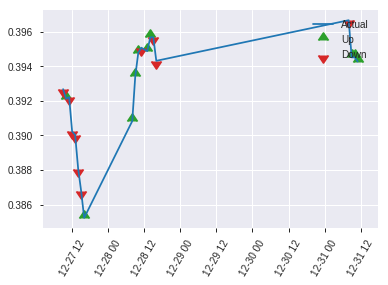


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19135530774438464
RMSE: 0.43744177640502585
LogLoss: 0.5640781085701451
Mean Per-Class Error: 0.276931401931402
AUC: 0.7873792873792873
pr_auc: 0.7108676480709052
Gini: 0.5747585747585746
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36440989556488035: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   47   0.3561   (47.0/132.0)
1      18   73   0.1978   (18.0/91.0)
Total  103  120  0.2915   (65.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36441      0.691943  119
max f2                       0.10383      0.819521  178
max f0point5                 0.74198      0.661017  50
max accuracy                 0.576991     0.717489  79
max precision                0.999998     1         0
max recall                   0.0346803    1         201
max specificity              0.999998     1         0
max absolute_mcc             0.36441      0.439812  119
max min_per_class_accuracy   0.425101     0.704545  103
max mean_per_class_accuracy  0.36441      0.723069  119

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 43.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.996245           2.45055   2.45055            1                0.998639   1                           0.998639            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.986228           2.45055   2.45055            1                0.992406   1                           0.996146            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.979393           2.45055   2.45055            1                0.9823     1                           0.99219             0.021978        0.0769231                  145.055   145.055
    4        0.0403587                   0.972014           2.45055   2.45055            1                0.97776    1                           0.988983            0.021978        0.0989011                  145.055   145.055
    5        0.0538117                   0.96783            1.6337    2.24634            0.666667         0.970035   0.916667                    0.984246            0.021978        0.120879                   63.37     124.634
    6        0.103139                    0.908702           1.78222   2.02437            0.727273         0.942998   0.826087                    0.964519            0.0879121       0.208791                   78.2218   102.437
    7        0.152466                    0.818041           2.005     2.0181             0.818182         0.855663   0.823529                    0.9293              0.0989011       0.307692                   100.5     101.81
    8        0.201794                    0.773324           1.55944   1.90598            0.636364         0.799627   0.777778                    0.897602            0.0769231       0.384615                   55.9441   90.5983
    9        0.300448                    0.65504            1.22527   1.68247            0.5              0.715872   0.686567                    0.83793             0.120879        0.505495                   22.5275   68.2467
    10       0.399103                    0.521813           1.11389   1.54192            0.454545         0.585944   0.629213                    0.775641            0.10989         0.615385                   11.3886   54.1919
    11       0.502242                    0.394769           1.172     1.46595            0.478261         0.449271   0.598214                    0.708619            0.120879        0.736264                   17.2002   46.5954
    12       0.600897                    0.296383           1.0025    1.38986            0.409091         0.342955   0.567164                    0.648584            0.0989011       0.835165                   0.24975   38.9864
    13       0.699552                    0.19404            0.77972   1.30382            0.318182         0.235536   0.532051                    0.590334            0.0769231       0.912088                   -22.028   30.3818
    14       0.798206                    0.108091           0.556943  1.21151            0.227273         0.152166   0.494382                    0.536178            0.0549451       0.967033                   -44.3057  21.1508
    15       0.896861                    0.0370137          0.222777  1.10275            0.0909091        0.0683666  0.45                        0.484719            0.021978        0.989011                   -77.7223  10.2747
    16       1                           4.86788e-08        0.106546  1                  0.0434783        0.0154932  0.408072                    

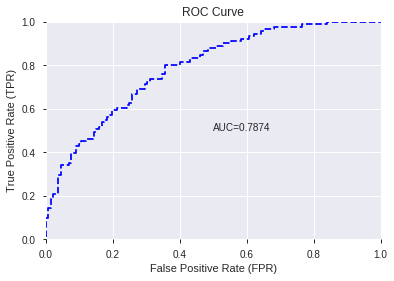

This function is available for GLM models only


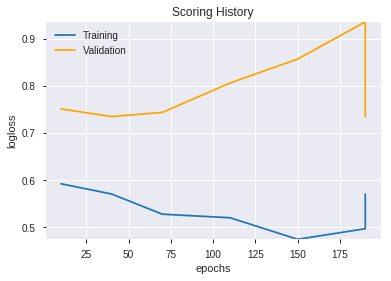

--2019-08-27 17:02:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_165450_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_165450_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'hour',
 'CDLIDENTICAL3CROWS',
 'HT_TRENDMODE',
 'CDLGAPSIDESIDEWHITE',
 'BOP',
 'CDLONNECK',
 'SAREXT',
 'CDLINNECK',
 'CDLUNIQUE3RIVER',
 'CORREL_14',
 'days_in_month',
 'STOCHRSI_fastd',
 'CORREL_12',
 'CDLINVERTEDHAMMER',
 'CDLLADDERBOTTOM',
 'CDLHOMINGPIGEON',
 'STOCHRSI_fastk',
 'CDLHIKKAKEMOD',
 'CDL3WHITESOLDIERS',
 'STOCHF_fastk',
 'STOCH_slowd',
 'CDLMORNINGDOJISTAR',
 'CORREL_8',
 'CDLSTALLEDPATTERN',
 'TRANGE',
 'DIV',
 'SUB',
 'CDLMORNINGSTAR',
 'CDLTASUKIGAP',
 'CORREL_24',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'CDL3LINESTRIKE',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLHARAMICROSS',
 'CDLHANGINGMAN',
 'is_month_end',
 'CDLTHRUSTING',
 'CDLXSIDEGAP3METHODS',
 'CDLGRAVESTONEDOJI',
 'CDL3INSIDE',
 'CDLHAMMER',
 'CDLMATCHINGLOW']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_170225_model_1  0.777473  0.558494                0.3002  0.435621  0.189766

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.624302           1.000000    0.156041
1          STOCHF_fastk             0.221666           0.355062    0.055404
2                TRANGE             0.209138           0.334995    0.052273
3                   SUB             0.184020           0.294761    0.045995
4                   DIV             0.169494           0.271494    0.042364
5        STOCHRSI_fastd             0.164826           0.264016    0.041197
6                  hour             0.153109           0.245248    0.038269
7              CORREL_8             0.126966           0.203373    0.031735
8             CORREL_14             0.123999           0.198620    0.030993
9        STOCHRSI_fastk             0.122241           0.195804    0.030553
10            CORREL_24             0.108451           0.173716    0.027107
11        CDLHANGINGMAN             0.100475           0.160940    0.025113
12       CDL3LINESTRIKE             0.087695           0.140469    0.021919
13            CORREL_12             0.087655           0.140405    0.021909
14     CDLDRAGONFLYDOJI             0.085580           0.137081    0.021390
15            CDLTAKURI             0.085441           0.136859    0.021356
16        days_in_month             0.075936           0.121634    0.018980
17         CDLTASUKIGAP             0.073219           0.117281    0.018301
18    CDLGRAVESTONEDOJI             0.072285           0.115785    0.018067
19          STOCH_slowd             0.069254           0.110931    0.017310
20    CDL3WHITESOLDIERS             0.067275           0.107760    0.016815
21       CDLEVENINGSTAR             0.064829           0.103842    0.016204
22      CDLHOMINGPIGEON             0.064360           0.103091    0.016086
23  CDLGAPSIDESIDEWHITE             0.063006           0.100922    0.015748
24      CDLLADDERBOTTOM             0.056805           0.090990    0.014198
25       is_month_start             0.055653           0.089144    0.013910
26    CDLINVERTEDHAMMER             0.055031           0.088148    0.013755
27          CDLLONGLINE             0.054818           0.087807    0.013701
28         HT_TRENDMODE             0.052482           0.084065    0.013118
29               SAREXT             0.052218           0.083642    0.013052
30      CDLUNIQUE3RIVER             0.049299           0.078966    0.012322
31   CDLIDENTICAL3CROWS             0.048370           0.077478    0.012090
32        CDLHIKKAKEMOD             0.046229           0.074049    0.011555
33    CDLDARKCLOUDCOVER             0.039831           0.063801    0.009956
34            CDLINNECK             0.035860           0.057440    0.008963
35            CDLONNECK             0.035774           0.057302    0.008941
36       CDLMORNINGSTAR             0.032369           0.051848    0.008090
37  CDLXSIDEGAP3METHODS             0.029651           0.047495    0.007411
38           CDL3INSIDE             0.026390           0.042271    0.006596
39      CDLADVANCEBLOCK             0.025566           0.040952    0.006390
40   CDLEVENINGDOJISTAR             0.021219           0.033989    0.005304
41      CDLSHOOTINGSTAR             0.017615           0.028216    0.004403
42       CDLHARAMICROSS             0.016474           0.026387    0.004117
43   CDLMORNINGDOJISTAR             0.014105           0.022593    0.003525
44            CDLHAMMER             0.009358           0.014990    0.002339
45         CDLTHRUSTING             0.008486           0.013592    0.002121
46   CDLCLOSINGMARUBOZU             0.004110           0.006583    0.001027
47         is_month_end             0.003751           0.006009    0.000938
48       CDLMATCHINGLOW             0.002939           0.004708    0.000735
49    CDLSTALLEDPATTERN             0.001260           0.002019    0.000315

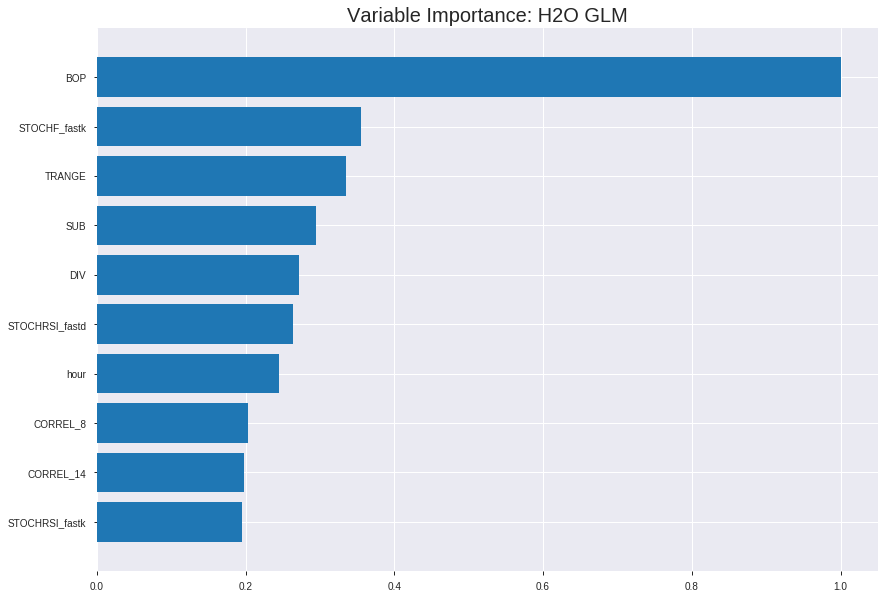

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_170225_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18533413862325404
RMSE: 0.4305045163796241
LogLoss: 0.5498481844100017
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2146.1448765004316
Residual deviance: 1713.3269426215652
AIC: 1815.3269426215652
AUC: 0.794329955179614
pr_auc: 0.7331433230485569
Gini: 0.588659910359228
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40558755412951053: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      547  305  0.358    (305.0/852.0)
1      136  570  0.1926   (136.0/706.0)
Total  683  875  0.2831   (441.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405588     0.721063  219
max f2                       0.205655     0.832528  322
max f0point5                 0.51308      0.707858  168
max accuracy                 0.500217     0.731707  173
max precision                0.960432     1         0
max recall                   0.101176     1         368
max specificity              0.960432     1         0
max absolute_mcc             0.463636     0.46013   188
max min_per_class_accuracy   0.463636     0.728045  188
max mean_per_class_accuracy  0.463636     0.730807  188

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.882093           1.79302   1.79302            0.8125           0.913833   0.8125                      0.913833            0.0184136       0.0184136                  79.3024   79.3024
    2        0.0205392                   0.836375           1.79302   1.79302            0.8125           0.855539   0.8125                      0.884686            0.0184136       0.0368272                  79.3024   79.3024
    3        0.0301669                   0.824026           2.05968   1.87813            0.933333         0.830211   0.851064                    0.8673              0.01983         0.0566572                  105.968   87.8127
    4        0.0404365                   0.813934           1.6551    1.82148            0.75             0.818786   0.825397                    0.854979            0.0169972       0.0736544                  65.5099   82.1485
    5        0.0500642                   0.802646           2.05968   1.86729            0.933333         0.808025   0.846154                    0.84595             0.01983         0.0934844                  105.968   86.7291
    6        0.100128                    0.75097            1.72583   1.79656            0.782051         0.771565   0.814103                    0.808757            0.0864023       0.179887                   72.583    79.6561
    7        0.150193                    0.705157           1.78241   1.79185            0.807692         0.727652   0.811966                    0.781722            0.0892351       0.269122                   78.2414   79.1845
    8        0.200257                    0.668913           1.55608   1.7329             0.705128         0.687448   0.785256                    0.758154            0.0779037       0.347025                   55.6076   73.2903
    9        0.300385                    0.603446           1.61266   1.69282            0.730769         0.635677   0.767094                    0.717328            0.161473        0.508499                   61.2661   69.2822
    10       0.399872                    0.530694           1.30984   1.59754            0.593548         0.569591   0.723917                    0.680572            0.130312        0.63881                    30.9842   59.7538
    11       0.5                         0.450779           1.08925   1.49575            0.49359          0.485943   0.677792                    0.641596            0.109065        0.747875                   8.92533   49.5751
    12       0.600128                    0.379625           0.820477  1.38308            0.371795         0.412157   0.626738                    0.603315            0.082153        0.830028                   -17.9523  38.3085
    13       0.699615                    0.308613           0.683396  1.28359            0.309677         0.343757   0.581651                    0.566406            0.0679887       0.898017                   -31.6604  28.3588
    14       0.799743                    0.239282           0.565846  1.19373            0.25641          0.271019   0.540931                    0.529423            0.0566572       0.954674                   -43.4154  19.3726
    15       0.899872                    0.153261           0.325361  1.0971             0.147436         0.198254   0.497147                    0.492574            0.0325779       0.987252                   -67.4639  9.71033
    16       1                           0.000552464        0.127315  1                  0.0576923        0.0987913  0.453145                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1871459199738241
RMSE: 0.4326036522890486
LogLoss: 0.5564302115095883
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 610.5669311494817
Residual deviance: 496.3357486665527
AIC: 598.3357486665527
AUC: 0.7879962270341206
pr_auc: 0.6988289588695437
Gini: 0.5759924540682413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34421646160293584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      140  114  0.4488   (114.0/254.0)
1      20   172  0.1042   (20.0/192.0)
Total  160  286  0.3004   (134.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344216     0.719665  256
max f2                       0.284817     0.822669  291
max f0point5                 0.651        0.688776  87
max accuracy                 0.427161     0.719731  210
max precision                0.968931     1         0
max recall                   0.0820573    1         385
max specificity              0.968931     1         0
max absolute_mcc             0.359385     0.462073  247
max min_per_class_accuracy   0.458485     0.712598  189
max mean_per_class_accuracy  0.359385     0.72687   247

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 44.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.871922           1.39375   1.39375            0.6              0.923986  0.6                         0.923986            0.015625        0.015625                   39.375    39.375
    2        0.0201794                   0.820835           2.32292   1.80671            1                0.831616  0.777778                    0.882933            0.0208333       0.0364583                  132.292   80.6713
    3        0.0313901                   0.810568           1.39375   1.65923            0.6              0.81712   0.714286                    0.859428            0.015625        0.0520833                  39.375    65.9226
    4        0.0403587                   0.801648           1.74219   1.67766            0.75             0.806937  0.722222                    0.847763            0.015625        0.0677083                  74.2188   67.7662
    5        0.0515695                   0.791801           1.85833   1.71694            0.8              0.796977  0.73913                     0.836723            0.0208333       0.0885417                  85.8333   71.6938
    6        0.100897                    0.742685           1.90057   1.80671            0.818182         0.764962  0.777778                    0.80164             0.09375         0.182292                   90.0568   80.6713
    7        0.150224                    0.704161           2.00616   1.8722             0.863636         0.722141  0.80597                     0.775536            0.0989583       0.28125                    100.616   87.2201
    8        0.201794                    0.667887           2.01993   1.90995            0.869565         0.685395  0.822222                    0.7525              0.104167        0.385417                   101.993   90.9954
    9        0.300448                    0.581496           1.10866   1.64684            0.477273         0.624468  0.708955                    0.710459            0.109375        0.494792                   10.8665   64.6844
    10       0.401345                    0.497597           1.23889   1.54429            0.533333         0.539309  0.664804                    0.667433            0.125           0.619792                   23.8889   54.4285
    11       0.5                         0.442087           1.26705   1.48958            0.545455         0.469045  0.641256                    0.628289            0.125           0.744792                   26.7045   48.9583
    12       0.600897                    0.367229           1.08403   1.42149            0.466667         0.404842  0.61194                     0.59077             0.109375        0.854167                   8.40278   42.1486
    13       0.699552                    0.302042           0.633523  1.31036            0.272727         0.33748   0.564103                    0.55505             0.0625          0.916667                   -36.6477  31.0363
    14       0.800448                    0.223832           0.309722  1.18423            0.133333         0.266451  0.509804                    0.518672            0.03125         0.947917                   -69.0278  18.4232
    15       0.899103                    0.152422           0.263968  1.08326            0.113636         0.187224  0.466334                    0.482303            0.0260417       0.973958                   -73.6032  8.32554
    16       1                           0.00471085         0.258102  1                  0.111111         0.102333  0.430493                    0.443965          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:02:25  0.000 sec   2            21        51            1.36369           1.35483
    2019-08-27 17:02:25  0.012 sec   4            13        51            1.35599           1.34692
    2019-08-27 17:02:25  0.024 sec   6            8         51            1.34461           1.33521
    2019-08-27 17:02:25  0.036 sec   8            4.9       51            1.32848           1.31857
    2019-08-27 17:02:25  0.048 sec   10           3.1       51            1.30698           1.29632
    2019-08-27 17:02:25  0.059 sec   12           1.9       51            1.28037           1.26871
    2019-08-27 17:02:25  0.071 sec   14           1.2       51            1.25028           1.23748
    2019-08-27 17:02:25  0.082 sec   16           0.74      51            1.21911           1.20534
    2019-08-27 17:02:25  0.094 sec   18           0.46      51            1.18939           1.17537
    2019-08-27 17:02:25  0.105 sec   20           0.28      51            1.16297           1.15005
    2019-08-27 17:02:25  0.114 sec   22           0.18      51            1.14076           1.13096
    2019-08-27 17:02:25  0.122 sec   24           0.11      51            1.12298           1.11873
    2019-08-27 17:02:25  0.132 sec   26           0.068     51            1.10943           1.11305
    2019-08-27 17:02:25  0.144 sec   28           0.042     51            1.0997            1.11286
    2019-08-27 17:02:25  0.155 sec   30           0.026     51            1.09319           1.1166
    2019-08-27 17:02:25  0.166 sec   32           0.016     51            1.08917           1.12259
    2019-08-27 17:02:25  0.183 sec   34           0.01      51            1.08684           1.1295
    2019-08-27 17:02:25  0.194 sec   36           0.0063    51            1.08555           1.13649
    2019-08-27 17:02:25  0.200 sec   38           0.0039    51            1.08485           1.14323

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.6907630522088354)

('auc', 0.7774725274725274)

('logloss', 0.5584944891039295)

('mean_per_class_error', 0.28733766233766234)

('rmse', 0.43562137157196057)

('mse', 0.18976597937023612)

glm prediction progress: |████████████████████████████████████████████████| 100%


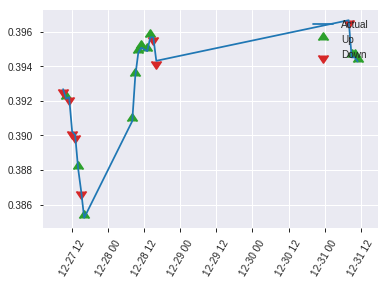


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18976597937023612
RMSE: 0.43562137157196057
LogLoss: 0.5584944891039295
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 303.40375268137996
Residual deviance: 249.08854214035253
AIC: 351.0885421403525
AUC: 0.7774725274725274
pr_auc: 0.6649786432050186
Gini: 0.5549450549450547
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30742097265367385: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   72   0.5455   (72.0/132.0)
1      5    86   0.0549   (5.0/91.0)
Total  65   158  0.3453   (77.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.307421     0.690763  157
max f2                       0.272666     0.825516  168
max f0point5                 0.561932     0.667575  68
max accuracy                 0.561932     0.721973  68
max precision                0.907295     1         0
max recall                   0.18863      1         198
max specificity              0.907295     1         0
max absolute_mcc             0.307421     0.432164  157
max min_per_class_accuracy   0.447833     0.674242  104
max mean_per_class_accuracy  0.368303     0.712662  134

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 44.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.873094           1.6337    1.6337             0.666667         0.886998  0.666667                    0.886998            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.834696           1.22527   1.47033            0.5              0.849583  0.6                         0.872032            0.010989        0.032967                   22.5275   47.033
    3        0.0313901                   0.825019           2.45055   1.75039            1                0.829897  0.714286                    0.859993            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.789015           2.45055   1.90598            1                0.821529  0.777778                    0.851446            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.779753           2.45055   2.04212            1                0.782178  0.833333                    0.834129            0.032967        0.10989                    145.055   104.212
    6        0.103139                    0.732791           1.78222   1.91782            0.727273         0.751222  0.782609                    0.794478            0.0879121       0.197802                   78.2218   91.7821
    7        0.152466                    0.682649           1.33666   1.7298             0.545455         0.705109  0.705882                    0.765564            0.0659341       0.263736                   33.6663   72.98
    8        0.201794                    0.649734           2.45055   1.90598            1                0.670529  0.777778                    0.742333            0.120879        0.384615                   145.055   90.5983
    9        0.300448                    0.575563           1.33666   1.71904            0.545455         0.61369   0.701493                    0.700092            0.131868        0.516484                   33.6663   71.9042
    10       0.399103                    0.49373            1.0025    1.54192            0.409091         0.526847  0.629213                    0.657268            0.0989011       0.615385                   0.24975   54.1919
    11       0.502242                    0.417334           1.06546   1.44407            0.434783         0.455979  0.589286                    0.615932            0.10989         0.725275                   6.54563   44.4074
    12       0.600897                    0.368443           1.22527   1.40815            0.5              0.387925  0.574627                    0.578498            0.120879        0.846154                   22.5275   40.8152
    13       0.699552                    0.313145           0.77972   1.31953            0.318182         0.340927  0.538462                    0.544994            0.0769231       0.923077                   -22.028   31.9527
    14       0.798206                    0.2488             0.556943  1.22527            0.227273         0.276812  0.5                         0.511848            0.0549451       0.978022                   -44.3057  22.5275
    15       0.896861                    0.180685           0.222777  1.115              0.0909091        0.217042  0.455                       0.479419            0.021978        1                          -77.7223  11.5
    16       1                           0.021182           0         1                  0                0.122249  0.408072                    0.442581            0    

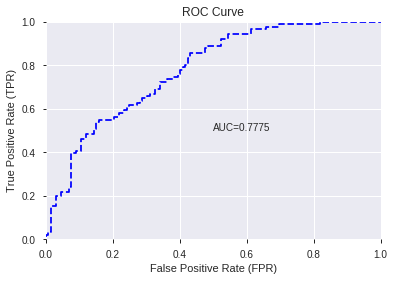

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


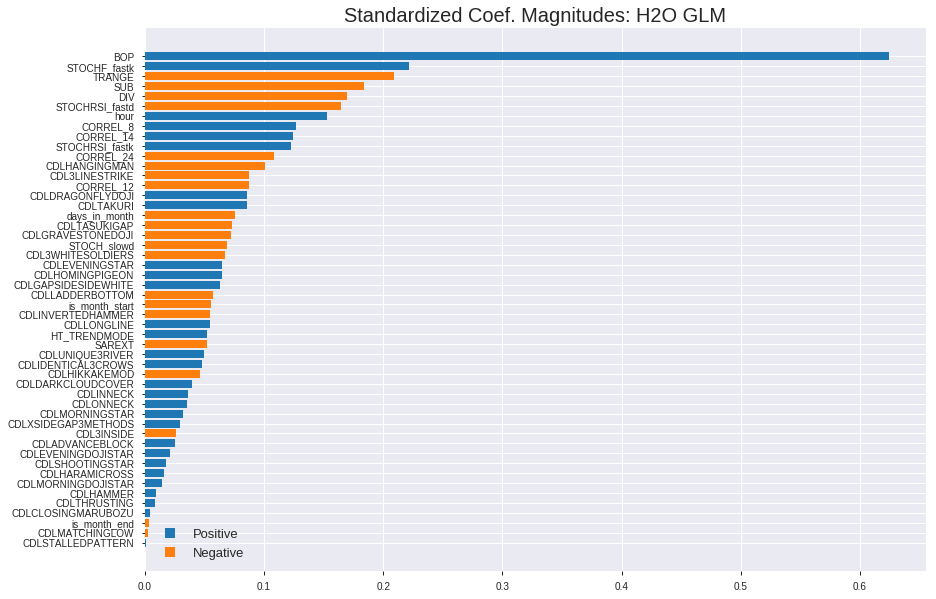

'log_likelihood'
--2019-08-27 17:02:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.72
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.72|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_170225_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_170225_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'SUB',
 'DIV',
 'STOCHRSI_fastd',
 'hour',
 'CORREL_8',
 'CORREL_14',
 'STOCHRSI_fastk',
 'CORREL_24',
 'CDLHANGINGMAN',
 'CDL3LINESTRIKE',
 'CORREL_12',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'days_in_month',
 'CDLTASUKIGAP',
 'CDLGRAVESTONEDOJI',
 'STOCH_slowd',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGSTAR',
 'CDLHOMINGPIGEON',
 'CDLGAPSIDESIDEWHITE',
 'CDLLADDERBOTTOM',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'SAREXT',
 'CDLUNIQUE3RIVER',
 'CDLIDENTICAL3CROWS',
 'CDLHIKKAKEMOD',
 'CDLDARKCLOUDCOVER',
 'CDLINNECK',
 'CDLONNECK',
 'CDLMORNINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'CDL3INSIDE',
 'CDLADVANCEBLOCK',
 'CDLEVENINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CDLHARAMICROSS',
 'CDLMORNINGDOJISTAR',
 'CDLHAMMER',
 'CDLTHRUSTING',
 'CDLCLOSINGMARUBOZU',
 'is_month_end',
 'CDLMATCHINGLOW',
 'CDLSTALLEDPATTERN']

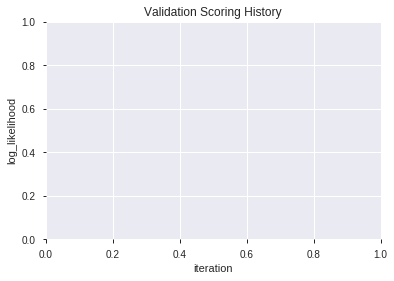

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_170236_model_4  0.773144  0.561713              0.278638  0.436247  0.190312
1  XGBoost_grid_1_AutoML_20190827_170236_model_6  0.770147  0.561828              0.310065  0.436937  0.190914
2  XGBoost_grid_1_AutoML_20190827_170236_model_3  0.769897  0.566079              0.280719  0.437769  0.191641
3               XGBoost_2_AutoML_20190827_170236  0.768898  0.565312              0.292458  0.438859  0.192598
4  XGBoost_grid_1_AutoML_20190827_170236_model_1  0.764236  0.567482              0.285839  0.439329  0.193010
5               XGBoost_1_AutoML_20190827_170236  0.761738  0.574002              0.278263  0.441698  0.195097
6               XGBoost_3_AutoML_20190827_170236  0.761489  0.569345              0.284882  0.439829  0.193450
7  XGBoost_grid_1_AutoML_20190827_170236_model_7  0.758991  0.575056              0.297577  0.442436  0.195750
8  XGBoost_grid_1_AutoML_20190827_170236_model_2  0.756910  0.575440              0.294913  0.442382  0.195702
9  XGBoost_grid_1_AutoML_20190827_170236_model_5  0.745005  0.587404              0.324842  0.447670  0.200408

variable  relative_importance  scaled_importance  percentage
0              BOP          2114.545654           1.000000    0.459748
1           TRANGE           506.601807           0.239580    0.110146
2              DIV           426.333160           0.201619    0.092694
3             hour           284.095856           0.134353    0.061769
4     STOCHF_fastk           227.804855           0.107732    0.049530
5   STOCHRSI_fastk           181.999451           0.086070    0.039571
6   STOCHRSI_fastd           169.922562           0.080359    0.036945
7              SUB           162.615295           0.076903    0.035356
8           SAREXT           144.925812           0.068538    0.031510
9        CORREL_24           118.511833           0.056046    0.025767
10     STOCH_slowd           103.766319           0.049073    0.022561
11       CORREL_14            47.673607           0.022546    0.010365
12       CORREL_12            34.161388           0.016155    0.007427
13   days_in_month            29.685368           0.014039    0.006454
14        CORREL_8            27.199516           0.012863    0.005914
15    HT_TRENDMODE            19.520487           0.009232    0.004244

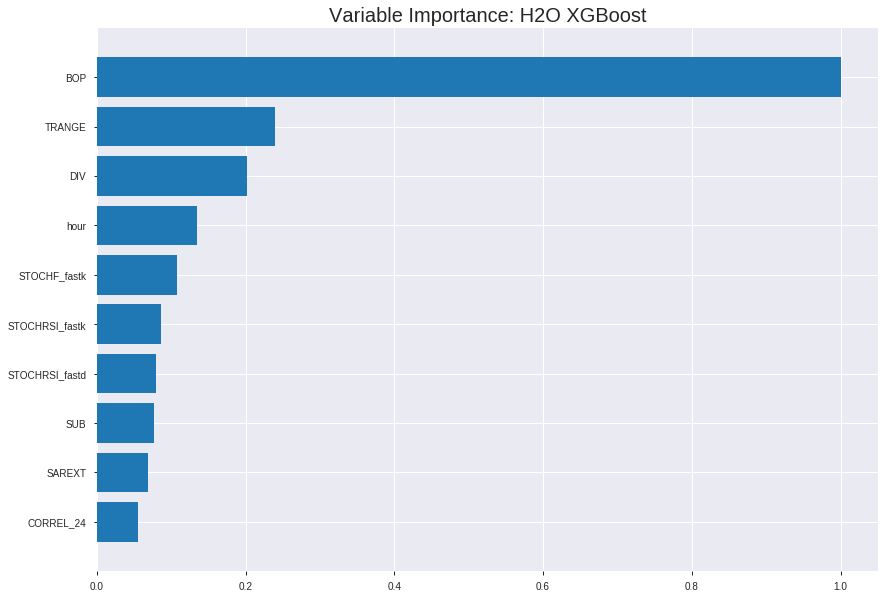

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_170236_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17230758898879153
RMSE: 0.415099492879468
LogLoss: 0.5195118668479043
Mean Per-Class Error: 0.24549967415446416
AUC: 0.8248538682520049
pr_auc: 0.7767635598810273
Gini: 0.6497077365040098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41334256529808044: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      570  282  0.331    (282.0/852.0)
1      117  589  0.1657   (117.0/706.0)
Total  687  871  0.2561   (399.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413343     0.746988  226
max f2                       0.208637     0.844653  322
max f0point5                 0.58155      0.731989  142
max accuracy                 0.488847     0.750321  188
max precision                0.837575     1         0
max recall                   0.0993124    1         385
max specificity              0.837575     1         0
max absolute_mcc             0.440953     0.507535  212
max min_per_class_accuracy   0.488847     0.749292  188
max mean_per_class_accuracy  0.440953     0.7545    212

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.811383           1.93095    1.93095            0.875            0.820878  0.875                       0.820878            0.01983         0.01983                    93.0949   93.0949
    2        0.0205392                   0.801844           2.2068     2.06887            1                0.80736   0.9375                      0.814119            0.0226629       0.0424929                  120.68    106.887
    3        0.0301669                   0.795992           2.05968    2.06594            0.933333         0.799036  0.93617                     0.809305            0.01983         0.0623229                  105.968   106.594
    4        0.0404365                   0.789332           2.06887    2.06668            0.9375           0.793354  0.936508                    0.805254            0.0212465       0.0835694                  106.887   106.668
    5        0.0500642                   0.782466           2.2068     2.09363            1                0.786574  0.948718                    0.801662            0.0212465       0.104816                   120.68    109.363
    6        0.100128                    0.748632           1.69754    1.89558            0.769231         0.764378  0.858974                    0.78302             0.0849858       0.189802                   69.7538   89.5584
    7        0.150193                    0.71754            1.89558    1.89558            0.858974         0.734058  0.858974                    0.766699            0.0949008       0.284703                   89.5584   89.5584
    8        0.200257                    0.692057           1.72583    1.85315            0.782051         0.70389   0.839744                    0.750997            0.0864023       0.371105                   72.583    85.3145
    9        0.300385                    0.632872           1.35803    1.68811            0.615385         0.664163  0.764957                    0.722052            0.135977        0.507082                   35.803    68.8107
    10       0.399872                    0.556328           1.5234     1.64713            0.690323         0.597585  0.746388                    0.691085            0.151558        0.65864                    52.3403   64.7129
    11       0.5                         0.464249           1.15998    1.54958            0.525641         0.510666  0.702182                    0.654955            0.116147        0.774788                   15.9984   54.9575
    12       0.600128                    0.370711           0.848769   1.43265            0.384615         0.420047  0.649198                    0.615762            0.0849858       0.859773                   -15.1231  43.2649
    13       0.699615                    0.276829           0.740345   1.3342             0.335484         0.326795  0.604587                    0.57467             0.0736544       0.933428                   -25.9655  33.4202
    14       0.799743                    0.19503            0.381946   1.21498            0.173077         0.234979  0.550562                    0.532141            0.0382436       0.971671                   -61.8054  21.4979
    15       0.899872                    0.126926           0.226338   1.10497            0.102564         0.160088  0.500713                    0.490743            0.0226629       0.994334                   -77.3662  10.4973
    16       1                           0.0708111          0.0565846  1                  0.025641         0.104663  0.453145                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19283908693488275
RMSE: 0.43913447477382456
LogLoss: 0.5662005106708121
Mean Per-Class Error: 0.29765419947506566
AUC: 0.7700643864829396
pr_auc: 0.6890334144905212
Gini: 0.5401287729658792
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25460416078567505: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  138  0.5433   (138.0/254.0)
1      18   174  0.0938   (18.0/192.0)
Total  134  312  0.3498   (156.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.254604     0.690476  283
max f2                       0.202172     0.81982   310
max f0point5                 0.60493      0.678191  124
max accuracy                 0.60493      0.713004  124
max precision                0.837113     1         0
max recall                   0.10318      1         381
max specificity              0.837113     1         0
max absolute_mcc             0.60493      0.407194  124
max min_per_class_accuracy   0.462622     0.692708  188
max mean_per_class_accuracy  0.411169     0.702346  215

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 43.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.806647           1.85833   1.85833            0.8              0.819454  0.8                         0.819454            0.0208333       0.0208333                  85.8333   85.8333
    2        0.0201794                   0.799134           2.32292   2.06481            1                0.803926  0.888889                    0.812553            0.0208333       0.0416667                  132.292   106.481
    3        0.0313901                   0.788168           1.85833   1.99107            0.8              0.793612  0.857143                    0.805788            0.0208333       0.0625                     85.8333   99.1071
    4        0.0403587                   0.777753           1.74219   1.93576            0.75             0.783575  0.833333                    0.800852            0.015625        0.078125                   74.2188   93.5764
    5        0.0515695                   0.771785           2.32292   2.01993            1                0.774713  0.869565                    0.79517             0.0260417       0.104167                   132.292   101.993
    6        0.100897                    0.739786           1.47822   1.75509            0.636364         0.752588  0.755556                    0.774352            0.0729167       0.177083                   47.822    75.5093
    7        0.150224                    0.710003           1.58381   1.69885            0.681818         0.727536  0.731343                    0.75898             0.078125        0.255208                   58.3807   69.885
    8        0.201794                    0.687733           1.91893   1.75509            0.826087         0.700022  0.755556                    0.743913            0.0989583       0.354167                   91.8931   75.5093
    9        0.300448                    0.614272           1.58381   1.69885            0.681818         0.656933  0.731343                    0.715352            0.15625         0.510417                   58.3807   69.885
    10       0.401345                    0.532782           1.08403   1.54429            0.466667         0.571799  0.664804                    0.679263            0.109375        0.619792                   8.40278   54.4285
    11       0.5                         0.444674           1.00308   1.4375             0.431818         0.47806   0.618834                    0.639564            0.0989583       0.71875                    0.307765  43.75
    12       0.600897                    0.372751           0.980787  1.36081            0.422222         0.406546  0.585821                    0.600438            0.0989583       0.817708                   -1.9213   36.0813
    13       0.699552                    0.254377           0.897491  1.29547            0.386364         0.300128  0.557692                    0.558086            0.0885417       0.90625                    -10.2509  29.5473
    14       0.800448                    0.180762           0.464583  1.19074            0.2              0.211548  0.512605                    0.514405            0.046875        0.953125                   -53.5417  19.0739
    15       0.899103                    0.12399            0.369555  1.10063            0.159091         0.152668  0.473815                    0.474713            0.0364583       0.989583                   -63.0445  10.0634
    16       1                           0.0791953          0.103241  1                  0.0444444        0.103625  0.430493                    0.437272            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:02:45  3.684 sec   0                  0.5              0.693147            0.5             0                  1                0.546855                         0.5                0.693147              0.5               0                    1                  0.569507
    2019-08-27 17:02:45  3.787 sec   5                  0.476288         0.646532            0.787675        0.721193           1.839            0.289474                         0.478523           0.650812              0.757536          0.677757             2.32292            0.374439
    2019-08-27 17:02:45  3.849 sec   10                 0.460692         0.616166            0.792354        0.739158           2.2068           0.302311                         0.464934           0.624139              0.767419          0.711533             2.32292            0.32287
    2019-08-27 17:02:45  3.913 sec   15                 0.449625         0.594146            0.797823        0.746109           2.06887          0.29846                          0.456559           0.607043              0.765697          0.706509             2.32292            0.336323
    2019-08-27 17:02:45  3.985 sec   20                 0.441283         0.577039            0.80093         0.747264           1.94718          0.289474                         0.450617           0.594356              0.766661          0.710064             2.32292            0.331839
    2019-08-27 17:02:45  4.056 sec   25                 0.436042         0.565818            0.804304        0.750579           1.93095          0.284981                         0.446661           0.585492              0.767778          0.709148             2.32292            0.32287
    2019-08-27 17:02:45  4.140 sec   30                 0.431253         0.555492            0.807492        0.754457           1.93095          0.268293                         0.443242           0.577604              0.770741          0.709721             2.32292            0.320628
    2019-08-27 17:02:46  4.210 sec   35                 0.427663         0.547514            0.80943         0.754469           1.93095          0.280488                         0.442062           0.574337              0.769706          0.708785             2.32292            0.316143
    2019-08-27 17:02:46  4.277 sec   40                 0.424805         0.54097             0.812213        0.758578           1.93095          0.270218                         0.440639           0.570593              0.769275          0.704024             2.32292            0.331839
    2019-08-27 17:02:46  4.352 sec   45                 0.422423         0.535642            0.814817        0.760856           1.93095          0.259307                         0.440234           0.569122              0.769203          0.700216             2.32292            0.336323
    2019-08-27 17:02:46  4.432 sec   50                 0.420168         0.530577            0.817461        0.766093           1.93095          0.267009                         0.439779           0.567599              0.768855          0.69578              2.32292            0.318386
    2019-08-27 17:02:46  4.505 sec   55                 0.418502         0.526856            0.819937        0.769307           1.93095          0.258665                         0.439467           0.566821              0.768947          0.6

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
BOP             2114.55                1                    0.459748
TRANGE          506.602                0.23958              0.110146
DIV             426.333                0.201619             0.092694
hour            284.096                0.134353             0.0617685
STOCHF_fastk    227.805                0.107732             0.0495297
STOCHRSI_fastk  181.999                0.0860702            0.0395706
STOCHRSI_fastd  169.923                0.0803589            0.0369448
SUB             162.615                0.0769032            0.035356
SAREXT          144.926                0.0685376            0.03151
CORREL_24       118.512                0.056046             0.025767
STOCH_slowd     103.766                0.0490726            0.022561
CORREL_14       47.6736                0.0225456            0.0103653
CORREL_12       34.1614                0.0161554            0.00742742
days_in_month   29.6854                0.0140387            0.00645423
CORREL_8        27.1995                0.0128631            0.00591376
HT_TRENDMODE    19.5205                0.00923153           0.00424417

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726457399103139)

('F1', 0.6889952153110048)

('auc', 0.7731435231435231)

('logloss', 0.5617126761298058)

('mean_per_class_error', 0.27863802863802867)

('rmse', 0.43624747911609396)

('mse', 0.19031186303514683)

xgboost prediction progress: |████████████████████████████████████████████| 100%


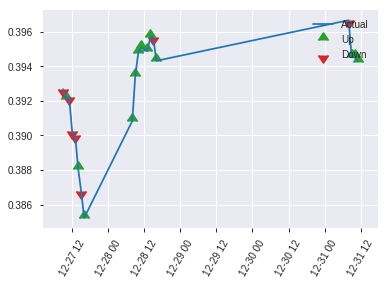


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19031186303514683
RMSE: 0.43624747911609396
LogLoss: 0.5617126761298058
Mean Per-Class Error: 0.27863802863802867
AUC: 0.7731435231435231
pr_auc: 0.6549411734098749
Gini: 0.5462870462870462
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40528303384780884: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      86   46   0.3485   (46.0/132.0)
1      19   72   0.2088   (19.0/91.0)
Total  105  118  0.2915   (65.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405283     0.688995  117
max f2                       0.194742     0.812274  189
max f0point5                 0.55186      0.671835  73
max accuracy                 0.55186      0.726457  73
max precision                0.833675     1         0
max recall                   0.12078      1         212
max specificity              0.833675     1         0
max absolute_mcc             0.405283     0.435918  117
max min_per_class_accuracy   0.444838     0.704545  103
max mean_per_class_accuracy  0.405283     0.721362  117

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 43.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.805548           1.6337    1.6337             0.666667         0.820399  0.666667                    0.820399            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.796887           2.45055   1.96044            1                0.800279  0.8                         0.812351            0.021978        0.043956                   145.055   96.044
    3        0.0313901                   0.778989           2.45055   2.10047            1                0.792389  0.857143                    0.806648            0.021978        0.0659341                  145.055   110.047
    4        0.0403587                   0.763834           0         1.6337             0                0.769262  0.666667                    0.79834             0               0.0659341                  -100      63.37
    5        0.0538117                   0.754843           1.6337    1.6337             0.666667         0.758644  0.666667                    0.788416            0.021978        0.0879121                  63.37     63.37
    6        0.103139                    0.73012            2.22777   1.91782            0.909091         0.743646  0.782609                    0.767004            0.10989         0.197802                   122.777   91.7821
    7        0.152466                    0.684045           1.33666   1.7298             0.545455         0.710817  0.705882                    0.748826            0.0659341       0.263736                   33.6663   72.98
    8        0.201794                    0.659442           1.78222   1.74261            0.727273         0.669811  0.711111                    0.729511            0.0879121       0.351648                   78.2218   74.2613
    9        0.300448                    0.57908            1.67083   1.71904            0.681818         0.61982   0.701493                    0.693493            0.164835        0.516484                   67.0829   71.9042
    10       0.399103                    0.501338           1.11389   1.56945            0.454545         0.53986   0.640449                    0.655516            0.10989         0.626374                   11.3886   56.9453
    11       0.502242                    0.422047           1.27855   1.50971            0.521739         0.456646  0.616071                    0.614677            0.131868        0.758242                   27.8548   50.9714
    12       0.600897                    0.356954           0.77972   1.38986            0.318182         0.387357  0.567164                    0.577356            0.0769231       0.835165                   -22.028   38.9864
    13       0.699552                    0.284176           0.556943  1.2724             0.227273         0.317654  0.519231                    0.540731            0.0549451       0.89011                    -44.3057  27.2401
    14       0.798206                    0.218523           0.668332  1.19774            0.272727         0.251943  0.488764                    0.505038            0.0659341       0.956044                   -33.1668  19.774
    15       0.896861                    0.160208           0.334166  1.10275            0.136364         0.194255  0.45                        0.470852            0.032967        0.989011                   -66.5834  10.2747
    16       1                           0.0830277          0.106546  1                  0.0434783        0.12215   0.408072                    0.434887            0.01098

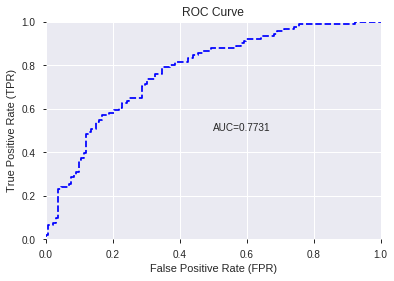

This function is available for GLM models only


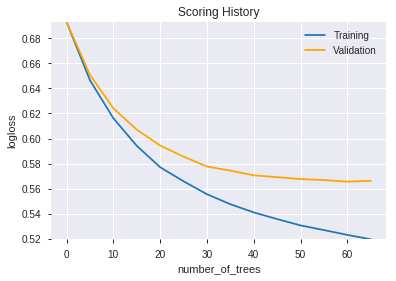

--2019-08-27 17:02:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_170236_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_170236_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'DIV',
 'hour',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'SUB',
 'SAREXT',
 'CORREL_24',
 'STOCH_slowd',
 'CORREL_14',
 'CORREL_12',
 'days_in_month',
 'CORREL_8',
 'HT_TRENDMODE']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12 13] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


44

['Volume',
 'hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_170306_model_7  0.793124  0.536677              0.252498  0.426539  0.181935
1  DeepLearning_grid_1_AutoML_20190827_170306_model_5  0.785631  0.544159              0.276931  0.430314  0.185170
2  DeepLearning_grid_1_AutoML_20190827_170306_model_3  0.785381  0.579020              0.277681  0.440491  0.194032
3  DeepLearning_grid_1_AutoML_20190827_170306_model_9  0.780636  0.561458              0.280511  0.433550  0.187966
4  DeepLearning_grid_1_AutoML_20190827_170306_model_6  0.774642  0.578117              0.287338  0.436822  0.190814
5  DeepLearning_grid_1_AutoML_20190827_170306_model_4  0.774143  0.638387              0.261780  0.458259  0.210001
6  DeepLearning_grid_1_AutoML_20190827_170306_model_8  0.771562  0.572682              0.289627  0.441850  0.195231
7  DeepLearning_grid_1_AutoML_20190827_170306_model_1  0.764319  0.723046              0.312895  0.476084  0.226656
8  DeepLearning_grid_1_AutoML_20190827_170306_model_2  0.755828  0.608643              0.326340  0.455409  0.207397
9               DeepLearning_1_AutoML_20190827_170306  0.746670  0.615325              0.353605  0.460713  0.212257

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.026959
1               TRANGE             0.898845           0.898845    0.024232
2                  SUB             0.895274           0.895274    0.024135
3          CDLLONGLINE             0.876628           0.876628    0.023633
4       STOCHRSI_fastk             0.872608           0.872608    0.023524
5                  DIV             0.872252           0.872252    0.023515
6               CMO_30             0.860529           0.860529    0.023199
7             WILLR_12             0.858906           0.858906    0.023155
8         CDLSHORTLINE             0.856506           0.856506    0.023090
9            CDLTAKURI             0.856436           0.856436    0.023088
10                hour             0.854391           0.854391    0.023033
11              RSI_30             0.853811           0.853811    0.023018
12    CDLDRAGONFLYDOJI             0.853429           0.853429    0.023007
13        CDLENGULFING             0.851926           0.851926    0.022967
14        STOCHF_fastk             0.850829           0.850829    0.022937
15               CCI_8             0.849222           0.849222    0.022894
16              CMO_20             0.846641           0.846641    0.022824
17            WILLR_24             0.845905           0.845905    0.022804
18            WILLR_20             0.845366           0.845366    0.022790
19           ROCR100_8             0.844985           0.844985    0.022780
20               ROC_8             0.841338           0.841338    0.022681
21              ROCR_8             0.841137           0.841137    0.022676
22              ROCP_8             0.840442           0.840442    0.022657
23            WILLR_30             0.839962           0.839962    0.022644
24  CDLCLOSINGMARUBOZU             0.839785           0.839785    0.022639
25              RSI_14             0.837894           0.837894    0.022589
26         CDLMARUBOZU             0.834294           0.834294    0.022491
27              CMO_14             0.834101           0.834101    0.022486
28               ADOSC             0.833605           0.833605    0.022473
29               RSI_8             0.831221           0.831221    0.022409
30          MINUS_DI_8             0.824291           0.824291    0.022222
31            WILLR_14             0.821903           0.821903    0.022157
32              Volume             0.821171           0.821171    0.022138
33         CDLBELTHOLD             0.820336           0.820336    0.022115
34              RSI_20             0.820001           0.820001    0.022106
35              RSI_24             0.819955           0.819955    0.022105
36              CMO_24             0.817721           0.817721    0.022045
37             WILLR_8             0.812810           0.812810    0.021912
38              CMO_12             0.810738           0.810738    0.021856
39              CCI_12             0.810049           0.810049    0.021838
40               CMO_8             0.808256           0.808256    0.021790
41              RSI_12             0.806730           0.806730    0.021748
42              ULTOSC             0.803633           0.803633    0.021665
43               MOM_8             0.777945           0.777945    0.020972

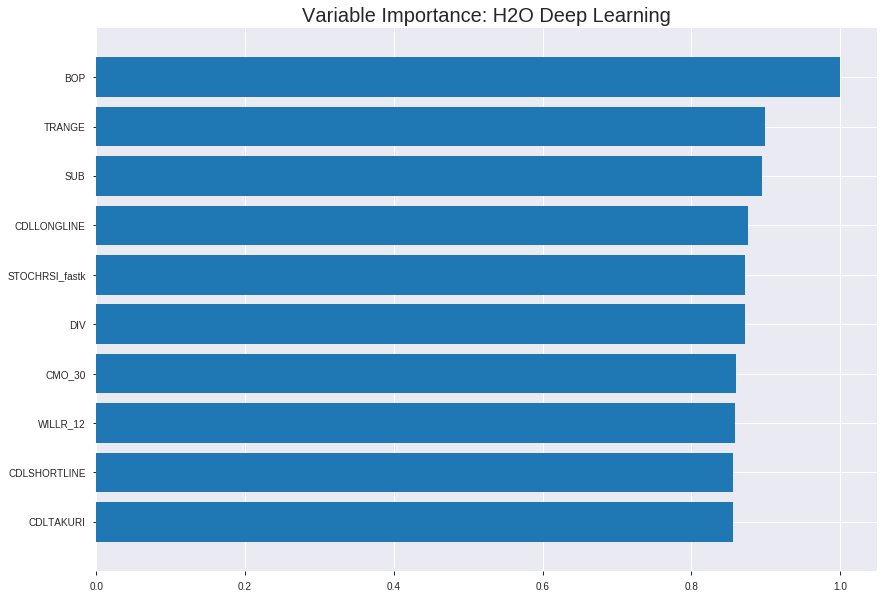

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_170306_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1911942459569274
RMSE: 0.43725764253689997
LogLoss: 0.5620851429431201
Mean Per-Class Error: 0.265999680804373
AUC: 0.7930714599209991
pr_auc: 0.7386085160355785
Gini: 0.5861429198419983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2989533747967686: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      514  338  0.3967   (338.0/852.0)
1      103  603  0.1459   (103.0/706.0)
Total  617  941  0.2831   (441.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.298953     0.73224   258
max f2                       0.084817     0.836957  354
max f0point5                 0.338715     0.68747   238
max accuracy                 0.338715     0.725931  238
max precision                0.986715     1         0
max recall                   0.00732237   1         395
max specificity              0.986715     1         0
max absolute_mcc             0.327093     0.469828  244
max min_per_class_accuracy   0.383605     0.712465  215
max mean_per_class_accuracy  0.327093     0.734     244

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 39.09 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.968148           2.2068     2.2068             1                0.975577   1                           0.975577            0.0226629       0.0226629                  120.68    120.68
    2        0.0205392                   0.954308           1.93095    2.06887            0.875            0.960571   0.9375                      0.968074            0.01983         0.0424929                  93.0949   106.887
    3        0.0301669                   0.940434           2.05968    2.06594            0.933333         0.946824   0.93617                     0.961292            0.01983         0.0623229                  105.968   106.594
    4        0.0404365                   0.929491           1.79302    1.99663            0.8125           0.934769   0.904762                    0.954556            0.0184136       0.0807365                  79.3024   99.6628
    5        0.0500642                   0.918695           2.2068     2.03705            1                0.925138   0.923077                    0.948899            0.0212465       0.101983                   120.68    103.705
    6        0.100128                    0.815187           1.64095    1.839              0.74359          0.868201   0.833333                    0.90855             0.082153        0.184136                   64.0953   83.8999
    7        0.150193                    0.702355           1.75412    1.81071            0.794872         0.757723   0.820513                    0.858274            0.0878187       0.271955                   75.4122   81.0707
    8        0.200257                    0.616512           1.66925    1.77534            0.75641          0.658958   0.804487                    0.808445            0.0835694       0.355524                   66.9245   77.5341
    9        0.300385                    0.508627           1.32974    1.62681            0.602564         0.560459   0.737179                    0.725783            0.133144        0.488669                   32.9738   62.6807
    10       0.399872                    0.438675           1.28137    1.54086            0.580645         0.474489   0.698234                    0.663262            0.127479        0.616147                   28.1367   54.0863
    11       0.5                         0.368037           1.24486    1.48159            0.564103         0.404284   0.671374                    0.6114              0.124646        0.740793                   24.4861   48.1586
    12       0.600128                    0.299406           1.08925    1.41613            0.49359          0.334027   0.641711                    0.565122            0.109065        0.849858                   8.92533   41.6128
    13       0.699615                    0.207368           0.541022   1.29169            0.245161         0.253998   0.585321                    0.520879            0.0538244       0.903683                   -45.8978  29.1686
    14       0.799743                    0.118426           0.565846   1.20081            0.25641          0.164707   0.544141                    0.476286            0.0566572       0.96034                    -43.4154  20.081
    15       0.899872                    0.0463562          0.311215   1.10183            0.141026         0.0803399  0.499287                    0.43223             0.0311615       0.991501                   -68.8785  10.1825
    16       1                           0.000168771        0.0848769  1                  0.0384615        0.0192358  0.453145   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17685716274332478
RMSE: 0.420543889199837
LogLoss: 0.5299596733022257
Mean Per-Class Error: 0.2510457677165354
AUC: 0.8143864829396326
pr_auc: 0.7302349656485799
Gini: 0.6287729658792651
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3569117086166457: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      181  73   0.2874   (73.0/254.0)
1      42   150  0.2188   (42.0/192.0)
Total  223  223  0.2578   (115.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356912     0.722892  201
max f2                       0.0692236    0.8283    354
max f0point5                 0.496988     0.722656  132
max accuracy                 0.36396      0.746637  193
max precision                0.981802     1         0
max recall                   0.0692236    1         354
max specificity              0.981802     1         0
max absolute_mcc             0.362558     0.493392  194
max min_per_class_accuracy   0.385373     0.739583  187
max mean_per_class_accuracy  0.362558     0.748954  194

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 39.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.97012            1.39375   1.39375            0.6              0.975404   0.6                         0.975404            0.015625        0.015625                   39.375    39.375
    2        0.0201794                   0.963041           2.32292   1.80671            1                0.966093   0.777778                    0.971266            0.0208333       0.0364583                  132.292   80.6713
    3        0.0313901                   0.946747           1.85833   1.82515            0.8              0.957872   0.785714                    0.966482            0.0208333       0.0572917                  85.8333   82.5149
    4        0.0403587                   0.927801           2.32292   1.93576            1                0.931955   0.833333                    0.95881             0.0208333       0.078125                   132.292   93.5764
    5        0.0515695                   0.904064           2.32292   2.01993            1                0.921393   0.869565                    0.950676            0.0260417       0.104167                   132.292   101.993
    6        0.100897                    0.818839           1.68939   1.85833            0.727273         0.857543   0.8                         0.905144            0.0833333       0.1875                     68.9394   85.8333
    7        0.150224                    0.743274           2.00616   1.90687            0.863636         0.785149   0.820896                    0.865743            0.0989583       0.286458                   100.616   90.6872
    8        0.201794                    0.648445           1.81793   1.88414            0.782609         0.699114   0.811111                    0.82316             0.09375         0.380208                   81.7935   88.4144
    9        0.300448                    0.509215           1.68939   1.8202             0.727273         0.572047   0.783582                    0.740705            0.166667        0.546875                   68.9394   82.0196
    10       0.401345                    0.43394            1.13565   1.6481             0.488889         0.472469   0.709497                    0.673271            0.114583        0.661458                   13.5648   64.8103
    11       0.5                         0.35581            1.21425   1.5625             0.522727         0.395582   0.672646                    0.61848             0.119792        0.78125                    21.4252   56.25
    12       0.600897                    0.290588           0.722685  1.42149            0.311111         0.324714   0.61194                     0.569154            0.0729167       0.854167                   -27.7315  42.1486
    13       0.699552                    0.204352           0.686316  1.31781            0.295455         0.25215    0.567308                    0.524448            0.0677083       0.921875                   -31.3684  31.7808
    14       0.800448                    0.126677           0.309722  1.19074            0.133333         0.168714   0.512605                    0.479608            0.03125         0.953125                   -69.0278  19.0739
    15       0.899103                    0.0382083          0.475142  1.11222            0.204545         0.0859785  0.478803                    0.436417            0.046875        1                          -52.4858  11.2219
    16       1                           5.48729e-05        0         1                  0                0.0166469  0.430493                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:07:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:07:35  5.698 sec         212 obs/sec       0.646341  1             1007       0.49324          0.931261            0.0182353      0.770339        0.65162            2.06887          0.324134                         0.488725           0.861768              0.025766         0.797521          0.734985             2.32292            0.257848
    2019-08-27 17:07:45  14.835 sec        393 obs/sec       3.28755   5             5122       0.437258         0.562085            0.228448       0.793071        0.738609           2.2068           0.283055                         0.420544           0.52996               0.278631         0.814386          0.730235             1.39375            0.257848
    2019-08-27 17:07:54  23.755 sec        483 obs/sec       6.53915   10            10188      0.436915         0.564844            0.229656       0.808656        0.756013           1.93095          0.295892                         0.449159           0.593953              0.177123         0.793891          0.712861             2.32292            0.295964
    2019-08-27 17:08:04  33.778 sec        535 obs/sec       10.3793   16            16171      0.427551         0.540931            0.262321       0.822015        0.763613           2.06887          0.277279                         0.446818           0.61708               0.185677         0.79057           0.68686              0.929167           0.32287
    2019-08-27 17:08:13  43.667 sec        568 obs/sec       14.3068   22            22290      0.419734         0.523378            0.289049       0.816704        0.767925           2.06887          0.278562                         0.440652           0.60418               0.207998         0.779835          0.668323             0.929167           0.338565
    2019-08-27 17:08:23  53.334 sec        591 obs/sec       18.2388   28            28416      0.419803         0.526835            0.288817       0.845125        0.811508           2.2068           0.250963                         0.465627           0.673258              0.115675         0.782121          0.6787               1.39375            0.300448
    2019-08-27 17:08:33  1 min  2.796 sec  608 obs/sec       22.1168   34            34458      0.446799         0.612284            0.194408       0.860979        0.828068           2.2068           0.231065                         0.483536           0.736859              0.046344         0.774063          0.668821             1.39375            0.311659
    2019-08-27 17:08:34  1 min  3.702 sec  608 obs/sec       22.1168   34            34458      0.437258         0.562085            0.228448       0.793071        0.738609           2.2068           0.283055                         0.420544           0.52996               0.278631         0.814386          0.730235             1.39375            0.257848

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
BOP             1.0                    1.0                  0.026958677787992817
TRANGE          0.8988454341888428     0.8988454341888428   0.024231684441505516
SUB             0.8952736258506775     0.8952736258506775   0.02413539321139645
CDLLONGLINE     0.8766284584999084     0.8766284584999084   0.023632744152483863
STOCHRSI_fastk  0.8726080656051636     0.8726080656051636   0.023524359675853302
---             ---                    ---                  ---
CCI_12          0.8100489974021912     0.8100489974021912   0.021837849913452303
CMO_8           0.8082562685012817     0.8082562685012817   0.021789520312651463
RSI_12          0.806729793548584      0.806729793548584    0.02174836856625024
ULTOSC          0.8036332130432129     0.8036332130432129   0.02166488885016136
MOM_8           0.7779449820518494     0.7779449820518494   0.020972368107921663


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7354260089686099)

('F1', 0.714975845410628)

('auc', 0.7931235431235432)

('logloss', 0.5366769201586079)

('mean_per_class_error', 0.25249750249750247)

('rmse', 0.42653865500317695)

('mse', 0.18193522421191918)

deeplearning prediction progress: |███████████████████████████████████████| 100%


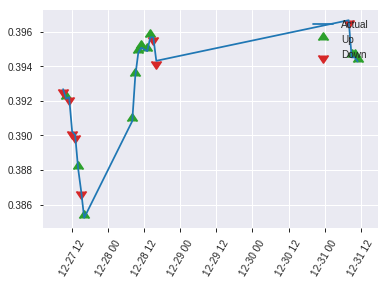


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18193522421191918
RMSE: 0.42653865500317695
LogLoss: 0.5366769201586079
Mean Per-Class Error: 0.25249750249750247
AUC: 0.7931235431235432
pr_auc: 0.7053055772971489
Gini: 0.5862470862470863
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37318825470692896: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   42   0.3182   (42.0/132.0)
1      17   74   0.1868   (17.0/91.0)
Total  107  116  0.2646   (59.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373188     0.714976  115
max f2                       0.141395     0.830258  177
max f0point5                 0.373188     0.666667  115
max accuracy                 0.373188     0.735426  115
max precision                0.979        1         0
max recall                   0.0526567    1         204
max specificity              0.979        1         0
max absolute_mcc             0.373188     0.486963  115
max min_per_class_accuracy   0.425876     0.712121  102
max mean_per_class_accuracy  0.373188     0.747502  115

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 40.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.966156           2.45055   2.45055            1                0.973804   1                           0.973804            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.956733           2.45055   2.45055            1                0.958597   1                           0.967721            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.946637           2.45055   2.45055            1                0.951656   1                           0.963131            0.021978        0.0769231                  145.055   145.055
    4        0.0403587                   0.941158           1.22527   2.17827            0.5              0.946116   0.888889                    0.95935             0.010989        0.0879121                  22.5275   117.827
    5        0.0538117                   0.920894           1.6337    2.04212            0.666667         0.930119   0.833333                    0.952042            0.021978        0.10989                    63.37     104.212
    6        0.103139                    0.784275           1.78222   1.91782            0.727273         0.839849   0.782609                    0.898385            0.0879121       0.197802                   78.2218   91.7821
    7        0.152466                    0.685148           2.22777   2.0181             0.909091         0.734042   0.823529                    0.845215            0.10989         0.307692                   122.777   101.81
    8        0.201794                    0.595037           1.33666   1.85153            0.545455         0.638606   0.755556                    0.794711            0.0659341       0.373626                   33.6663   85.1526
    9        0.300448                    0.511692           1.33666   1.68247            0.545455         0.55206    0.686567                    0.715034            0.131868        0.505495                   33.6663   68.2467
    10       0.399103                    0.466028           1.22527   1.56945            0.5              0.49106    0.640449                    0.65967             0.120879        0.626374                   22.5275   56.9453
    11       0.502242                    0.388142           1.49164   1.55347            0.608696         0.429782   0.633929                    0.612461            0.153846        0.78022                    49.1639   55.3473
    12       0.600897                    0.328758           0.668332  1.40815            0.272727         0.354725   0.574627                    0.570146            0.0659341       0.846154                   -33.1668  40.8152
    13       0.699552                    0.222481           0.668332  1.30382            0.272727         0.282455   0.532051                    0.529574            0.0659341       0.912088                   -33.1668  30.3818
    14       0.798206                    0.136638           0.77972   1.23904            0.318182         0.182919   0.505618                    0.486729            0.0769231       0.989011                   -22.028   23.9042
    15       0.896861                    0.0750347          0         1.10275            0                0.105446   0.45                        0.444788            0               0.989011                   -100      10.2747
    16       1                           0.000725261        0.106546  1                  0.0434783        0.0338484  0.408072                    

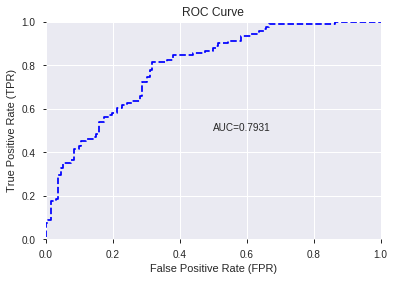

This function is available for GLM models only


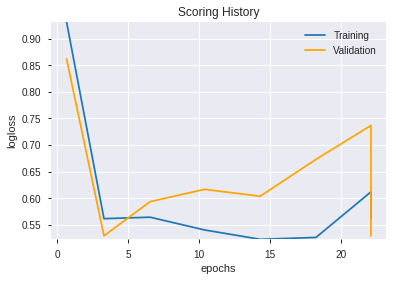

--2019-08-27 17:10:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_170306_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_170306_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'SUB',
 'CDLLONGLINE',
 'STOCHRSI_fastk',
 'DIV',
 'CMO_30',
 'WILLR_12',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'hour',
 'RSI_30',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'STOCHF_fastk',
 'CCI_8',
 'CMO_20',
 'WILLR_24',
 'WILLR_20',
 'ROCR100_8',
 'ROC_8',
 'ROCR_8',
 'ROCP_8',
 'WILLR_30',
 'CDLCLOSINGMARUBOZU',
 'RSI_14',
 'CDLMARUBOZU',
 'CMO_14',
 'ADOSC',
 'RSI_8',
 'MINUS_DI_8',
 'WILLR_14',
 'Volume',
 'CDLBELTHOLD',
 'RSI_20',
 'RSI_24',
 'CMO_24',
 'WILLR_8',
 'CMO_12',
 'CCI_12',
 'CMO_8',
 'RSI_12',
 'ULTOSC',
 'MOM_8']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_171100_model_1  0.785132  0.552898              0.292249  0.432581  0.187127

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.747642           1.000000    0.205168
1               TRANGE             0.239877           0.320845    0.065827
2          CDLMARUBOZU             0.190142           0.254322    0.052179
3                CCI_8             0.187444           0.250713    0.051438
4                  SUB             0.185886           0.248629    0.051011
5                  DIV             0.174450           0.233334    0.047873
6                 hour             0.165077           0.220797    0.045300
7         STOCHF_fastk             0.162891           0.217872    0.044700
8               CCI_12             0.148690           0.198878    0.040803
9               ULTOSC             0.142771           0.190961    0.039179
10      STOCHRSI_fastk             0.112127           0.149974    0.030770
11    CDLDRAGONFLYDOJI             0.099447           0.133014    0.027290
12           CDLTAKURI             0.099270           0.132777    0.027241
13            WILLR_24             0.092816           0.124144    0.025470
14          MINUS_DI_8             0.090097           0.120508    0.024724
15            WILLR_30             0.067081           0.089724    0.018408
16         CDLLONGLINE             0.065387           0.087458    0.017944
17            WILLR_14             0.061809           0.082672    0.016962
18              Volume             0.061511           0.082273    0.016880
19               ADOSC             0.056612           0.075720    0.015535
20  CDLCLOSINGMARUBOZU             0.052662           0.070438    0.014452
21            WILLR_12             0.052289           0.069939    0.014349
22            WILLR_20             0.052134           0.069732    0.014307
23             WILLR_8             0.049282           0.065916    0.013524
24        CDLENGULFING             0.037998           0.050824    0.010427
25        CDLSHORTLINE             0.028487           0.038102    0.007817
26               CMO_8             0.023182           0.031007    0.006362
27               RSI_8             0.021658           0.028969    0.005943
28         CDLBELTHOLD             0.019278           0.025786    0.005290
29              RSI_30             0.015063           0.020147    0.004134
30              CMO_30             0.014379           0.019233    0.003946
31               ROC_8             0.013145           0.017582    0.003607
32              ROCP_8             0.013100           0.017522    0.003595
33              ROCR_8             0.013084           0.017500    0.003590
34           ROCR100_8             0.013035           0.017434    0.003577
35              CMO_12             0.012686           0.016968    0.003481
36              RSI_12             0.012365           0.016539    0.003393
37              RSI_24             0.010274           0.013742    0.002819
38              CMO_24             0.009928           0.013280    0.002725
39              RSI_14             0.009370           0.012533    0.002571
40              CMO_14             0.008016           0.010722    0.002200
41               MOM_8             0.004986           0.006669    0.001368
42              CMO_20             0.003835           0.005130    0.001052
43              RSI_20             0.002794           0.003737    0.000767

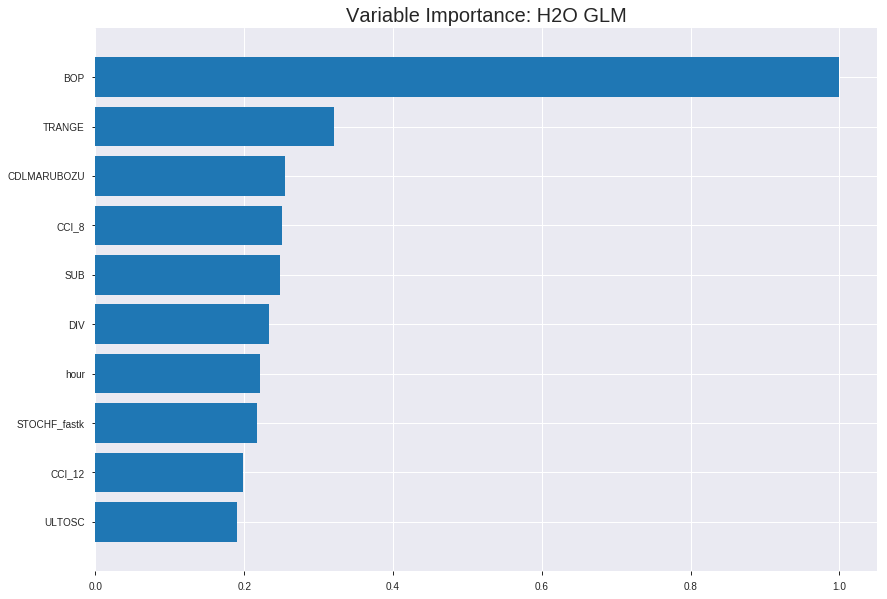

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_171100_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18777884578193857
RMSE: 0.43333456564407435
LogLoss: 0.5553644033278092
Null degrees of freedom: 1557
Residual degrees of freedom: 1513
Null deviance: 2146.1448765004316
Residual deviance: 1730.515480769454
AIC: 1820.515480769454
AUC: 0.7867291093112024
pr_auc: 0.7273617139268828
Gini: 0.5734582186224049
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3876126987252137: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      518  334  0.392    (334.0/852.0)
1      125  581  0.1771   (125.0/706.0)
Total  643  915  0.2946   (459.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387613     0.716841  229
max f2                       0.19325      0.830111  325
max f0point5                 0.491548     0.693739  175
max accuracy                 0.491548     0.722721  175
max precision                0.915246     1         0
max recall                   0.085821     1         376
max specificity              0.915246     1         0
max absolute_mcc             0.44984      0.448786  197
max min_per_class_accuracy   0.471695     0.720657  186
max mean_per_class_accuracy  0.44984      0.725362  197

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.858494           1.79302   1.79302            0.8125           0.868163  0.8125                      0.868163            0.0184136       0.0184136                  79.3024   79.3024
    2        0.0205392                   0.839836           2.06887   1.93095            0.9375           0.847587  0.875                       0.857875            0.0212465       0.0396601                  106.887   93.0949
    3        0.0301669                   0.826216           1.91256   1.92508            0.866667         0.834141  0.87234                     0.8503              0.0184136       0.0580737                  91.2559   92.508
    4        0.0404365                   0.80877            1.79302   1.89154            0.8125           0.816837  0.857143                    0.841802            0.0184136       0.0764873                  79.3024   89.1542
    5        0.0500642                   0.796723           1.76544   1.86729            0.8              0.801624  0.846154                    0.834075            0.0169972       0.0934844                  76.5439   86.7291
    6        0.100128                    0.754314           1.75412   1.81071            0.794872         0.773001  0.820513                    0.803538            0.0878187       0.181303                   75.4122   81.0707
    7        0.150193                    0.707194           1.69754   1.77298            0.769231         0.731589  0.803419                    0.779555            0.0849858       0.266289                   69.7538   77.2984
    8        0.200257                    0.675716           1.61266   1.7329             0.730769         0.693555  0.785256                    0.758055            0.0807365       0.347025                   61.2661   73.2903
    9        0.300385                    0.609935           1.57022   1.67868            0.711538         0.643697  0.760684                    0.719936            0.157224        0.504249                   57.0222   67.8676
    10       0.399872                    0.537888           1.22442   1.56566            0.554839         0.576841  0.70947                     0.684334            0.121813        0.626062                   22.4417   56.5658
    11       0.5                         0.454937           1.15998   1.48442            0.525641         0.496071  0.672657                    0.646633            0.116147        0.74221                    15.9984   48.4419
    12       0.600128                    0.375893           0.862915  1.38072            0.391026         0.414333  0.625668                    0.607875            0.0864023       0.828612                   -13.7085  38.0724
    13       0.699615                    0.299412           0.669158  1.27954            0.303226         0.334931  0.579817                    0.569062            0.0665722       0.895184                   -33.0842  27.9538
    14       0.799743                    0.223181           0.509261  1.1831             0.230769         0.259332  0.536116                    0.530283            0.0509915       0.946176                   -49.0739  18.3099
    15       0.899872                    0.155351           0.410238  1.0971             0.185897         0.189061  0.497147                    0.492316            0.0410765       0.987252                   -58.9762  9.71033
    16       1                           0.0013955          0.127315  1                  0.0576923        0.101112  0.453145                    0.453145          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.185119885553725
RMSE: 0.43025560490681003
LogLoss: 0.5492052041783322
Null degrees of freedom: 445
Residual degrees of freedom: 401
Null deviance: 610.5669311494817
Residual deviance: 489.89104212707235
AIC: 579.8910421270723
AUC: 0.7924151082677166
pr_auc: 0.7077724006511983
Gini: 0.5848302165354331
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3394782544544912: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      135  119  0.4685   (119.0/254.0)
1      23   169  0.1198   (23.0/192.0)
Total  158  288  0.3184   (142.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339478     0.704167  259
max f2                       0.223144     0.823063  326
max f0point5                 0.625598     0.711207  114
max accuracy                 0.625598     0.730942  114
max precision                0.877894     1         0
max recall                   0.140207     1         367
max specificity              0.877894     1         0
max absolute_mcc             0.625598     0.45017   114
max min_per_class_accuracy   0.481713     0.703125  181
max mean_per_class_accuracy  0.522699     0.719857  157

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 45.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.864162           2.32292   2.32292            1                0.871248  1                           0.871248            0.0260417       0.0260417                  132.292   132.292
    2        0.0201794                   0.843053           0.580729  1.54861            0.25             0.856841  0.666667                    0.864845            0.00520833      0.03125                    -41.9271  54.8611
    3        0.0313901                   0.830211           1.85833   1.65923            0.8              0.838447  0.714286                    0.855417            0.0208333       0.0520833                  85.8333   65.9226
    4        0.0403587                   0.81694            1.16146   1.54861            0.5              0.820461  0.666667                    0.847649            0.0104167       0.0625                     16.1458   54.8611
    5        0.0515695                   0.810492           2.32292   1.71694            1                0.813692  0.73913                     0.840267            0.0260417       0.0885417                  132.292   71.6938
    6        0.100897                    0.760676           2.11174   1.90995            0.909091         0.778155  0.822222                    0.809901            0.104167        0.192708                   111.174   90.9954
    7        0.150224                    0.722969           1.79498   1.8722             0.772727         0.741957  0.80597                     0.787591            0.0885417       0.28125                    79.4981   87.2201
    8        0.201794                    0.689841           1.81793   1.85833            0.782609         0.705923  0.8                         0.76672             0.09375         0.375                      81.7935   85.8333
    9        0.300448                    0.599954           1.53101   1.75086            0.659091         0.645482  0.753731                    0.726911            0.151042        0.526042                   53.1013   75.0855
    10       0.401345                    0.536473           1.18727   1.60917            0.511111         0.56461   0.692737                    0.686109            0.119792        0.645833                   18.7269   60.9171
    11       0.5                         0.459291           0.791903  1.44792            0.340909         0.492557  0.623318                    0.647919            0.078125        0.723958                   -20.8097  44.7917
    12       0.600897                    0.379801           1.08403   1.38682            0.466667         0.41907   0.597015                    0.609493            0.109375        0.833333                   8.40278   38.6816
    13       0.699552                    0.307586           0.791903  1.30292            0.340909         0.339625  0.560897                    0.571435            0.078125        0.911458                   -20.8097  30.2918
    14       0.800448                    0.229815           0.464583  1.19725            0.2              0.275183  0.515406                    0.534092            0.046875        0.958333                   -53.5417  19.7246
    15       0.899103                    0.168049           0.316761  1.10063            0.136364         0.204016  0.473815                    0.497874            0.03125         0.989583                   -68.3239  10.0634
    16       1                           0.00453878         0.103241  1                  0.0444444        0.109549  0.430493                    0.458694         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:11:00  0.000 sec   2            21        45            1.35536           1.34825
    2019-08-27 17:11:00  0.010 sec   4            13        45            1.34551           1.33866
    2019-08-27 17:11:00  0.021 sec   6            8         45            1.33277           1.32582
    2019-08-27 17:11:00  0.030 sec   8            4.9       45            1.31687           1.3091
    2019-08-27 17:11:00  0.040 sec   10           3.1       45            1.29759           1.28788
    2019-08-27 17:11:00  0.050 sec   12           1.9       45            1.27503           1.26204
    2019-08-27 17:11:00  0.061 sec   14           1.2       45            1.25              1.2326
    2019-08-27 17:11:00  0.071 sec   16           0.74      45            1.22414           1.20189
    2019-08-27 17:11:00  0.081 sec   18           0.46      45            1.19934           1.17285
    2019-08-27 17:11:00  0.091 sec   20           0.28      45            1.17696           1.1479
    2019-08-27 17:11:00  0.101 sec   22           0.18      45            1.15761           1.12827
    2019-08-27 17:11:00  0.113 sec   24           0.11      45            1.14135           1.11409
    2019-08-27 17:11:00  0.123 sec   26           0.068     45            1.12816           1.10488
    2019-08-27 17:11:00  0.134 sec   28           0.042     45            1.11802           1.09996
    2019-08-27 17:11:00  0.144 sec   30           0.026     45            1.11073           1.09841
    2019-08-27 17:11:00  0.154 sec   32           0.016     45            1.10582           1.09923
    2019-08-27 17:11:00  0.164 sec   34           0.01      45            1.10267           1.10145
    2019-08-27 17:11:00  0.178 sec   36           0.0063    45            1.10069           1.10422
    2019-08-27 17:11:00  0.191 sec   38           0.0039    45            1.09943           1.10692
    2019-08-27 17:11:00  0.201 sec   40           0.0024    45            1.09864           1.10908

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726457399103139)

('F1', 0.6942148760330578)

('auc', 0.7851315351315352)

('logloss', 0.5528982600128378)

('mean_per_class_error', 0.28979353979353983)

('rmse', 0.43258136105201483)

('mse', 0.1871266339296136)

glm prediction progress: |████████████████████████████████████████████████| 100%


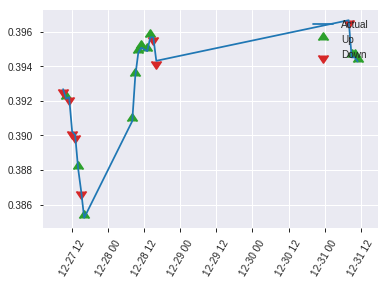


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1871266339296136
RMSE: 0.43258136105201483
LogLoss: 0.5528982600128378
Null degrees of freedom: 222
Residual degrees of freedom: 178
Null deviance: 303.40375268137996
Residual deviance: 246.59262396572564
AIC: 336.59262396572564
AUC: 0.7851315351315352
pr_auc: 0.6835041873409329
Gini: 0.5702630702630704
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33383184506380553: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   67   0.5076   (67.0/132.0)
1      7    84   0.0769   (7.0/91.0)
Total  72   151  0.3318   (74.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333832     0.694215  150
max f2                       0.245575     0.822551  176
max f0point5                 0.622248     0.68254   55
max accuracy                 0.622248     0.726457  55
max precision                0.876706     1         0
max recall                   0.173036     1         205
max specificity              0.876706     1         0
max absolute_mcc             0.333832     0.436742  150
max min_per_class_accuracy   0.486561     0.692308  98
max mean_per_class_accuracy  0.343872     0.710206  142

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 44.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.847046           1.6337    1.6337             0.666667         0.858343  0.666667                    0.858343            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.830985           2.45055   1.96044            1                0.838113  0.8                         0.850251            0.021978        0.043956                   145.055   96.044
    3        0.0313901                   0.804335           2.45055   2.10047            1                0.825453  0.857143                    0.843166            0.021978        0.0659341                  145.055   110.047
    4        0.0403587                   0.792326           2.45055   2.17827            1                0.795926  0.888889                    0.832668            0.021978        0.0879121                  145.055   117.827
    5        0.0538117                   0.774912           1.6337    2.04212            0.666667         0.783676  0.833333                    0.82042             0.021978        0.10989                    63.37     104.212
    6        0.103139                    0.720507           2.005     2.02437            0.818182         0.740934  0.826087                    0.782405            0.0989011       0.208791                   100.5     102.437
    7        0.152466                    0.689909           1.33666   1.80187            0.545455         0.706294  0.735294                    0.757781            0.0659341       0.274725                   33.6663   80.1875
    8        0.201794                    0.667697           2.005     1.85153            0.818182         0.677746  0.755556                    0.738217            0.0989011       0.373626                   100.5     85.1526
    9        0.300448                    0.59436            1.44805   1.71904            0.590909         0.627287  0.701493                    0.701792            0.142857        0.516484                   44.8052   71.9042
    10       0.399103                    0.50757            1.11389   1.56945            0.454545         0.552273  0.640449                    0.664832            0.10989         0.626374                   11.3886   56.9453
    11       0.502242                    0.442625           0.958911  1.44407            0.391304         0.477678  0.589286                    0.626399            0.0989011       0.725275                   -4.10893  44.4074
    12       0.600897                    0.367438           1.11389   1.38986            0.454545         0.398703  0.567164                    0.589016            0.10989         0.835165                   11.3886   38.9864
    13       0.699552                    0.314588           0.891109  1.31953            0.363636         0.34345   0.538462                    0.554385            0.0879121       0.923077                   -10.8891  31.9527
    14       0.798206                    0.243459           0.556943  1.22527            0.227273         0.272816  0.5                         0.519584            0.0549451       0.978022                   -44.3057  22.5275
    15       0.896861                    0.191647           0.111389  1.10275            0.0454545        0.210734  0.45                        0.485611            0.010989        0.989011                   -88.8611  10.2747
    16       1                           0.0223464          0.106546  1                  0.0434783        0.125544  0.408072                    0.448474            

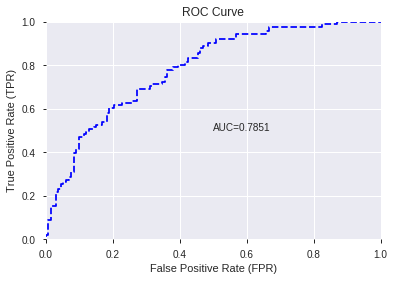

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


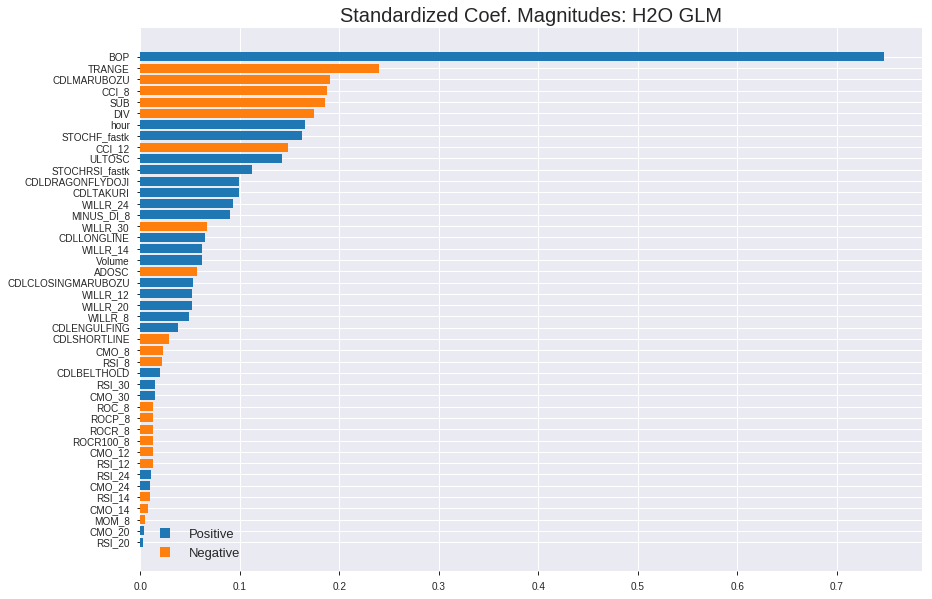

'log_likelihood'
--2019-08-27 17:11:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_171100_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_171100_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'TRANGE',
 'CDLMARUBOZU',
 'CCI_8',
 'SUB',
 'DIV',
 'hour',
 'STOCHF_fastk',
 'CCI_12',
 'ULTOSC',
 'STOCHRSI_fastk',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'WILLR_24',
 'MINUS_DI_8',
 'WILLR_30',
 'CDLLONGLINE',
 'WILLR_14',
 'Volume',
 'ADOSC',
 'CDLCLOSINGMARUBOZU',
 'WILLR_12',
 'WILLR_20',
 'WILLR_8',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'CMO_8',
 'RSI_8',
 'CDLBELTHOLD',
 'RSI_30',
 'CMO_30',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'CMO_12',
 'RSI_12',
 'RSI_24',
 'CMO_24',
 'RSI_14',
 'CMO_14',
 'MOM_8',
 'CMO_20',
 'RSI_20']

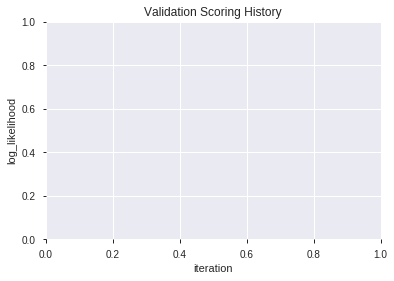

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_171110_model_1  0.800783  0.540443              0.245879  0.424981  0.180609
1  XGBoost_grid_1_AutoML_20190827_171110_model_2  0.779970  0.559943              0.259699  0.434152  0.188488
2  XGBoost_grid_1_AutoML_20190827_171110_model_7  0.779887  0.560249              0.264819  0.433815  0.188196
3  XGBoost_grid_1_AutoML_20190827_171110_model_6  0.779304  0.559898              0.256660  0.435041  0.189261
4  XGBoost_grid_1_AutoML_20190827_171110_model_4  0.777389  0.560646              0.279970  0.435225  0.189421
5               XGBoost_1_AutoML_20190827_171110  0.776057  0.557328              0.264277  0.433941  0.188304
6               XGBoost_2_AutoML_20190827_171110  0.771229  0.569007              0.274850  0.439582  0.193232
7               XGBoost_3_AutoML_20190827_171110  0.769231  0.569646              0.271645  0.439135  0.192840
8  XGBoost_grid_1_AutoML_20190827_171110_model_3  0.768648  0.567077              0.304196  0.438730  0.192484
9  XGBoost_grid_1_AutoML_20190827_171110_model_5  0.749750  0.585653              0.330711  0.447986  0.200691

variable  relative_importance  scaled_importance  percentage
0                  BOP          3031.204102           1.000000    0.342906
1               TRANGE           653.382019           0.215552    0.073914
2                  DIV           649.924988           0.214411    0.073523
3                CCI_8           630.627258           0.208045    0.071340
4         STOCHF_fastk           441.855377           0.145769    0.049985
5                 hour           352.680542           0.116350    0.039897
6       STOCHRSI_fastk           343.540192           0.113335    0.038863
7             WILLR_12           258.476379           0.085272    0.029240
8               ULTOSC           229.270706           0.075637    0.025936
9                  SUB           169.204636           0.055821    0.019141
10              Volume           159.545975           0.052635    0.018049
11             WILLR_8           152.670547           0.050366    0.017271
12              CCI_12           143.437454           0.047320    0.016226
13               ROC_8           135.825714           0.044809    0.015365
14              CMO_14           134.605850           0.044407    0.015227
15               ADOSC           125.639893           0.041449    0.014213
16          MINUS_DI_8           120.420624           0.039727    0.013623
17            WILLR_14           111.261208           0.036705    0.012586
18               CMO_8           110.167290           0.036344    0.012463
19              CMO_30           106.879860           0.035260    0.012091
20            WILLR_24           105.236984           0.034718    0.011905
21            WILLR_30            96.704193           0.031903    0.010940
22    CDLDRAGONFLYDOJI            82.415192           0.027189    0.009323
23               MOM_8            80.731911           0.026634    0.009133
24              CMO_24            60.330326           0.019903    0.006825
25              CMO_12            54.664463           0.018034    0.006184
26            WILLR_20            46.739876           0.015420    0.005287
27              CMO_20            46.372196           0.015298    0.005246
28              RSI_24            43.723938           0.014425    0.004946
29              RSI_14            33.875786           0.011176    0.003832
30         CDLLONGLINE            26.911041           0.008878    0.003044
31              RSI_30            20.110462           0.006634    0.002275
32              ROCP_8            17.646725           0.005822    0.001996
33  CDLCLOSINGMARUBOZU            13.931995           0.004596    0.001576
34        CDLSHORTLINE            11.860384           0.003913    0.001342
35              RSI_20            11.105359           0.003664    0.001256
36               RSI_8             9.938187           0.003279    0.001124
37              RSI_12             4.591412           0.001515    0.000519
38              ROCR_8             4.339700           0.001432    0.000491
39           CDLTAKURI             4.313469           0.001423    0.000488
40         CDLMARUBOZU             3.579354           0.001181    0.000405

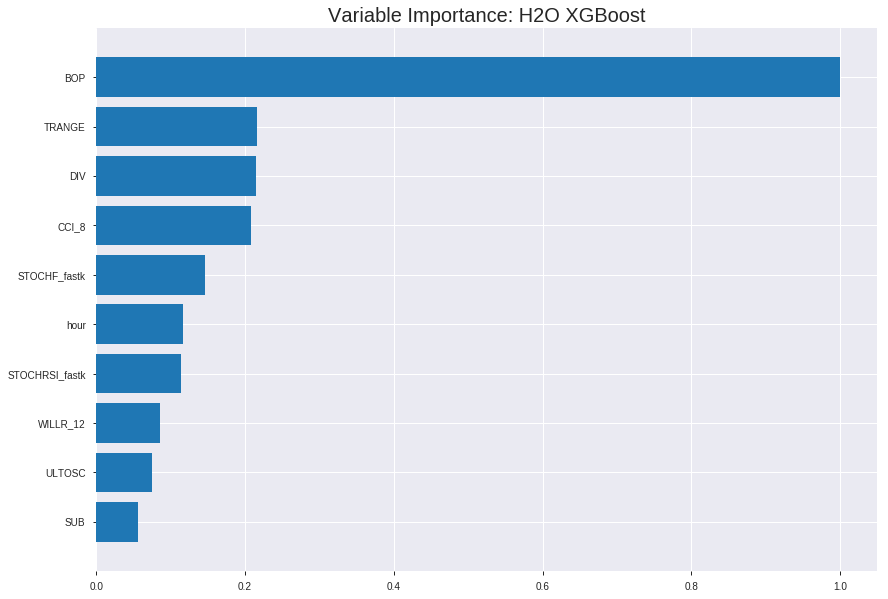

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_171110_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12737245292094557
RMSE: 0.35689277510331524
LogLoss: 0.4123344343156311
Mean Per-Class Error: 0.16206492971046305
AUC: 0.9239001050685606
pr_auc: 0.9176207738685467
Gini: 0.8478002101371211
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4871032138665517: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      701  151  0.1772   (151.0/852.0)
1      109  597  0.1544   (109.0/706.0)
Total  810  748  0.1669   (260.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487103     0.821183  193
max f2                       0.283449     0.881443  278
max f0point5                 0.643107     0.860153  125
max accuracy                 0.539228     0.841463  168
max precision                0.913956     1         0
max recall                   0.189967     1         322
max specificity              0.913956     1         0
max absolute_mcc             0.539228     0.679955  168
max min_per_class_accuracy   0.499396     0.833333  188
max mean_per_class_accuracy  0.5275       0.837935  175

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.883916           2.2068    2.2068             1                0.895114   1                           0.895114            0.0226629       0.0226629                  120.68    120.68
    2        0.0205392                   0.861271           2.2068    2.2068             1                0.872474   1                           0.883794            0.0226629       0.0453258                  120.68    120.68
    3        0.0301669                   0.851581           2.2068    2.2068             1                0.856369   1                           0.875041            0.0212465       0.0665722                  120.68    120.68
    4        0.0404365                   0.838572           2.2068    2.2068             1                0.845631   1                           0.867572            0.0226629       0.0892351                  120.68    120.68
    5        0.0500642                   0.831194           2.2068    2.2068             1                0.834095   1                           0.861134            0.0212465       0.110482                   120.68    120.68
    6        0.100128                    0.793336           2.2068    2.2068             1                0.81359    1                           0.837362            0.110482        0.220963                   120.68    120.68
    7        0.150193                    0.759371           2.17851   2.19737            0.987179         0.776486   0.995726                    0.81707             0.109065        0.330028                   117.851   119.737
    8        0.200257                    0.717759           2.12192   2.17851            0.961538         0.739975   0.987179                    0.797796            0.106232        0.436261                   112.192   117.851
    9        0.300385                    0.646415           1.90973   2.08891            0.865385         0.681163   0.946581                    0.758918            0.191218        0.627479                   90.973    108.891
    10       0.399872                    0.549014           1.36679   1.90925            0.619355         0.601588   0.865169                    0.719775            0.135977        0.763456                   36.6792   90.9253
    11       0.5                         0.466786           0.933646  1.71388            0.423077         0.510736   0.776637                    0.677914            0.0934844       0.856941                   -6.63543  71.3881
    12       0.600128                    0.360264           0.721453  1.5483             0.326923         0.41626    0.701604                    0.634258            0.072238        0.929178                   -27.8547  54.83
    13       0.699615                    0.257464           0.455597  1.39292            0.206452         0.310177   0.631193                    0.588173            0.0453258       0.974504                   -54.4403  39.2915
    14       0.799743                    0.180782           0.254631  1.2504             0.115385         0.218268   0.566613                    0.541861            0.0254958       1                          -74.5369  25.0401
    15       0.899872                    0.102451           0         1.11127            0                0.142223   0.503566                    0.497393            0               1                          -100      11.127
    16       1                           0.0303829          0         1                  0                0.0689711  0.453145                    0.454496



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18524329891146535
RMSE: 0.4303989996636439
LogLoss: 0.5463631450493565
Mean Per-Class Error: 0.2778461286089239
AUC: 0.7894520997375328
pr_auc: 0.7145933342584794
Gini: 0.5789041994750657
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3001096248626709: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      135  119  0.4685   (119.0/254.0)
1      22   170  0.1146   (22.0/192.0)
Total  157  289  0.3161   (141.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.30011      0.706861  259
max f2                       0.2086       0.821364  310
max f0point5                 0.628498     0.696023  113
max accuracy                 0.531988     0.724215  167
max precision                0.893392     1         0
max recall                   0.0694724    1         374
max specificity              0.893392     1         0
max absolute_mcc             0.480225     0.440153  191
max min_per_class_accuracy   0.495701     0.712598  185
max mean_per_class_accuracy  0.480225     0.722154  191

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 44.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.856219           2.32292   2.32292            1                0.872318   1                           0.872318            0.0260417       0.0260417                  132.292   132.292
    2        0.0201794                   0.828341           1.74219   2.06481            0.75             0.847477   0.888889                    0.861278            0.015625        0.0416667                  74.2188   106.481
    3        0.0313901                   0.81469            1.85833   1.99107            0.8              0.822605   0.857143                    0.847466            0.0208333       0.0625                     85.8333   99.1071
    4        0.0403587                   0.804705           1.74219   1.93576            0.75             0.80897    0.833333                    0.838912            0.015625        0.078125                   74.2188   93.5764
    5        0.0515695                   0.795566           1.85833   1.91893            0.8              0.801966   0.826087                    0.83088             0.0208333       0.0989583                  85.8333   91.8931
    6        0.100897                    0.765695           1.79498   1.85833            0.772727         0.77835    0.8                         0.805198            0.0885417       0.1875                     79.4981   85.8333
    7        0.150224                    0.731351           2.00616   1.90687            0.863636         0.745845   0.820896                    0.785709            0.0989583       0.286458                   100.616   90.6872
    8        0.201794                    0.694135           1.31295   1.75509            0.565217         0.709707   0.755556                    0.766286            0.0677083       0.354167                   31.2953   75.5093
    9        0.300448                    0.623034           1.68939   1.73352            0.727273         0.657922   0.746269                    0.730704            0.166667        0.520833                   68.9394   73.352
    10       0.401345                    0.543729           1.18727   1.59619            0.511111         0.585694   0.687151                    0.694249            0.119792        0.640625                   18.7269   59.6194
    11       0.5                         0.463242           1.05587   1.48958            0.454545         0.50915    0.641256                    0.657727            0.104167        0.744792                   5.58712   48.9583
    12       0.600897                    0.365285           0.774306  1.36948            0.333333         0.414293   0.589552                    0.616852            0.078125        0.822917                   -22.5694  36.9481
    13       0.699552                    0.267752           0.897491  1.30292            0.386364         0.307111   0.560897                    0.573171            0.0885417       0.911458                   -10.2509  30.2918
    14       0.800448                    0.177286           0.464583  1.19725            0.2              0.226467   0.515406                    0.529468            0.046875        0.958333                   -53.5417  19.7246
    15       0.899103                    0.101091           0.263968  1.09484            0.113636         0.141246   0.471322                    0.48687             0.0260417       0.984375                   -73.6032  9.4841
    16       1                           0.0267828          0.154861  1                  0.0666667        0.0624644  0.430493                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:11:16  0.025 sec   0                  0.5              0.693147            0.5             0                  1                0.546855                         0.5                0.693147              0.5               0                    1                  0.569507
    2019-08-27 17:11:16  0.151 sec   5                  0.466802         0.628422            0.850968        0.826282           2.2068           0.256098                         0.474979           0.643952              0.779579          0.710646             1.85833            0.302691
    2019-08-27 17:11:16  0.218 sec   10                 0.443497         0.583832            0.861415        0.84085            2.2068           0.247112                         0.459673           0.613731              0.780584          0.719656             2.32292            0.286996
    2019-08-27 17:11:16  0.296 sec   15                 0.426253         0.550511            0.871934        0.852885           2.2068           0.240693                         0.448895           0.591757              0.786264          0.735032             2.32292            0.309417
    2019-08-27 17:11:16  0.361 sec   20                 0.412449         0.52348             0.880861        0.863244           2.2068           0.212452                         0.442298           0.577665              0.789903          0.732307             2.32292            0.278027
    2019-08-27 17:11:16  0.425 sec   25                 0.402332         0.502991            0.886864        0.871981           2.2068           0.206675                         0.438573           0.568974              0.789247          0.727009             2.32292            0.282511
    2019-08-27 17:11:16  0.490 sec   30                 0.39365          0.485223            0.892827        0.879432           2.2068           0.200257                         0.435074           0.560967              0.791257          0.718646             1.85833            0.280269
    2019-08-27 17:11:16  0.554 sec   35                 0.386879         0.471338            0.897759        0.886088           2.2068           0.191913                         0.434116           0.557894              0.787637          0.718448             2.32292            0.331839
    2019-08-27 17:11:16  0.617 sec   40                 0.380889         0.459066            0.901784        0.889319           2.2068           0.189345                         0.432068           0.553107              0.790416          0.719578             1.85833            0.32287
    2019-08-27 17:11:17  0.686 sec   45                 0.376624         0.450025            0.904368        0.894255           2.2068           0.182285                         0.431437           0.551054              0.790201          0.717582             1.85833            0.32287
    2019-08-27 17:11:17  0.757 sec   50                 0.372353         0.441608            0.908528        0.898121           2.2068           0.17715                          0.431295           0.55002               0.789883          0.719579             2.32292            0.316143
    2019-08-27 17:11:17  0.817 sec   55                 0.368286         0.433532            0.91177         0.903167           2.2068           0.172015                         0.430215           0.547342              0.791544          0.7

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           3031.2041015625        1.0                    0.3429063387416179
TRANGE        653.3820190429688      0.215551971147759      0.0739141372348169
DIV           649.9249877929688      0.2144114899613493     0.07352305900678145
CCI_8         630.6272583007812      0.2080451322877634     0.0713399946058125
STOCHF_fastk  441.8553771972656      0.1457689295714207     0.04998508994162063
---           ---                    ---                    ---
RSI_8         9.938186645507812      0.003278626681847309   0.00112426187157284
RSI_12        4.591411590576172      0.001514715418935145   0.0005194055185425265
ROCR_8        4.339699745178223      0.00143167520225419    0.0004909305018721496
CDLTAKURI     4.313469409942627      0.0014230217647565057  0.00048796318330228926
CDLMARUBOZU   3.5793540477752686     0.00118083571011606    0.00040491605001125665


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.757847533632287)

('F1', 0.7150259067357514)

('auc', 0.8007825507825508)

('logloss', 0.5404426385814961)

('mean_per_class_error', 0.2458791208791209)

('rmse', 0.42498102984673153)

('mse', 0.18060887572958853)

xgboost prediction progress: |████████████████████████████████████████████| 100%


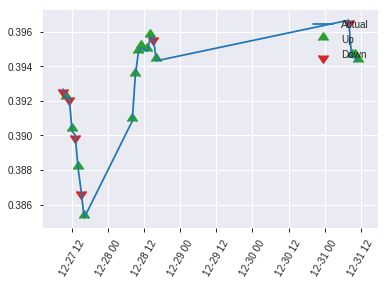


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18060887572958853
RMSE: 0.42498102984673153
LogLoss: 0.5404426385814961
Mean Per-Class Error: 0.2458791208791209
AUC: 0.8007825507825508
pr_auc: 0.7219883757502512
Gini: 0.6015651015651016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4726756513118744: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      99   33   0.25     (33.0/132.0)
1      22   69   0.2418   (22.0/91.0)
Total  121  102  0.2466   (55.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472676     0.715026  101
max f2                       0.203145     0.804388  182
max f0point5                 0.557147     0.714286  76
max accuracy                 0.557147     0.757848  76
max precision                0.867588     1         0
max recall                   0.0753859    1         213
max specificity              0.867588     1         0
max absolute_mcc             0.472676     0.501401  101
max min_per_class_accuracy   0.472676     0.75      101
max mean_per_class_accuracy  0.472676     0.754121  101

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 44.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.854594           2.45055   2.45055            1                0.86027    1                           0.86027             0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.850792           2.45055   2.45055            1                0.853366   1                           0.857508            0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.837462           1.22527   2.10047            0.5              0.843342   0.857143                    0.853461            0.010989        0.0659341                  22.5275   110.047
    4        0.0403587                   0.824955           2.45055   2.17827            1                0.833531   0.888889                    0.849032            0.021978        0.0879121                  145.055   117.827
    5        0.0538117                   0.820549           2.45055   2.24634            1                0.822423   0.916667                    0.84238             0.032967        0.120879                   145.055   124.634
    6        0.103139                    0.74979            1.78222   2.02437            0.727273         0.791201   0.826087                    0.817903            0.0879121       0.208791                   78.2218   102.437
    7        0.152466                    0.69433            1.78222   1.94602            0.727273         0.72713    0.794118                    0.788535            0.0879121       0.296703                   78.2218   94.6025
    8        0.201794                    0.661261           1.55944   1.85153            0.636364         0.676425   0.755556                    0.76113             0.0769231       0.373626                   55.9441   85.1526
    9        0.300448                    0.593009           1.78222   1.82877            0.727273         0.618339   0.746269                    0.714244            0.175824        0.549451                   78.2218   82.8768
    10       0.399103                    0.520067           1.33666   1.70712            0.545455         0.552365   0.696629                    0.674229            0.131868        0.681319                   33.6663   70.7124
    11       0.502242                    0.443535           0.852365  1.53159            0.347826         0.478009   0.625                       0.633934            0.0879121       0.769231                   -14.7635  53.1593
    12       0.600897                    0.370099           0.77972   1.40815            0.318182         0.405649   0.574627                    0.596454            0.0769231       0.846154                   -22.028   40.8152
    13       0.699552                    0.3135             0.445554  1.2724             0.181818         0.344124   0.519231                    0.560869            0.043956        0.89011                    -55.4446  27.2401
    14       0.798206                    0.223015           0.668332  1.19774            0.272727         0.265849   0.488764                    0.524406            0.0659341       0.956044                   -33.1668  19.774
    15       0.896861                    0.13413            0.222777  1.09049            0.0909091        0.179165   0.445                       0.486429            0.021978        0.978022                   -77.7223  9.04945
    16       1                           0.0282507          0.213091  1                  0.0869565        0.0814593  0.408072                    

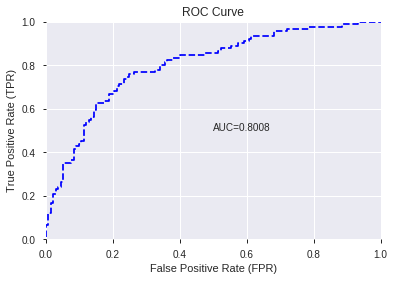

This function is available for GLM models only


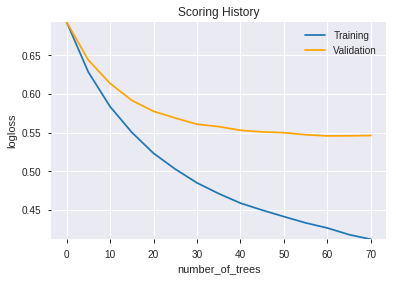

--2019-08-27 17:11:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_171110_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_171110_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'DIV',
 'CCI_8',
 'STOCHF_fastk',
 'hour',
 'STOCHRSI_fastk',
 'WILLR_12',
 'ULTOSC',
 'SUB',
 'Volume',
 'WILLR_8',
 'CCI_12',
 'ROC_8',
 'CMO_14',
 'ADOSC',
 'MINUS_DI_8',
 'WILLR_14',
 'CMO_8',
 'CMO_30',
 'WILLR_24',
 'WILLR_30',
 'CDLDRAGONFLYDOJI',
 'MOM_8',
 'CMO_24',
 'CMO_12',
 'WILLR_20',
 'CMO_20',
 'RSI_24',
 'RSI_14',
 'CDLLONGLINE',
 'RSI_30',
 'ROCP_8',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'RSI_20',
 'RSI_8',
 'RSI_12',
 'ROCR_8',
 'CDLTAKURI',
 'CDLMARUBOZU']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

52

['TRIMA_20',
 'BOP',
 'ADX_8',
 'AROONOSC_8',
 'MOM_8',
 'ROCP_8',
 'ROCR_8',
 'WILLR_8',
 'ADXR_12',
 'aroonup_12',
 'CCI_12',
 'MOM_12',
 'PLUS_DI_12',
 'ROCP_12',
 'ROCR_12',
 'WILLR_12',
 'aroondown_14',
 'ROC_14',
 'RSI_14',
 'WILLR_14',
 'aroonup_20',
 'MACDFIX_20',
 'MFI_20',
 'PLUS_DM_20',
 'ROC_20',
 'ROCR_20',
 'aroonup_24',
 'DX_24',
 'MACDFIX_signal_24',
 'ROCP_24',
 'AROONOSC_30',
 'DX_30',
 'ROCR_30',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ATR_12',
 'NATR_14',
 'NATR_20',
 'TRANGE',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'CDLSHORTLINE',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'BETA_12',
 'LINEARREG_12',
 'LINEARREG_ANGLE_12',
 'BETA_14',
 'STDDEV_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_171254_model_8  0.781052  0.567678              0.315351  0.439154  0.192856
1  DeepLearning_grid_1_AutoML_20190827_171254_model_3  0.777806  0.569231              0.281469  0.441211  0.194668
2  DeepLearning_grid_1_AutoML_20190827_171254_model_9  0.774892  0.564821              0.292083  0.440476  0.194019
3  DeepLearning_grid_1_AutoML_20190827_171254_model_6  0.768898  0.560756              0.279221  0.436502  0.190534
4  DeepLearning_grid_1_AutoML_20190827_171254_model_5  0.762737  0.580436              0.305153  0.445104  0.198117
5  DeepLearning_grid_1_AutoML_20190827_171254_model_7  0.746836  0.703578              0.282801  0.477080  0.227605
6               DeepLearning_1_AutoML_20190827_171254  0.738262  0.629120              0.285465  0.467692  0.218735
7  DeepLearning_grid_1_AutoML_20190827_171254_model_2  0.727772  0.874058              0.321429  0.509117  0.259200
8  DeepLearning_grid_1_AutoML_20190827_171254_model_4  0.714785  0.680279              0.399434  0.477942  0.228428
9  DeepLearning_grid_1_AutoML_20190827_171254_model_1  0.645355  1.092358              0.396229  0.555274  0.308329

variable  relative_importance  scaled_importance  percentage
0                 TRANGE             1.000000           1.000000    0.055036
1                    BOP             0.887020           0.887020    0.048818
2           STOCHF_fastk             0.413069           0.413069    0.022734
3                  ADX_8             0.406914           0.406914    0.022395
4                 MFI_20             0.395756           0.395756    0.021781
5                 BETA_8             0.390935           0.390935    0.021515
6               TRIMA_20             0.362445           0.362445    0.019947
7            HT_DCPERIOD             0.360879           0.360879    0.019861
8             aroonup_24             0.360463           0.360463    0.019838
9            STOCH_slowd             0.356471           0.356471    0.019619
10            PLUS_DI_12             0.355484           0.355484    0.019564
11               BETA_14             0.354107           0.354107    0.019489
12        STOCHRSI_fastk             0.352398           0.352398    0.019394
13          LINEARREG_12             0.351393           0.351393    0.019339
14           AROONOSC_30             0.348219           0.348219    0.019164
15             STDDEV_14             0.347035           0.347035    0.019099
16            aroonup_20             0.345025           0.345025    0.018989
17               WILLR_8             0.342126           0.342126    0.018829
18                 DX_24             0.340824           0.340824    0.018757
19               ADXR_12             0.340408           0.340408    0.018735
20               BETA_12             0.339220           0.339220    0.018669
21                 DX_30             0.335873           0.335873    0.018485
22          aroondown_14             0.334995           0.334995    0.018437
23            AROONOSC_8             0.329097           0.329097    0.018112
24            aroonup_12             0.327426           0.327426    0.018020
25        STOCHRSI_fastd             0.326832           0.326832    0.017987
26  HT_PHASOR_quadrature             0.322913           0.322913    0.017772
27               NATR_14             0.322732           0.322732    0.017762
28                ATR_12             0.322189           0.322189    0.017732
29                CCI_12             0.320365           0.320365    0.017631
30          CDLSHORTLINE             0.318857           0.318857    0.017549
31               NATR_20             0.318718           0.318718    0.017541
32     MACDFIX_signal_24             0.316810           0.316810    0.017436
33          STOCHF_fastd             0.308964           0.308964    0.017004
34            PLUS_DM_20             0.305579           0.305579    0.016818
35              WILLR_12             0.302488           0.302488    0.016648
36    LINEARREG_ANGLE_12             0.301930           0.301930    0.016617
37                ROCP_8             0.300821           0.300821    0.016556
38                ROC_14             0.300055           0.300055    0.016514
39                 MOM_8             0.295494           0.295494    0.016263
40     LINEARREG_ANGLE_8             0.294758           0.294758    0.016222
41                ROCR_8             0.294304           0.294304    0.016197
42               ROCR_30             0.292841           0.292841    0.016117
43                RSI_14             0.289885           0.289885    0.015954
44               ROCR_20             0.289884           0.289884    0.015954
45            MACDFIX_20             0.287863           0.287863    0.015843
46               ROCP_24             0.287267           0.287267    0.015810
47                ROC_20             0.286542           0.286542    0.015770
48              WILLR_14             0.283494           0.283494    0.015602
49               ROCP_12             0.271087           0.271087    0.014919
50               ROCR_12             0.266246           0.266246    0.014653
51          

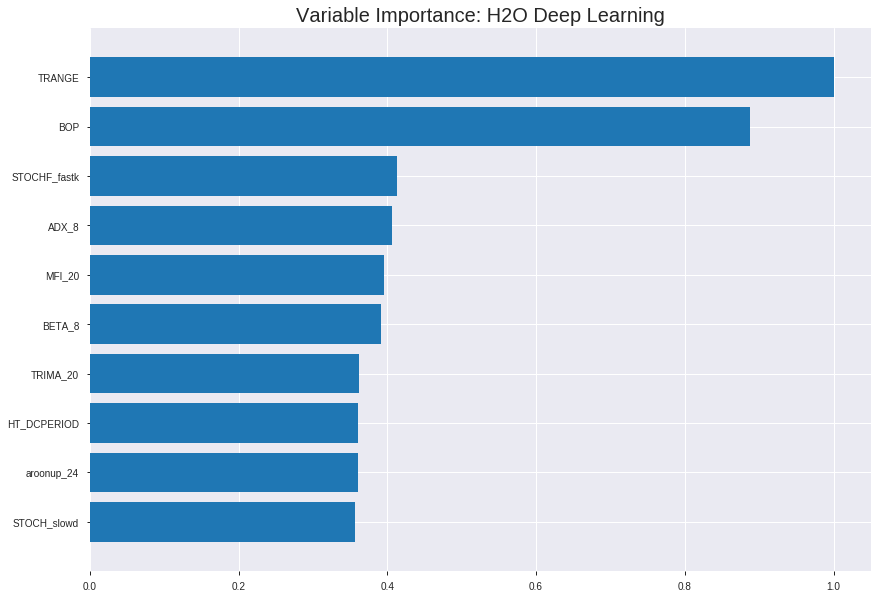

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_171254_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18195537343894458
RMSE: 0.42656227381115713
LogLoss: 0.5373661492466114
Mean Per-Class Error: 0.26899380228490877
AUC: 0.8017595658939471
pr_auc: 0.7364520034632788
Gini: 0.6035191317878943
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4444821200727571: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      504  348  0.4085   (348.0/852.0)
1      100  606  0.1416   (100.0/706.0)
Total  604  954  0.2875   (448.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444482     0.73012   226
max f2                       0.284187     0.849617  294
max f0point5                 0.584376     0.697068  151
max accuracy                 0.493697     0.725289  196
max precision                0.895442     1         0
max recall                   0.0540249    1         375
max specificity              0.895442     1         0
max absolute_mcc             0.472662     0.461957  208
max min_per_class_accuracy   0.510708     0.720963  187
max mean_per_class_accuracy  0.472662     0.731006  208

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 48.56 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.871441           2.06887    2.06887            0.9375           0.880335   0.9375                      0.880335            0.0212465       0.0212465                  106.887    106.887
    2        0.0205392                   0.85756            1.6551     1.86199            0.75             0.865227   0.84375                     0.872781            0.0169972       0.0382436                  65.5099    86.1987
    3        0.0301669                   0.84523            2.05968    1.92508            0.933333         0.851004   0.87234                     0.865831            0.01983         0.0580737                  105.968    92.508
    4        0.0404365                   0.836785           1.6551     1.85651            0.75             0.840412   0.84127                     0.859375            0.0169972       0.0750708                  65.5099    85.6513
    5        0.0500642                   0.829567           1.76544    1.839              0.8              0.833655   0.833333                    0.854429            0.0169972       0.092068                   76.5439    83.8999
    6        0.100128                    0.795673           1.72583    1.78241            0.782051         0.810581   0.807692                    0.832505            0.0864023       0.17847                    72.583     78.2414
    7        0.150193                    0.757947           1.81071    1.79185            0.820513         0.777173   0.811966                    0.814061            0.0906516       0.269122                   81.0707    79.1845
    8        0.200257                    0.718387           1.52778    1.72583            0.692308         0.739466   0.782051                    0.795412            0.0764873       0.345609                   52.7784    72.583
    9        0.300385                    0.643137           1.55608    1.66925            0.705128         0.679339   0.75641                     0.756721            0.155807        0.501416                   55.6076    66.9245
    10       0.399872                    0.566875           1.22442    1.55857            0.554839         0.60484    0.70626                     0.718934            0.121813        0.623229                   22.4417    55.8574
    11       0.5                         0.497422           1.24486    1.49575            0.564103         0.53003    0.677792                    0.681105            0.124646        0.747875                   24.4861    49.5751
    12       0.600128                    0.448548           0.99023    1.41141            0.448718         0.471463   0.639572                    0.646127            0.0991501       0.847025                   -0.976974  41.1407
    13       0.699615                    0.380602           0.783058   1.32205            0.354839         0.418804   0.599083                    0.613801            0.0779037       0.924929                   -21.6942   32.2055
    14       0.799743                    0.262398           0.523407   1.22206            0.237179         0.324294   0.553772                    0.577555            0.0524079       0.977337                   -47.6593   22.2064
    15       0.899872                    0.116944           0.155608   1.1034             0.0705128        0.185494   0.5                         0.53393             0.0155807       0.992918                   -84.4392   10.3399
    16       1                           8.35702e-05        0.0707307  1                  0.0320513        0.050



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1942777386363175
RMSE: 0.44076948469275584
LogLoss: 0.5664480870579627
Mean Per-Class Error: 0.29049786745406825
AUC: 0.7912258038057742
pr_auc: 0.7265255982569967
Gini: 0.5824516076115485
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.443812105840795: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  126  0.4961   (126.0/254.0)
1      21   171  0.1094   (21.0/192.0)
Total  149  297  0.3296   (147.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443812     0.699387  262
max f2                       0.224372     0.817637  358
max f0point5                 0.698599     0.722892  108
max accuracy                 0.698599     0.735426  108
max precision                0.826573     0.916667  32
max recall                   0.19168      1         367
max specificity              0.882281     0.996063  0
max absolute_mcc             0.698599     0.464029  108
max min_per_class_accuracy   0.544254     0.700787  192
max mean_per_class_accuracy  0.59714      0.709502  156

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 52.35 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.872122           1.39375    1.39375            0.6              0.878937  0.6                         0.878937            0.015625        0.015625                   39.375    39.375
    2        0.0201794                   0.86317            2.32292    1.80671            1                0.866711  0.777778                    0.873504            0.0208333       0.0364583                  132.292   80.6713
    3        0.0313901                   0.854192           1.85833    1.82515            0.8              0.857283  0.785714                    0.867711            0.0208333       0.0572917                  85.8333   82.5149
    4        0.0403587                   0.849144           2.32292    1.93576            1                0.852409  0.833333                    0.86431             0.0208333       0.078125                   132.292   93.5764
    5        0.0515695                   0.843775           2.32292    2.01993            1                0.846921  0.869565                    0.86053             0.0260417       0.104167                   132.292   101.993
    6        0.100897                    0.812122           2.11174    2.06481            0.909091         0.826852  0.888889                    0.844065            0.104167        0.208333                   111.174   106.481
    7        0.150224                    0.780997           1.68939    1.94154            0.727273         0.799675  0.835821                    0.829489            0.0833333       0.291667                   68.9394   94.1542
    8        0.201794                    0.742343           1.91893    1.93576            0.826087         0.760176  0.833333                    0.811776            0.0989583       0.390625                   91.8931   93.5764
    9        0.300448                    0.667289           1.37263    1.75086            0.590909         0.707092  0.753731                    0.777402            0.135417        0.526042                   37.2633   75.0855
    10       0.401345                    0.58891            1.03241    1.57024            0.444444         0.626947  0.675978                    0.739578            0.104167        0.630208                   3.24074   57.024
    11       0.5                         0.529718           1.00308    1.45833            0.431818         0.561612  0.627803                    0.704464            0.0989583       0.729167                   0.307765  45.8333
    12       0.600897                    0.470318           0.825926   1.35215            0.355556         0.491733  0.58209                     0.668744            0.0833333       0.8125                     -17.4074  35.2146
    13       0.699552                    0.428659           0.950284   1.29547            0.409091         0.450228  0.557692                    0.637928            0.09375         0.90625                    -4.97159  29.5473
    14       0.800448                    0.337446           0.412963   1.18423            0.177778         0.383428  0.509804                    0.605848            0.0416667       0.947917                   -58.7037  18.4232
    15       0.899103                    0.217938           0.475142   1.10643            0.204545         0.281316  0.476309                    0.570238            0.046875        0.994792                   -52.4858  10.6427
    16       1                           0.000130663        0.0516204  1                  0.0222222        0.106807  0.430493                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:18:37  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:18:39  1 min 22.134 sec  580 obs/sec       0.588575  1             917        0.545876         1.00377             -0.20248       0.680841        0.620007           1.6551           0.438383                         0.564622           1.04206               -0.30032         0.659182          0.598784             1.85833            0.428251
    2019-08-27 17:18:48  1 min 31.561 sec  1009 obs/sec      6.5629    11            10225      0.437007         0.564016            0.22933        0.784783        0.718825           2.06887          0.307445                         0.441489           0.572653              0.204985         0.777631          0.702303             1.85833            0.307175
    2019-08-27 17:18:57  1 min 40.641 sec  1170 obs/sec      13.7458   23            21416      0.426562         0.537366            0.26573        0.80176         0.736452           2.06887          0.287548                         0.440769           0.566448              0.207576         0.791226          0.726526             1.39375            0.329596
    2019-08-27 17:19:07  1 min 50.163 sec  1274 obs/sec      22.0353   37            34331      0.42208          0.527561            0.281081       0.816206        0.755706           2.06887          0.290757                         0.442949           0.572205              0.199721         0.783803          0.695895             1.85833            0.320628
    2019-08-27 17:19:16  1 min 59.361 sec  1341 obs/sec      30.3774   51            47328      0.42147          0.520907            0.283158       0.82637         0.776086           2.2068           0.286906                         0.442805           0.570075              0.200239         0.771202          0.67614              0.929167           0.372197
    2019-08-27 17:19:25  2 min  8.293 sec  1392 obs/sec      38.733    65            60346      0.407629         0.491711            0.329466       0.842469        0.80146            2.06887          0.260591                         0.451476           0.588964              0.16861          0.770321          0.677793             1.39375            0.320628
    2019-08-27 17:19:34  2 min 17.205 sec  1431 obs/sec      47.181    79            73508      0.396383         0.467733            0.365955       0.857687        0.82189            2.2068           0.238126                         0.452536           0.607208              0.164703         0.759791          0.639635             0.929167           0.320628
    2019-08-27 17:19:35  2 min 18.118 sec  1430 obs/sec      47.181    79            73508      0.426562         0.537366            0.26573        0.80176         0.736452           2.06887          0.287548                         0.440769           0.566448              0.207576         0.791226          0.726526             1.39375            0.329596

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
TRANGE        1.0                    1.0                  0.055035672281129606
BOP           0.8870195746421814     0.8870195746421814   0.048817718616954074
STOCHF_fastk  0.41306886076927185    0.41306886076927185  0.0227335224508372
ADX_8         0.40691396594047546    0.40691396594047546  0.022394783676114742
MFI_20        0.39575567841529846    0.39575567841529846  0.02178067982066048
---           ---                    ---                  ---
ROC_20        0.28654173016548157    0.28654173016548157  0.015770016756255313
WILLR_14      0.2834944725036621     0.2834944725036621   0.015602308882223255
ROCP_12       0.2710872292518616     0.2710872292518616   0.014919467908704903
ROCR_12       0.26624590158462524    0.26624590158462524  0.01465302218580532
MOM_12        0.26353463530540466    0.26353463530540466  0.014503805823395258


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7443946188340808)

('F1', 0.6798418972332017)

('auc', 0.781052281052281)

('logloss', 0.5676783250860978)

('mean_per_class_error', 0.27601565101565106)

('rmse', 0.4391536410961027)

('mse', 0.1928559204879646)

deeplearning prediction progress: |███████████████████████████████████████| 100%


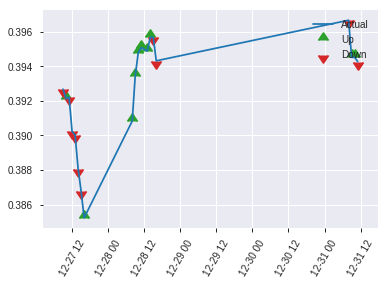


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1928559204879646
RMSE: 0.4391536410961027
LogLoss: 0.5676783250860978
Mean Per-Class Error: 0.27601565101565106
AUC: 0.781052281052281
pr_auc: 0.6569545708696294
Gini: 0.5621045621045619
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37992028273104406: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   76   0.5758   (76.0/132.0)
1      5    86   0.0549   (5.0/91.0)
Total  61   162  0.3632   (81.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37992      0.679842  161
max f2                       0.37992      0.81749   161
max f0point5                 0.587818     0.697674  73
max accuracy                 0.587818     0.744395  73
max precision                0.872362     1         0
max recall                   0.1517       1         209
max specificity              0.872362     1         0
max absolute_mcc             0.587818     0.461227  73
max min_per_class_accuracy   0.481933     0.703297  102
max mean_per_class_accuracy  0.539696     0.723984  82

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 48.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.85274            1.6337    1.6337             0.666667         0.859996  0.666667                    0.859996            0.021978        0.021978                   63.37     63.37
    2        0.0224215                   0.839949           1.22527   1.47033            0.5              0.845311  0.6                         0.854122            0.010989        0.032967                   22.5275   47.033
    3        0.0313901                   0.834116           2.45055   1.75039            1                0.837409  0.714286                    0.849347            0.021978        0.0549451                  145.055   75.0392
    4        0.0403587                   0.822198           2.45055   1.90598            1                0.832226  0.777778                    0.845542            0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.810144           1.6337    1.83791            0.666667         0.814619  0.75                        0.837811            0.021978        0.0989011                  63.37     83.7912
    6        0.103139                    0.77409            1.55944   1.70473            0.636364         0.790408  0.695652                    0.81514             0.0769231       0.175824                   55.9441   70.473
    7        0.152466                    0.732045           2.005     1.80187            0.818182         0.752484  0.735294                    0.794869            0.0989011       0.274725                   100.5     80.1875
    8        0.201794                    0.705951           1.78222   1.79707            0.727273         0.719909  0.733333                    0.776545            0.0879121       0.362637                   78.2218   79.707
    9        0.300448                    0.617145           1.78222   1.79219            0.727273         0.660375  0.731343                    0.7384              0.175824        0.538462                   78.2218   79.2193
    10       0.399103                    0.513119           1.11389   1.62452            0.454545         0.561358  0.662921                    0.694637            0.10989         0.648352                   11.3886   62.4522
    11       0.502242                    0.467025           0.852365  1.46595            0.347826         0.48723   0.598214                    0.652044            0.0879121       0.736264                   -14.7635  46.5954
    12       0.600897                    0.428244           0.77972   1.35329            0.318182         0.447379  0.552239                    0.618442            0.0769231       0.813187                   -22.028   35.3289
    13       0.699552                    0.388572           0.891109  1.28811            0.363636         0.409253  0.525641                    0.588941            0.0879121       0.901099                   -10.8891  28.8109
    14       0.798206                    0.3353             0.556943  1.19774            0.227273         0.363822  0.488764                    0.561118            0.0549451       0.956044                   -44.3057  19.774
    15       0.896861                    0.199495           0.334166  1.10275            0.136364         0.282047  0.45                        0.53042             0.032967        0.989011                   -66.5834  10.2747
    16       1                           0.00335959         0.106546  1                  0.0434783        0.118508  0.408072                    0.487936            0.0

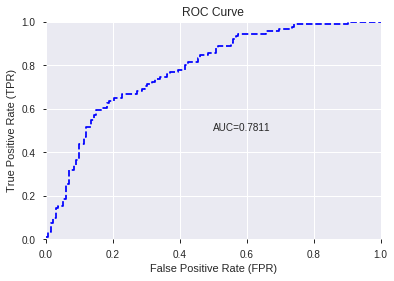

This function is available for GLM models only


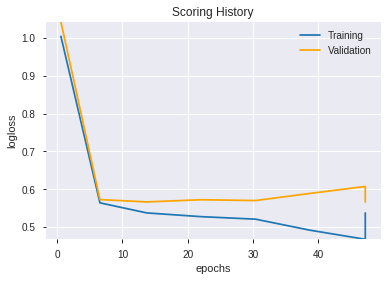

--2019-08-27 17:20:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_171254_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_171254_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'STOCHF_fastk',
 'ADX_8',
 'MFI_20',
 'BETA_8',
 'TRIMA_20',
 'HT_DCPERIOD',
 'aroonup_24',
 'STOCH_slowd',
 'PLUS_DI_12',
 'BETA_14',
 'STOCHRSI_fastk',
 'LINEARREG_12',
 'AROONOSC_30',
 'STDDEV_14',
 'aroonup_20',
 'WILLR_8',
 'DX_24',
 'ADXR_12',
 'BETA_12',
 'DX_30',
 'aroondown_14',
 'AROONOSC_8',
 'aroonup_12',
 'STOCHRSI_fastd',
 'HT_PHASOR_quadrature',
 'NATR_14',
 'ATR_12',
 'CCI_12',
 'CDLSHORTLINE',
 'NATR_20',
 'MACDFIX_signal_24',
 'STOCHF_fastd',
 'PLUS_DM_20',
 'WILLR_12',
 'LINEARREG_ANGLE_12',
 'ROCP_8',
 'ROC_14',
 'MOM_8',
 'LINEARREG_ANGLE_8',
 'ROCR_8',
 'ROCR_30',
 'RSI_14',
 'ROCR_20',
 'MACDFIX_20',
 'ROCP_24',
 'ROC_20',
 'WILLR_14',
 'ROCP_12',
 'ROCR_12',
 'MOM_12']

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_172047_model_1  0.800533  0.541358              0.293207  0.427568  0.182815

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.710671           1.000000    0.124751
1                 TRANGE             0.703254           0.989563    0.123449
2           STOCHF_fastk             0.262449           0.369297    0.046070
3                 CCI_12             0.250118           0.351947    0.043906
4                 RSI_14             0.175210           0.246541    0.030756
5             PLUS_DI_12             0.174157           0.245060    0.030571
6              STDDEV_14             0.161143           0.226748    0.028287
7           STOCHF_fastd             0.141160           0.198629    0.024779
8     LINEARREG_ANGLE_12             0.139096           0.195724    0.024417
9                 MFI_20             0.137560           0.193564    0.024147
10               BETA_14             0.134099           0.188693    0.023540
11           STOCH_slowd             0.128723           0.181129    0.022596
12        STOCHRSI_fastd             0.125265           0.176263    0.021989
13                 ADX_8             0.121494           0.170956    0.021327
14              WILLR_12             0.108395           0.152525    0.019028
15               ADXR_12             0.102358           0.144030    0.017968
16          aroondown_14             0.099436           0.139919    0.017455
17            AROONOSC_8             0.099202           0.139589    0.017414
18              WILLR_14             0.095888           0.134926    0.016832
19     MACDFIX_signal_24             0.086476           0.121682    0.015180
20                ROC_20             0.086133           0.121200    0.015120
21               ROCR_20             0.085953           0.120946    0.015088
22                BETA_8             0.085941           0.120930    0.015086
23               WILLR_8             0.085381           0.120142    0.014988
24           HT_DCPERIOD             0.085212           0.119903    0.014958
25            aroonup_24             0.080986           0.113958    0.014216
26               NATR_20             0.079813           0.112306    0.014010
27                ROCR_8             0.076474           0.107608    0.013424
28                 MOM_8             0.076424           0.107537    0.013415
29                ROCP_8             0.076331           0.107407    0.013399
30                 DX_24             0.074760           0.105196    0.013123
31        STOCHRSI_fastk             0.066798           0.093993    0.011726
32                 DX_30             0.064173           0.090299    0.011265
33               NATR_14             0.063436           0.089262    0.011136
34               ROCR_12             0.062219           0.087549    0.010922
35               ROCP_12             0.061003           0.085839    0.010708
36           AROONOSC_30             0.059205           0.083308    0.010393
37               BETA_12             0.053576           0.075388    0.009405
38                MOM_12             0.048264           0.067913    0.008472
39                ATR_12             0.047947           0.067468    0.008417
40               ROCP_24             0.047487           0.066820    0.008336
41     LINEARREG_ANGLE_8             0.045180           0.063574    0.007931
42          CDLSHORTLINE             0.039420           0.055469    0.006920
43            PLUS_DM_20             0.039196           0.055153    0.006880
44               ROCR_30             0.033751           0.047492    0.005925
45            aroonup_12             0.033455           0.047075    0.005873
46            aroonup_20             0.025483           0.035857    0.004473
47          LINEARREG_12             0.021056           0.029629    0.003696
48            MACDFIX_20             0.017899           0.025186    0.003142
49                ROC_14             0.007053           0.009925    0.001238
50  HT_PHASOR_quadrature             0.006700           0.009428    0.001176
51          

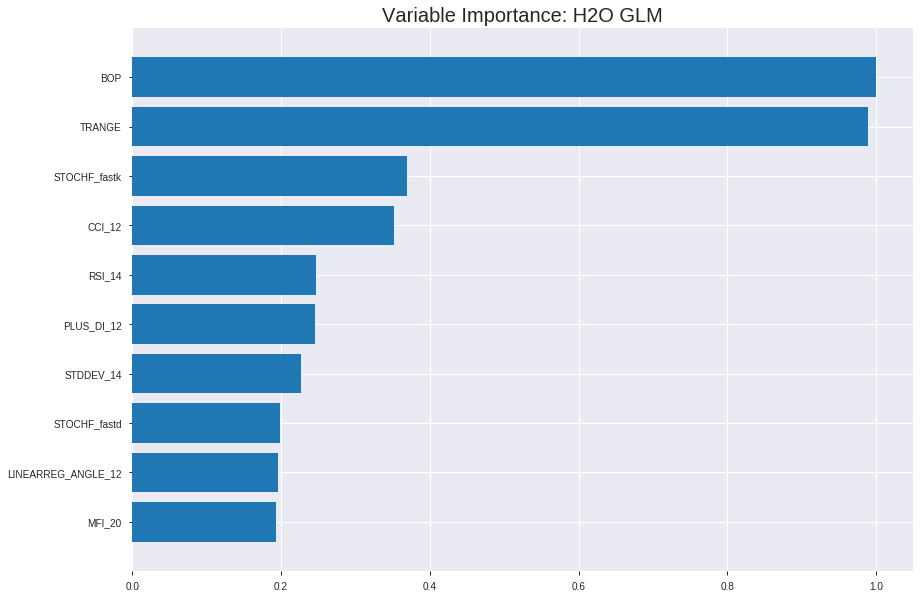

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_172047_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18593439589883987
RMSE: 0.4312011084155975
LogLoss: 0.5500180273438023
Null degrees of freedom: 1557
Residual degrees of freedom: 1505
Null deviance: 2146.1448765004316
Residual deviance: 1713.856173203288
AIC: 1819.856173203288
AUC: 0.7905029326098232
pr_auc: 0.7253428702486141
Gini: 0.5810058652196464
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41145771364557066: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      540  312  0.3662   (312.0/852.0)
1      132  574  0.187    (132.0/706.0)
Total  672  886  0.285    (444.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411458     0.721106  223
max f2                       0.204611     0.835978  319
max f0point5                 0.511648     0.700288  171
max accuracy                 0.511648     0.727214  171
max precision                0.908775     1         0
max recall                   0.0666538    1         381
max specificity              0.908775     1         0
max absolute_mcc             0.411458     0.449125  223
max min_per_class_accuracy   0.484982     0.71831   186
max mean_per_class_accuracy  0.501455     0.724514  177

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.853242           2.06887   2.06887            0.9375           0.872434  0.9375                      0.872434            0.0212465       0.0212465                  106.887   106.887
    2        0.0205392                   0.82877            1.93095   1.99991            0.875            0.840384  0.90625                     0.856409            0.01983         0.0410765                  93.0949   99.9911
    3        0.0301669                   0.812126           1.61832   1.87813            0.733333         0.822217  0.851064                    0.845497            0.0155807       0.0566572                  61.8319   87.8127
    4        0.0404365                   0.797882           1.79302   1.85651            0.8125           0.804288  0.84127                     0.835031            0.0184136       0.0750708                  79.3024   85.6513
    5        0.0500642                   0.786053           1.61832   1.81071            0.733333         0.791259  0.820513                    0.826613            0.0155807       0.0906516                  61.8319   81.0707
    6        0.100128                    0.750271           1.58437   1.69754            0.717949         0.769971  0.769231                    0.798292            0.0793201       0.169972                   58.4368   69.7538
    7        0.150193                    0.720232           1.72583   1.70697            0.782051         0.735295  0.773504                    0.777293            0.0864023       0.256374                   72.583    70.6968
    8        0.200257                    0.679361           1.78241   1.72583            0.807692         0.698348  0.782051                    0.757557            0.0892351       0.345609                   78.2414   72.583
    9        0.300385                    0.61407            1.48535   1.64567            0.673077         0.646724  0.745726                    0.720612            0.148725        0.494334                   48.5345   64.5668
    10       0.399872                    0.543988           1.36679   1.57628            0.619355         0.579897  0.714286                    0.685603            0.135977        0.630312                   36.6792   57.6285
    11       0.5                         0.464314           1.1034    1.48159            0.5              0.506122  0.671374                    0.649661            0.110482        0.740793                   10.3399   48.1586
    12       0.600128                    0.383704           0.933646  1.39017            0.423077         0.425498  0.629947                    0.61226             0.0934844       0.834278                   -6.63543  39.0165
    13       0.699615                    0.293838           0.711871  1.29371            0.322581         0.341646  0.586239                    0.573779            0.0708215       0.905099                   -28.8129  29.3711
    14       0.799743                    0.214507           0.537554  1.19904            0.24359          0.252321  0.543339                    0.533532            0.0538244       0.958924                   -46.2446  19.9039
    15       0.899872                    0.142356           0.297069  1.09868            0.134615         0.178254  0.49786                     0.494               0.029745        0.988669                   -70.2931  9.86773
    16       1                           0.000674299        0.113169  1                  0.0512821        0.085974  0.453145                    0.453145          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1899003434014763
RMSE: 0.4357755654020499
LogLoss: 0.5568186945089655
Null degrees of freedom: 445
Residual degrees of freedom: 393
Null deviance: 610.5669311494817
Residual deviance: 496.68227550199725
AIC: 602.6822755019973
AUC: 0.7900159940944882
pr_auc: 0.7252416774894829
Gini: 0.5800319881889764
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3857095043148912: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      124  130  0.5118   (130.0/254.0)
1      17   175  0.0885   (17.0/192.0)
Total  141  305  0.3296   (147.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.38571      0.704225  267
max f2                       0.312061     0.840108  298
max f0point5                 0.669831     0.704023  111
max accuracy                 0.669831     0.726457  111
max precision                0.814474     0.952381  18
max recall                   0.146658     1         371
max specificity              0.898701     0.996063  0
max absolute_mcc             0.669831     0.440112  111
max min_per_class_accuracy   0.530006     0.681102  188
max mean_per_class_accuracy  0.407275     0.701977  249

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.859564           1.85833    1.85833            0.8              0.882586  0.8                         0.882586            0.0208333       0.0208333                  85.8333   85.8333
    2        0.0201794                   0.843443           2.32292    2.06481            1                0.847031  0.888889                    0.866784            0.0208333       0.0416667                  132.292   106.481
    3        0.0313901                   0.828409           2.32292    2.15699            1                0.835669  0.928571                    0.855671            0.0260417       0.0677083                  132.292   115.699
    4        0.0403587                   0.820144           2.32292    2.19387            1                0.824515  0.944444                    0.848748            0.0208333       0.0885417                  132.292   119.387
    5        0.0515695                   0.810845           1.39375    2.01993            0.6              0.814918  0.869565                    0.841393            0.015625        0.104167                   39.375    101.993
    6        0.100897                    0.785026           2.00616    2.01319            0.863636         0.796831  0.866667                    0.819607            0.0989583       0.203125                   100.616   101.319
    7        0.150224                    0.761335           1.79498    1.94154            0.772727         0.772453  0.835821                    0.804124            0.0885417       0.291667                   79.4981   94.1542
    8        0.201794                    0.721814           1.81793    1.90995            0.782609         0.744828  0.822222                    0.78897             0.09375         0.385417                   81.7935   90.9954
    9        0.300448                    0.658142           1.42543    1.75086            0.613636         0.687685  0.753731                    0.755713            0.140625        0.526042                   42.5426   75.0855
    10       0.401345                    0.591167           0.877546   1.53131            0.377778         0.624454  0.659218                    0.722715            0.0885417       0.614583                   -12.2454  53.1308
    11       0.5                         0.517585           1.00308    1.42708            0.431818         0.549504  0.61435                     0.688539            0.0989583       0.713542                   0.307765  42.7083
    12       0.600897                    0.441424           1.03241    1.36081            0.444444         0.478823  0.585821                    0.653325            0.104167        0.817708                   3.24074   36.0813
    13       0.699552                    0.369138           0.950284   1.30292            0.409091         0.403331  0.560897                    0.61807             0.09375         0.911458                   -4.97159  30.2918
    14       0.800448                    0.274512           0.619444   1.21677            0.266667         0.322601  0.52381                     0.580826            0.0625          0.973958                   -38.0556  21.6766
    15       0.899103                    0.183087           0.211174   1.10643            0.0909091        0.225123  0.476309                    0.541796            0.0208333       0.994792                   -78.8826  10.6427
    16       1                           0.000598027        0.0516204  1                  0.0222222        0.113974  0.430493                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 17:20:47  0.000 sec   2            .21E2     53            1.364921698379683   1.3571024571990797
     2019-08-27 17:20:47  0.012 sec   4            .13E2     53            1.358590958213212   1.350956974934493
     2019-08-27 17:20:47  0.024 sec   6            .8E1      53            1.349676208192722   1.3421225447186698
     2019-08-27 17:20:47  0.036 sec   8            .49E1     53            1.3375556615600515  1.3298223570329566
     2019-08-27 17:20:47  0.048 sec   10           .31E1     53            1.3215173609580633  1.3132117539123447
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 17:20:47  0.199 sec   34           .1E-1     53            1.0957225401204604  1.1138497269589558
     2019-08-27 17:20:47  0.212 sec   36           .63E-2    53            1.0930003305858655  1.1151672525265957
     2019-08-27 17:20:47  0.231 sec   38           .39E-2    53            1.0913422580171028  1.1168973904747763
     2019-08-27 17:20:47  0.245 sec   40           .24E-2    53            1.090329939172004   1.1185582748415006
     2019-08-27 17:20:47  0.257 sec   42           .15E-2    53            1.0897197233027163  1.1199341979765443


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.6869565217391305)

('auc', 0.8005328005328005)

('logloss', 0.5413577885614879)

('mean_per_class_error', 0.2629453879453879)

('rmse', 0.42756838529854424)

('mse', 0.18281472410680438)

glm prediction progress: |████████████████████████████████████████████████| 100%


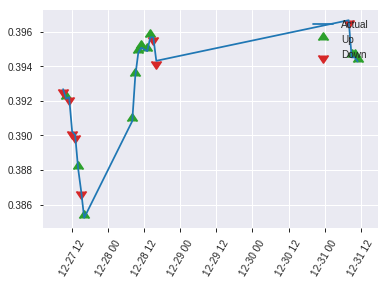


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18281472410680438
RMSE: 0.42756838529854424
LogLoss: 0.5413577885614879
Null degrees of freedom: 222
Residual degrees of freedom: 170
Null deviance: 303.40375268137996
Residual deviance: 241.4455736984236
AIC: 347.4455736984236
AUC: 0.8005328005328005
pr_auc: 0.723816794398975
Gini: 0.601065601065601
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3796545190748885: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   60   0.4545   (60.0/132.0)
1      12   79   0.1319   (12.0/91.0)
Total  84   139  0.3229   (72.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379655     0.686957  138
max f2                       0.268461     0.828678  172
max f0point5                 0.573491     0.705596  79
max accuracy                 0.573491     0.753363  79
max precision                0.870755     1         0
max recall                   0.22382      1         186
max specificity              0.870755     1         0
max absolute_mcc             0.569834     0.483247  81
max min_per_class_accuracy   0.503659     0.703297  100
max mean_per_class_accuracy  0.569834     0.737055  81

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 46.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.83619            2.45055   2.45055            1                0.849068  1                           0.849068            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.82061            2.45055   2.45055            1                0.829799  1                           0.84136             0.021978        0.0549451                  145.055   145.055
    3        0.0313901                   0.805187           2.45055   2.45055            1                0.815099  1                           0.833857            0.021978        0.0769231                  145.055   145.055
    4        0.0403587                   0.797031           1.22527   2.17827            0.5              0.79965   0.888889                    0.826255            0.010989        0.0879121                  22.5275   117.827
    5        0.0538117                   0.789407           2.45055   2.24634            1                0.792513  0.916667                    0.81782             0.032967        0.120879                   145.055   124.634
    6        0.103139                    0.756857           1.78222   2.02437            0.727273         0.771554  0.826087                    0.795693            0.0879121       0.208791                   78.2218   102.437
    7        0.152466                    0.707              2.22777   2.09017            0.909091         0.72594   0.852941                    0.773126            0.10989         0.318681                   122.777   109.017
    8        0.201794                    0.681176           1.78222   2.0149             0.727273         0.690936  0.822222                    0.753035            0.0879121       0.406593                   78.2218   101.49
    9        0.300448                    0.604928           1.33666   1.79219            0.545455         0.641341  0.731343                    0.716359            0.131868        0.538462                   33.6663   79.2193
    10       0.399103                    0.541525           1.33666   1.67959            0.545455         0.576558  0.685393                    0.681802            0.131868        0.67033                    33.6663   67.959
    11       0.502242                    0.456019           0.639274  1.46595            0.26087          0.502039  0.598214                    0.644886            0.0659341       0.736264                   -36.0726  46.5954
    12       0.600897                    0.393997           0.891109  1.37158            0.363636         0.429236  0.559701                    0.609481            0.0879121       0.824176                   -10.8891  37.1576
    13       0.699552                    0.332675           0.77972   1.28811            0.318182         0.358628  0.525641                    0.574104            0.0769231       0.901099                   -22.028   28.8109
    14       0.798206                    0.24279            0.77972   1.22527            0.318182         0.294819  0.5                         0.539586            0.0769231       0.978022                   -22.028   22.5275
    15       0.896861                    0.17061            0.222777  1.115              0.0909091        0.210711  0.455                       0.50341             0.021978        1                          -77.7223  11.5
    16       1                           0.0169862          0         1                  0                0.11547   0.408072                    0.463398            0 

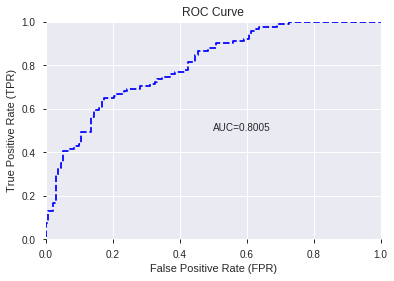

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


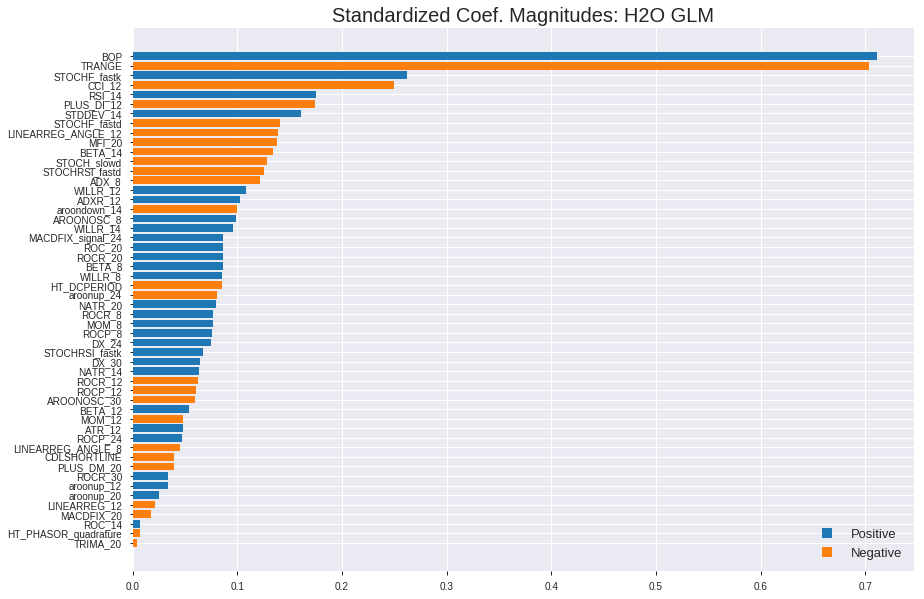

'log_likelihood'
--2019-08-27 17:20:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_172047_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_172047_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CCI_12',
 'RSI_14',
 'PLUS_DI_12',
 'STDDEV_14',
 'STOCHF_fastd',
 'LINEARREG_ANGLE_12',
 'MFI_20',
 'BETA_14',
 'STOCH_slowd',
 'STOCHRSI_fastd',
 'ADX_8',
 'WILLR_12',
 'ADXR_12',
 'aroondown_14',
 'AROONOSC_8',
 'WILLR_14',
 'MACDFIX_signal_24',
 'ROC_20',
 'ROCR_20',
 'BETA_8',
 'WILLR_8',
 'HT_DCPERIOD',
 'aroonup_24',
 'NATR_20',
 'ROCR_8',
 'MOM_8',
 'ROCP_8',
 'DX_24',
 'STOCHRSI_fastk',
 'DX_30',
 'NATR_14',
 'ROCR_12',
 'ROCP_12',
 'AROONOSC_30',
 'BETA_12',
 'MOM_12',
 'ATR_12',
 'ROCP_24',
 'LINEARREG_ANGLE_8',
 'CDLSHORTLINE',
 'PLUS_DM_20',
 'ROCR_30',
 'aroonup_12',
 'aroonup_20',
 'LINEARREG_12',
 'MACDFIX_20',
 'ROC_14',
 'HT_PHASOR_quadrature',
 'TRIMA_20']

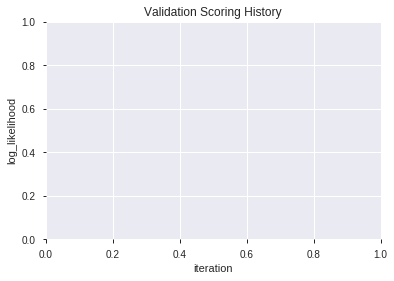

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_172058_model_4  0.768065  0.571676              0.296245  0.441029  0.194507
1               XGBoost_2_AutoML_20190827_172058  0.753580  0.585422              0.303613  0.447592  0.200339
2  XGBoost_grid_1_AutoML_20190827_172058_model_3  0.750000  0.592645              0.290751  0.450608  0.203048
3  XGBoost_grid_1_AutoML_20190827_172058_model_2  0.748335  0.592777              0.302489  0.450886  0.203298
4               XGBoost_1_AutoML_20190827_172058  0.747086  0.591278              0.308733  0.450078  0.202570
5  XGBoost_grid_1_AutoML_20190827_172058_model_6  0.739760  0.597649              0.320471  0.454076  0.206185
6  XGBoost_grid_1_AutoML_20190827_172058_model_1  0.738511  0.597107              0.295122  0.453876  0.206004
7  XGBoost_grid_1_AutoML_20190827_172058_model_7  0.737013  0.593555              0.288503  0.451415  0.203775
8               XGBoost_3_AutoML_20190827_172058  0.730353  0.601825              0.301199  0.455742  0.207701
9  XGBoost_grid_1_AutoML_20190827_172058_model_5  0.714202  0.617343              0.358725  0.462945  0.214318

variable  relative_importance  scaled_importance  percentage
0                    BOP          2031.654297           1.000000    0.378160
1                 TRANGE           980.543457           0.482633    0.182513
2           STOCHF_fastk           215.976105           0.106306    0.040201
3                 CCI_12           126.264404           0.062149    0.023502
4                 ATR_12           121.736763           0.059920    0.022659
5           STOCHF_fastd           113.469856           0.055851    0.021121
6         STOCHRSI_fastk            93.547928           0.046045    0.017412
7                  DX_30            93.063789           0.045807    0.017322
8                ADXR_12            75.214218           0.037021    0.014000
9         STOCHRSI_fastd            73.894043           0.036371    0.013754
10            PLUS_DI_12            68.327713           0.033632    0.012718
11                MFI_20            67.370399           0.033160    0.012540
12                 ADX_8            66.996452           0.032976    0.012470
13           STOCH_slowd            66.425468           0.032695    0.012364
14             STDDEV_14            61.664444           0.030352    0.011478
15     LINEARREG_ANGLE_8            59.244381           0.029161    0.011027
16  HT_PHASOR_quadrature            57.225727           0.028167    0.010652
17                BETA_8            56.267776           0.027696    0.010473
18               ROCR_30            54.863155           0.027004    0.010212
19              WILLR_12            54.706177           0.026927    0.010183
20               WILLR_8            54.428280           0.026790    0.010131
21               NATR_20            53.753006           0.026458    0.010005
22               BETA_14            53.523571           0.026345    0.009963
23                 DX_24            51.481102           0.025339    0.009582
24              TRIMA_20            48.744328           0.023992    0.009073
25               NATR_14            46.146786           0.022714    0.008589
26            aroonup_12            45.238743           0.022267    0.008420
27           HT_DCPERIOD            44.866837           0.022084    0.008351
28               BETA_12            44.342346           0.021826    0.008254
29     MACDFIX_signal_24            39.053764           0.019223    0.007269
30                ROC_20            37.441185           0.018429    0.006969
31              WILLR_14            33.993118           0.016732    0.006327
32                RSI_14            27.839085           0.013703    0.005182
33            PLUS_DM_20            27.587284           0.013579    0.005135
34          aroondown_14            26.226803           0.012909    0.004882
35            MACDFIX_20            25.461826           0.012533    0.004739
36                ROC_14            23.566833           0.011600    0.004387
37            aroonup_24            19.613464           0.009654    0.003651
38          LINEARREG_12            19.515991           0.009606    0.003633
39               ROCP_24            19.275805           0.009488    0.003588
40               ROCP_12            17.894890           0.008808    0.003331
41                ROCP_8            16.187025           0.007967    0.003013
42                 MOM_8            14.361407           0.007069    0.002673
43    LINEARREG_ANGLE_12            13.330244           0.006561    0.002481
44                MOM_12            12.721877           0.006262    0.002368
45           AROONOSC_30            10.665428           0.005250    0.001985
46            AROONOSC_8             6.754265           0.003325    0.001257

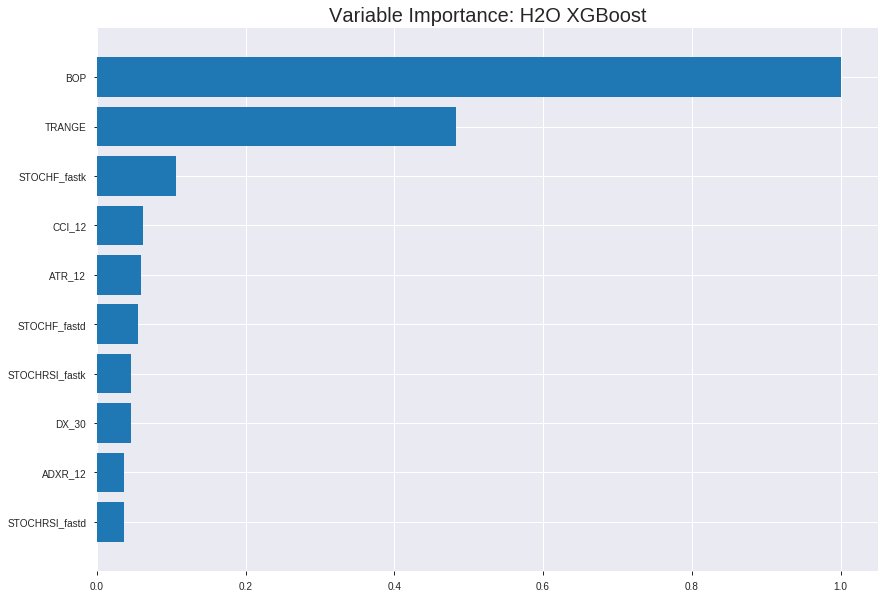

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_172058_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16319594691163594
RMSE: 0.40397518105898034
LogLoss: 0.4993245684209267
Mean Per-Class Error: 0.23527876418093074
AUC: 0.8504867733312054
pr_auc: 0.82214182967672
Gini: 0.7009735466624107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4320037364959717: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      598  254  0.2981   (254.0/852.0)
1      123  583  0.1742   (123.0/706.0)
Total  721  837  0.242    (377.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432004     0.755671  220
max f2                       0.206297     0.85411   326
max f0point5                 0.584616     0.764667  145
max accuracy                 0.570298     0.769576  151
max precision                0.857361     1         0
max recall                   0.0908772    1         391
max specificity              0.857361     1         0
max absolute_mcc             0.570298     0.534003  151
max min_per_class_accuracy   0.491603     0.76204   191
max mean_per_class_accuracy  0.489737     0.764721  192

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 45.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.822795           2.2068     2.2068             1                0.835941  1                           0.835941            0.0226629       0.0226629                  120.68    120.68
    2        0.0205392                   0.802688           2.2068     2.2068             1                0.810666  1                           0.823303            0.0226629       0.0453258                  120.68    120.68
    3        0.0301669                   0.792116           2.05968    2.15985            0.933333         0.796811  0.978723                    0.814848            0.01983         0.0651558                  105.968   115.985
    4        0.0404365                   0.784602           2.2068     2.17177            1                0.787998  0.984127                    0.808029            0.0226629       0.0878187                  120.68    117.177
    5        0.0500642                   0.777869           2.2068     2.17851            1                0.781914  0.987179                    0.803007            0.0212465       0.109065                   120.68    117.851
    6        0.100128                    0.744224           1.92388    2.05119            0.871795         0.760044  0.929487                    0.781526            0.0963173       0.205382                   92.3876   105.119
    7        0.150193                    0.720044           2.00875    2.03705            0.910256         0.731969  0.923077                    0.765007            0.100567        0.305949                   100.875   103.705
    8        0.200257                    0.689569           1.58437    1.92388            0.717949         0.706094  0.871795                    0.750279            0.0793201       0.385269                   58.4368   92.3876
    9        0.300385                    0.634881           1.64095    1.82957            0.74359          0.662684  0.82906                     0.72108             0.164306        0.549575                   64.0953   82.9568
    10       0.399872                    0.562189           1.33832    1.70735            0.606452         0.599338  0.773676                    0.690791            0.133144        0.68272                    33.8317   70.7347
    11       0.5                         0.467696           1.00438    1.56657            0.455128         0.515716  0.709884                    0.655731            0.100567        0.783286                   0.437641  56.6572
    12       0.600128                    0.371346           0.862915   1.44917            0.391026         0.418883  0.656684                    0.616214            0.0864023       0.869688                   -13.7085  44.9171
    13       0.699615                    0.288897           0.697633   1.3423             0.316129         0.326724  0.608257                    0.575048            0.0694051       0.939093                   -30.2367  34.2301
    14       0.799743                    0.193966           0.424384   1.22738            0.192308         0.242468  0.55618                     0.533409            0.0424929       0.981586                   -57.5616  22.7377
    15       0.899872                    0.13844            0.099023   1.10183            0.0448718        0.16234   0.499287                    0.49212             0.00991501      0.991501                   -90.0977  10.1825
    16       1                           0.0659042          0.0848769  1                  0.0384615        0.113755  0.453145                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1928448851763253
RMSE: 0.43914107662154006
LogLoss: 0.5653786206417603
Mean Per-Class Error: 0.28799622703412076
AUC: 0.7746780675853018
pr_auc: 0.6959385217292507
Gini: 0.5493561351706036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4083491861820221: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      151  103  0.4055   (103.0/254.0)
1      33   159  0.1719   (33.0/192.0)
Total  184  262  0.3049   (136.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408349     0.700441  237
max f2                       0.245739     0.827306  307
max f0point5                 0.626935     0.664894  125
max accuracy                 0.626935     0.704036  125
max precision                0.843423     1         0
max recall                   0.154853     1         366
max specificity              0.843423     1         0
max absolute_mcc             0.408349     0.425061  237
max min_per_class_accuracy   0.497133     0.677165  193
max mean_per_class_accuracy  0.418937     0.712004  232

Gains/Lift Table: Avg response rate: 43.05 %, avg score: 46.23 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.812426           1.85833    1.85833            0.8              0.830028  0.8                         0.830028            0.0208333       0.0208333                  85.8333   85.8333
    2        0.0201794                   0.796319           1.74219    1.80671            0.75             0.803818  0.777778                    0.818379            0.015625        0.0364583                  74.2188   80.6713
    3        0.0313901                   0.791899           1.85833    1.82515            0.8              0.794742  0.785714                    0.809937            0.0208333       0.0572917                  85.8333   82.5149
    4        0.0403587                   0.783423           1.74219    1.80671            0.75             0.786713  0.777778                    0.804776            0.015625        0.0729167                  74.2188   80.6713
    5        0.0515695                   0.778224           2.32292    1.91893            1                0.781567  0.826087                    0.799731            0.0260417       0.0989583                  132.292   91.8931
    6        0.100897                    0.739804           2.00616    1.96157            0.863636         0.755851  0.844444                    0.778279            0.0989583       0.197917                   100.616   96.1574
    7        0.150224                    0.711658           1.79498    1.90687            0.772727         0.724648  0.820896                    0.760669            0.0885417       0.286458                   79.4981   90.6872
    8        0.201794                    0.684803           1.41395    1.7809             0.608696         0.698439  0.766667                    0.744766            0.0729167       0.359375                   41.3949   78.0903
    9        0.300448                    0.637121           1.31984    1.62951            0.568182         0.663081  0.701493                    0.717944            0.130208        0.489583                   31.9839   62.9509
    10       0.401345                    0.56305            1.29051    1.54429            0.555556         0.601599  0.664804                    0.688695            0.130208        0.619792                   29.0509   54.4285
    11       0.5                         0.477076           1.00308    1.4375             0.431818         0.521044  0.618834                    0.655616            0.0989583       0.71875                    0.307765  43.75
    12       0.600897                    0.390947           1.13565    1.38682            0.488889         0.436114  0.597015                    0.618759            0.114583        0.833333                   13.5648   38.6816
    13       0.699552                    0.293487           0.580729   1.27314            0.25             0.349001  0.548077                    0.580717            0.0572917       0.890625                   -41.9271  27.3137
    14       0.800448                    0.214691           0.671065   1.19725            0.288889         0.252012  0.515406                    0.539283            0.0677083       0.958333                   -32.8935  19.7246
    15       0.899103                    0.155506           0.369555   1.10643            0.159091         0.183742  0.476309                    0.500271            0.0364583       0.994792                   -63.0445  10.6427
    16       1                           0.072654           0.0516204  1                  0.0222222        0.12432   0.430493                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:21:07  3.493 sec   0                  0.5              0.693147            0.5             0                  1                0.546855                         0.5                0.693147              0.5               0                    1                  0.569507
    2019-08-27 17:21:07  3.599 sec   5                  0.475901         0.645781            0.795721        0.744785           2.05461          0.331194                         0.47999            0.653654              0.757044          0.667863             1.80671            0.378924
    2019-08-27 17:21:08  3.648 sec   10                 0.459542         0.614               0.802468        0.762621           2.2068           0.296534                         0.466698           0.627552              0.765451          0.702648             2.32292            0.367713
    2019-08-27 17:21:08  3.703 sec   15                 0.448089         0.591409            0.810387        0.775596           2.2068           0.299101                         0.458251           0.610496              0.770382          0.706222             1.39375            0.336323
    2019-08-27 17:21:08  3.758 sec   20                 0.438899         0.572758            0.815355        0.778453           2.2068           0.291399                         0.452374           0.597964              0.770936          0.719119             2.32292            0.369955
    2019-08-27 17:21:08  3.815 sec   25                 0.433088         0.560744            0.820361        0.786759           2.2068           0.28819                          0.448868           0.59018               0.770341          0.709256             2.32292            0.334081
    2019-08-27 17:21:08  3.870 sec   30                 0.427544         0.549147            0.823698        0.78503            2.2068           0.290757                         0.445675           0.583001              0.771479          0.707853             2.32292            0.329596
    2019-08-27 17:21:08  3.927 sec   35                 0.423168         0.539756            0.826542        0.787867           2.2068           0.286906                         0.442669           0.576123              0.775683          0.711308             2.32292            0.325112
    2019-08-27 17:21:08  3.995 sec   40                 0.419517         0.531726            0.829251        0.789694           2.2068           0.274069                         0.440296           0.570593              0.778195          0.712464             1.85833            0.325112
    2019-08-27 17:21:08  4.059 sec   45                 0.416309         0.524968            0.833386        0.794944           2.2068           0.276637                         0.440048           0.569357              0.776688          0.704822             1.85833            0.311659
    2019-08-27 17:21:08  4.128 sec   50                 0.413607         0.519131            0.836444        0.799147           2.2068           0.272144                         0.440414           0.569316              0.774299          0.698045             1.85833            0.313901
    2019-08-27 17:21:08  4.197 sec   55                 0.410684         0.51296             0.841033        0.808517           2.2068           0.274711                         0.439918           0.56799               0.775221          0

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 2031.654296875         1.0                    0.37816006381255474
TRANGE              980.54345703125        0.48263302400387614    0.18251253515535207
STOCHF_fastk        215.97610473632812     0.10630553882544531    0.04020050934585842
CCI_12              126.264404296875       0.062148567544729076   0.023502106268573617
ATR_12              121.73676300048828     0.059920018473486526   0.022659358009583123
---                 ---                    ---                    ---
MOM_8               14.361407279968262     0.007068824308376842   0.002673147051535525
LINEARREG_ANGLE_12  13.330244064331055     0.006561275746978726   0.002481212455169243
MOM_12              12.721877098083496     0.006261831610649371   0.0023679746414666386
AROONOSC_30         10.665428161621094     0.0052496274479502635  0.0019851994507090105
AROONOSC_8          6.754265308380127      0.003324515060839453   0.001257198827552847


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.6787330316742081)

('auc', 0.7680652680652681)

('logloss', 0.5716755337814297)

('mean_per_class_error', 0.2911671661671662)

('rmse', 0.4410293921705287)

('mse', 0.19450692475830603)

xgboost prediction progress: |████████████████████████████████████████████| 100%


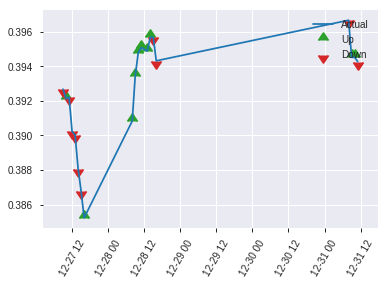


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19450692475830603
RMSE: 0.4410293921705287
LogLoss: 0.5716755337814297
Mean Per-Class Error: 0.2911671661671662
AUC: 0.7680652680652681
pr_auc: 0.6522043050979067
Gini: 0.5361305361305362
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3949725031852722: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   55   0.4167   (55.0/132.0)
1      16   75   0.1758   (16.0/91.0)
Total  93   130  0.3184   (71.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394973     0.678733  129
max f2                       0.270634     0.80705   174
max f0point5                 0.539314     0.660592  86
max accuracy                 0.539314     0.721973  86
max precision                0.819155     1         0
max recall                   0.160849     1         205
max specificity              0.819155     1         0
max absolute_mcc             0.539314     0.420831  86
max min_per_class_accuracy   0.515626     0.692308  102
max mean_per_class_accuracy  0.539314     0.708833  86

Gains/Lift Table: Avg response rate: 40.81 %, avg score: 46.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.795754           2.45055   2.45055            1                0.805087  1                           0.805087            0.032967        0.032967                   145.055   145.055
    2        0.0224215                   0.787304           1.22527   1.96044            0.5              0.790846  0.8                         0.79939             0.010989        0.043956                   22.5275   96.044
    3        0.0313901                   0.778316           1.22527   1.75039            0.5              0.782814  0.714286                    0.794654            0.010989        0.0549451                  22.5275   75.0392
    4        0.0403587                   0.77276            2.45055   1.90598            1                0.776229  0.777778                    0.79056             0.021978        0.0769231                  145.055   90.5983
    5        0.0538117                   0.769519           0         1.42949            0                0.770545  0.583333                    0.785556            0               0.0769231                  -100      42.9487
    6        0.103139                    0.730461           2.22777   1.81128            0.909091         0.748665  0.73913                     0.767913            0.10989         0.186813                   122.777   81.1276
    7        0.152466                    0.698846           1.78222   1.80187            0.727273         0.710577  0.735294                    0.749363            0.0879121       0.274725                   78.2218   80.1875
    8        0.201794                    0.675563           1.78222   1.79707            0.727273         0.685449  0.733333                    0.73374             0.0879121       0.362637                   78.2218   79.707
    9        0.300448                    0.614303           1.44805   1.68247            0.590909         0.644347  0.686567                    0.704387            0.142857        0.505495                   44.8052   68.2467
    10       0.399103                    0.532548           1.33666   1.59699            0.545455         0.574399  0.651685                    0.672255            0.131868        0.637363                   33.6663   59.6987
    11       0.502242                    0.474932           0.958911  1.46595            0.391304         0.511762  0.598214                    0.639297            0.0989011       0.736264                   -4.10893  46.5954
    12       0.600897                    0.391004           0.891109  1.37158            0.363636         0.417159  0.559701                    0.602826            0.0879121       0.824176                   -10.8891  37.1576
    13       0.699552                    0.336255           0.668332  1.2724             0.272727         0.367117  0.519231                    0.569585            0.0659341       0.89011                    -33.1668  27.2401
    14       0.798206                    0.257213           0.668332  1.19774            0.272727         0.294606  0.488764                    0.535599            0.0659341       0.956044                   -33.1668  19.774
    15       0.896861                    0.177398           0.222777  1.09049            0.0909091        0.214484  0.445                       0.500276            0.021978        0.978022                   -77.7223  9.04945
    16       1                           0.0978412          0.213091  1                  0.0869565        0.140454  0.408072                    0.463165            

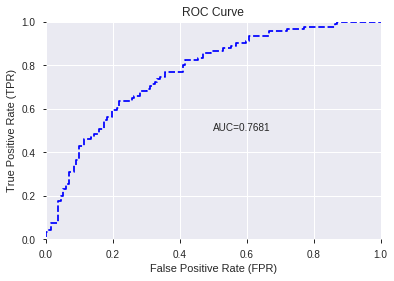

This function is available for GLM models only


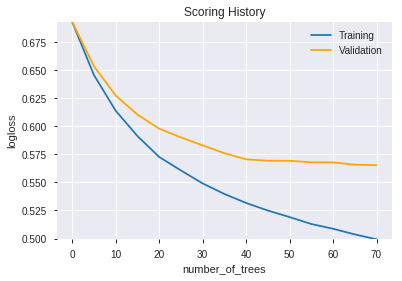

--2019-08-27 17:21:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_172058_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_172058_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_842b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CCI_12',
 'ATR_12',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'DX_30',
 'ADXR_12',
 'STOCHRSI_fastd',
 'PLUS_DI_12',
 'MFI_20',
 'ADX_8',
 'STOCH_slowd',
 'STDDEV_14',
 'LINEARREG_ANGLE_8',
 'HT_PHASOR_quadrature',
 'BETA_8',
 'ROCR_30',
 'WILLR_12',
 'WILLR_8',
 'NATR_20',
 'BETA_14',
 'DX_24',
 'TRIMA_20',
 'NATR_14',
 'aroonup_12',
 'HT_DCPERIOD',
 'BETA_12',
 'MACDFIX_signal_24',
 'ROC_20',
 'WILLR_14',
 'RSI_14',
 'PLUS_DM_20',
 'aroondown_14',
 'MACDFIX_20',
 'ROC_14',
 'aroonup_24',
 'LINEARREG_12',
 'ROCP_24',
 'ROCP_12',
 'ROCP_8',
 'MOM_8',
 'LINEARREG_ANGLE_12',
 'MOM_12',
 'AROONOSC_30',
 'AROONOSC_8']

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.744
GLM             0.753
XGBoost         0.758
dtype: float64

DeepLearning    GLM  XGBoost
All          0.735  0.704    0.731
DLF          0.740  0.722    0.726
Fwe          0.735  0.726    0.758
RFE          0.744  0.753    0.722
XGBF         0.717  0.722    0.726





F1


DeepLearning    0.715
GLM             0.694
XGBoost         0.715
dtype: float64

DeepLearning    GLM  XGBoost
All          0.686  0.682    0.687
DLF          0.685  0.691    0.689
Fwe          0.715  0.694    0.715
RFE          0.680  0.687    0.679
XGBF         0.692  0.691    0.689





auc


DeepLearning    0.793
GLM             0.801
XGBoost         0.801
dtype: float64

DeepLearning    GLM  XGBoost
All          0.785  0.760    0.777
DLF          0.784  0.777    0.773
Fwe          0.793  0.785    0.801
RFE          0.781  0.801    0.768
XGBF         0.787  0.777    0.773





logloss


DeepLearning    0.601
GLM             0.575
XGBoost         0.572
dtype: float64

DeepLearning    GLM  XGBoost
All          0.548  0.575    0.562
DLF          0.601  0.558    0.562
Fwe          0.537  0.553    0.540
RFE          0.568  0.541    0.572
XGBF         0.564  0.558    0.562





mean_per_class_error


DeepLearning    0.282
GLM             0.290
XGBoost         0.291
dtype: float64

DeepLearning    GLM  XGBoost
All          0.280  0.290    0.287
DLF          0.282  0.287    0.279
Fwe          0.252  0.290    0.246
RFE          0.276  0.263    0.291
XGBF         0.277  0.287    0.279





rmse


DeepLearning    0.445
GLM             0.444
XGBoost         0.441
dtype: float64

DeepLearning    GLM  XGBoost
All          0.433  0.444    0.436
DLF          0.445  0.436    0.436
Fwe          0.427  0.433    0.425
RFE          0.439  0.428    0.441
XGBF         0.437  0.436    0.436





mse


DeepLearning    0.198
GLM             0.197
XGBoost         0.195
dtype: float64

DeepLearning    GLM  XGBoost
All          0.188  0.197    0.190
DLF          0.198  0.190    0.190
Fwe          0.182  0.187    0.181
RFE          0.193  0.183    0.195
XGBF         0.191  0.190    0.190

{'F1':       DeepLearning    GLM  XGBoost
 All          0.686    NaN      NaN
 DLF          0.685    NaN      NaN
 DLF            NaN  0.691      NaN
 DLF            NaN    NaN    0.689
 All            NaN  0.682      NaN
 All            NaN    NaN    0.687
 XGBF         0.692    NaN      NaN
 XGBF           NaN  0.691      NaN
 XGBF           NaN    NaN    0.689
 Fwe          0.715    NaN      NaN
 Fwe            NaN  0.694      NaN
 Fwe            NaN    NaN    0.715
 RFE          0.680    NaN      NaN
 RFE            NaN  0.687      NaN
 RFE            NaN    NaN    0.679,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.735    NaN      NaN
 DLF          0.740    NaN      NaN
 DLF            NaN  0.722      NaN
 DLF            NaN    NaN    0.726
 All            NaN  0.704      NaN
 All            NaN    NaN    0.731
 XGBF         0.717    NaN      NaN
 XGBF           NaN  0.722      NaN
 XGBF           NaN    NaN    0.726
 Fwe          0.735    NaN      NaN
 Fwe     